In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from sklearn.linear_model import LinearRegression
import sklearn
import pdb
import scipy
from scipy.optimize import minimize, fmin
from scipy.stats import multivariate_normal
import xlrd
from tqdm.notebook import tqdm
import matplotlib
from mpl_toolkits import mplot3d
import pingouin as pg
import statsmodels.api as sm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['tahoma']
def makeAxesPretty(ax):
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

/Users/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
""" 
Obtaining data from a given long context expt
"""
Test = pd.read_csv('../auditory_categorization_noContext/important_things_not_included_in_assets/allTrials_noBias.csv')
Data = pd.read_csv('subjectDataForPlots/noContextData/601306071a72651244570d04_categorization_task_2021-05-18_04h46.56.555.csv');

TestLc = pd.read_csv('../auditory_categorization_longLow/important_things_not_included_in_assets/allTrials.csv')
DataLc = pd.read_csv('subjectDataForPlots/biasedLowContextData/601306071a72651244570d04_categorization_task_longLow_2021-06-09_03h41.33.989.csv');

TestHc = pd.read_csv('../auditory_categorization_longHigh/important_things_not_included_in_assets/allTrials.csv')
DataHc = pd.read_csv('subjectDataForPlots/biasedHighContextData/601306071a72651244570d04_categorization_task_longHigh_2021-06-16_23h31.15.482.csv');

xls = pd.ExcelFile('../uncertaintyCode/clusterResultsForSubsampledData.xls')
computedLikelihoods = pd.read_excel(xls,'NoContextModelFits')
computedLikelihoodsVeridical = pd.read_excel(xls,'NoContextModelFits_veridicalPar')
computedLikelihoodsLowContext = pd.read_excel(xls,'LowContextModelFits')
computedLikelihoodsLowContextVeridical = pd.read_excel(xls,'BiasedLowModelFits_veridicalPar')
computedLikelihoodsHighContext = pd.read_excel(xls,'HighContextModelFits')
computedLikelihoodsHighContextVeridical = pd.read_excel(xls,'BiasedHighModelFits_veridicalPa')


In [3]:
expt_freq_seq = np.arange(90,3000,1) #array of possible true tones
expt_log_freq_seq_array = np.arange(np.log10(expt_freq_seq[0]), np.log10(expt_freq_seq[-1]), 
                                    np.log10(1003/1000)*40)
log_freq_seq_mid = np.median(expt_log_freq_seq_array)
log_freq_percept = np.arange(0.6,4.7,0.1)
log_freq_seq_array = np.arange(0.6,4.7,0.1)
log_freq_low = [log_freq_seq_mid - 0.15,0.1]  #low freq condition is gaussian 
log_freq_high = [log_freq_seq_mid + 0.15,0.1] 

def extractData(csv_test, csv_data, exptTotalLength, exptLengthWithBreaks):  
    n_tones=3
    n_trials = csv_data.shape[0]-47

    test_columns = list(csv_test.columns)
    test_tones_name = test_columns.index('Name')
    test_tones_col_idx = test_columns.index('Tones')
    test_toneKind_col_idx = test_columns.index('Tonekind')
    df_names = (csv_test.iloc[0:exptTotalLength,test_tones_name]).values
    df_tones = (csv_test.iloc[0:exptTotalLength,test_tones_col_idx]).values
    df_toneKind = (csv_test.iloc[0:exptTotalLength,test_toneKind_col_idx]).values

    tones_array_orig = np.zeros((n_trials,n_tones))
    toneKind_array_orig = np.zeros((n_trials,n_tones))
    tones_array_idxs_keep = []

    for i_wav in range(exptLengthWithBreaks):
        if isinstance(csv_data['Name'][i_wav+46],str):
            tones_array_orig[i_wav,:] = np.array(df_tones[np.where(csv_data['Name'][i_wav+46]\
                                                              ==df_names)[0]][0][1:-1].split(',')).astype(float)  
            toneKind_array_orig[i_wav,:] = np.array(df_toneKind[np.where(csv_data['Name'][i_wav+46]\
                                                              ==df_names)[0]][0][1:-1].split(',')).astype(float)  
            tones_array_idxs_keep += [i_wav]


    exptTones = np.copy(tones_array_orig[tones_array_idxs_keep,:])
    exptToneKind = np.copy(toneKind_array_orig[tones_array_idxs_keep,:])
    exptCorrans = np.copy(csv_data['corrAns'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    exptKeys = np.copy(csv_data['test_resp.keys'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    
    return exptTones, exptToneKind, exptCorrans, exptKeys

def identifyResponseTrials(tonesPlayed,tonesSignalOrDistractor,correctAns,keysPressed,
                           exptTotalLength):
    no_response = np.intersect1d(np.where(keysPressed!='h')[0],
                                 np.where(keysPressed!='l')[0])
    #print("Did not respond to: ",no_response)

    """
    Convert keys ['l','h'] to [0,1]
    """

    corrans_num_orig = np.zeros_like(correctAns)
    corrans_num_orig[correctAns == 'h'] = 1

    keys_num_orig = np.zeros_like(keysPressed)
    keys_num_orig[keysPressed == 'h'] = 1

    corrans_num = corrans_num_orig[:exptTotalLength]
    keys_num = keys_num_orig[:exptTotalLength]
    tones_array = tonesPlayed[:exptTotalLength]
    tonesType_array = tonesSignalOrDistractor[:exptTotalLength]

    trial_tones = np.repeat(tones_array,1,axis = 0)
    trial_behaviour = np.reshape(keys_num,np.prod(keys_num.shape)) 
    idxs_with_response = np.delete(np.arange(len(trial_tones)),no_response)
    trialTonesResponded = trial_tones[idxs_with_response,:]
    trialBehaviourResponded = trial_behaviour[idxs_with_response]
    corransResponded = corrans_num[idxs_with_response]
    tonesTypeResponded = tonesType_array[idxs_with_response]
    #print(f"Total trials played are {len(trial_tones)}, and total trials responded to are {len(trialTonesResponded)}")
    #print("Got correct: ", np.sum(trialBehaviourResponded==corransResponded)/len(trialTonesResponded))
    #print("No. of minority category correct: ", np.sum(keys_num*corrans_num)/np.sum(corrans_num))
    
    return trialTonesResponded, tonesTypeResponded, corransResponded, trialBehaviourResponded 

def plottingInfluenceFn(tones, behaviour):
    unique_tones = np.unique(tones)

    tone1_prob_behaviour = np.zeros((len(unique_tones),1))
    tone2_prob_behaviour = np.zeros((len(unique_tones),1))
    tone3_prob_behaviour = np.zeros((len(unique_tones),1))

    for i_tone in range(len(unique_tones)):
        tone1_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,0]==unique_tones[i_tone]])
        tone2_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,1]==unique_tones[i_tone]])
        tone3_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,2]==unique_tones[i_tone]])
    behaviour = np.concatenate((tone1_prob_behaviour,tone2_prob_behaviour,tone3_prob_behaviour),axis=1)
    return unique_tones, behaviour    

def gaussian(x, mean, sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))

def Tones3dgrid(latentTones, sigma):
    
    input_array_0 = np.expand_dims(gaussian(log_freq_percept, latentTones[0], sigma), axis = 1)
    input_array_1 = np.expand_dims(gaussian(log_freq_percept, latentTones[1], sigma), axis = 1)
    input_array_2 = np.expand_dims(gaussian(log_freq_percept, latentTones[2], sigma), axis = 1)
    s0 = 1/np.sum(input_array_0); s1 = 1/np.sum(input_array_1); s2 = 1/np.sum(input_array_2)
    input_array_0 *= s0; input_array_1 *= s1; input_array_2 *= s2; 
    
    input_array_mat = np.expand_dims(input_array_0@input_array_1.T,axis=2)@(input_array_2.T) #p(T1,T2..|H)     
    
    return input_array_mat

def posterior_array(freq_input, n_tones, p_back, log_prior):
    """
    Arguments: 
    freq_input - range of all possible frequencies (percepts?)
    p_back - prob of background
    p_low - prob of low condition
    log_prior - list of prior parameters
    """
    
    log_prior_low_mean = log_prior[0]; log_prior_low_sigma = log_prior[2];
    log_prior_high_mean = log_prior[1]; log_prior_high_sigma = log_prior[2];
    likelihood_onetone_low = gaussian(x=freq_input, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    likelihood_onetone_high = gaussian(x=freq_input, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    likelihood_onetone_mixed_high = p_back*(1/len(freq_input)) + (1-p_back)*likelihood_onetone_high
    #mixture model with p(T|B) = 1/no. of possible freqs
    likelihood_onetone_mixed_high /= likelihood_onetone_mixed_high.sum() #normalizing
    likelihood_onetone_mixed_high = np.expand_dims(likelihood_onetone_mixed_high, axis = 1)
    likelihood_onetone_mixed_low = p_back*(1/len(freq_input)) + (1-p_back)*likelihood_onetone_low
    #mixture model with p(T|B) = 1/no. of possible freqs
    likelihood_onetone_mixed_low /= likelihood_onetone_mixed_low.sum() #normalizing
    likelihood_onetone_mixed_low = np.expand_dims(likelihood_onetone_mixed_low, axis = 1)
        
    if n_tones == 3:
        likelihood_alltones_low = (np.expand_dims(likelihood_onetone_mixed_low@np.transpose
                                                 (likelihood_onetone_mixed_low),axis=2)
                                   @np.transpose(likelihood_onetone_mixed_low))
        #p(T1,T2..|L) 
        likelihood_alltones_high = (np.expand_dims(likelihood_onetone_mixed_high@np.transpose
                                                 (likelihood_onetone_mixed_high),axis=2)
                                    @np.transpose(likelihood_onetone_mixed_high))
        #p(T1,T2..|H) 
    elif n_tones == 1:
        likelihood_alltones_low = likelihood_onetone_mixed_low
        likelihood_alltones_high = likelihood_onetone_mixed_high

    return [likelihood_onetone_mixed_high, likelihood_onetone_mixed_low, 
            likelihood_alltones_high, likelihood_alltones_low]

def task(n_trials = 10, n_tones = 3, p_low = 0.5, p_back = 0.3):
    trial_tones = np.zeros((n_trials,n_tones))
    dist_chosen = np.zeros((n_trials,))
    kind_of_tones = np.zeros((n_trials,n_tones))
    for trial in range(n_trials):
        signal_rand = np.random.random()
        low_dist = signal_rand < p_low #choosing true tone from either low or high condition
        tones = np.zeros((n_tones,))
        tone_kind = np.zeros((n_tones,))
        for n_tone in range(n_tones):
            signal_back = np.random.random()
            background = signal_back < p_back #choosing background or true tone
            if background:
                nearest_log_tone = np.random.choice(expt_log_freq_seq_array) 
                tone_kind[n_tone] = 0
            else: 
                if low_dist:
                    tone = min(max(np.random.randn()*log_freq_low[1] + log_freq_low[0],\
                                   expt_log_freq_seq_array[0]),expt_log_freq_seq_array[-1])
                    tone_kind[n_tone] = 1
                else:
                    tone = min(max(np.random.randn()*log_freq_high[1] + log_freq_high[0],\
                                   expt_log_freq_seq_array[0]),expt_log_freq_seq_array[-1])
                    tone_kind[n_tone] = 2
                nearest_log_tone = expt_log_freq_seq_array[np.argmin(np.abs(expt_log_freq_seq_array - tone))]
            nearest_tone = expt_freq_seq[np.argmin(np.abs(expt_freq_seq - 10**nearest_log_tone))]
            tones[n_tone] = nearest_tone
        trial_tones[trial,:] = tones
        dist_chosen[trial] = 1-int(low_dist)
        kind_of_tones[trial,:] = tone_kind
    return trial_tones, dist_chosen, kind_of_tones


def generate_behaviour(sim_trial_tones, dist_chosen, reps, n_tones, 
                       log_prior_params,
                       sigma_sensory, 
                       prob_back, 
                       Wconstant, W1, tau):    
    all_trial_tones = np.empty((len(sim_trial_tones)*reps,n_tones))
    all_trial_behaviour = np.zeros((len(sim_trial_tones)*reps,1))
    prob_trial_behaviour = np.zeros((len(sim_trial_tones),1))
    probability_sim_high = np.zeros((len(sim_trial_tones),1))

    [_,_,LikelihoodLatentTonegivenHigh,LikelihoodLatentTonegivenLow] = \
    posterior_array(log_freq_seq_array, n_tones=len(sim_trial_tones[0]),
                    p_back=prob_back, log_prior=log_prior_params)

    LikelihoodPerceptgivenHigh = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))
    LikelihoodPerceptgivenLow = np.zeros((len(log_freq_percept),len(log_freq_percept),len(log_freq_percept)))

    for itrue1 in range(len(log_freq_percept)):
        for itrue2 in range(len(log_freq_percept)):
            for itrue3 in range(len(log_freq_percept)):
                probPerceptgivenLatentTones = Tones3dgrid([log_freq_percept[itrue1],
                                                           log_freq_percept[itrue2],
                                                           log_freq_percept[itrue3]],sigma=sigma_sensory)
                LikelihoodPerceptgivenHigh \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenHigh[itrue1,itrue2,itrue3]
                LikelihoodPerceptgivenLow \
                += probPerceptgivenLatentTones * LikelihoodLatentTonegivenLow[itrue1,itrue2,itrue3]
                
    all_trial_tones[0,:] = sim_trial_tones[0]  
    for i_stim in range(1,len(sim_trial_tones)):
        arePrevTrialsLow = 1-2*dist_chosen[:i_stim]
        prob_low = np.clip(Wconstant + W1*np.sum(np.flip(arePrevTrialsLow)*np.exp(-(np.arange(i_stim)+1)/tau)),
                           a_min=0,a_max=1)
        probHighgivenPercept = LikelihoodPerceptgivenHigh*(1-prob_low)/\
        (LikelihoodPerceptgivenHigh*(1-prob_low) + LikelihoodPerceptgivenLow*prob_low)
        
        input_array = np.random.normal(loc=np.log10(sim_trial_tones[i_stim]),
                                       scale=sigma_sensory,
                                       size=(reps,1,n_tones)) 
        for i_tperc in range(reps):
            perc_tone_idxs = np.zeros((n_tones,1),dtype=int)
            for i in range(n_tones):
                perc_tone_idxs[i] = np.argmin(np.abs(log_freq_percept-input_array[i_tperc][0][i]))
                # find relevant adjacent freq percepts   
            posterior_perc_tone = probHighgivenPercept[perc_tone_idxs[0],perc_tone_idxs[1],perc_tone_idxs[2]]
            trial_behaviour = np.squeeze(posterior_perc_tone) > 0.5
            all_trial_behaviour[i_stim*reps+i_tperc,:] = trial_behaviour
        all_trial_tones[i_stim*reps:(i_stim+1)*reps,:] = sim_trial_tones[i_stim]    
        prob_trial_behaviour[i_stim] = np.mean(all_trial_behaviour[i_stim*reps:(i_stim+1)*reps])

        gaussian_array_mat = Tones3dgrid(np.array([np.log10(sim_trial_tones[i_stim][0]),
                                                   np.log10(sim_trial_tones[i_stim][1]),
                                                   np.log10(sim_trial_tones[i_stim][2])]),sigma=sigma_sensory)         
        probability_sim_high[i_stim] = np.sum(np.multiply(probHighgivenPercept>0.5, gaussian_array_mat))


    """
    Shuffling the tones and the behaviour to simluate an experiment

    s = np.arange(all_trial_tones.shape[0])
    np.random.shuffle(s)
    all_trial_tones = all_trial_tones[s]
    all_trial_behaviour = all_trial_behaviour[s]
    """
    return all_trial_tones, prob_trial_behaviour

def generate_behaviourRandomChoice(params, trial_tones):
    sigma_sensory, prob_low = params[0], params[1] # inputs are guesses at our parameters  
    
    prob_trial_behaviour = np.zeros((len(trial_tones),1))
    for i_trial in range(len(trial_tones)):
        gaussian_array_mat = Tones3dgrid(np.array([np.log10(trial_tones[i_trial][0]),
                                                   np.log10(trial_tones[i_trial][1]),
                                                   np.log10(trial_tones[i_trial][2])]),sigma=sigma_sensory)
        prob_trial_behaviour[i_trial] = np.sum(np.multiply((1-prob_low), gaussian_array_mat))
            
    return trial_tones, prob_trial_behaviour


In [4]:
def noContextData(tones,toneTypes,corrans,keys):
    [trial_tones_expt, trial_tonesType_expt, 
    corrans_expt, trial_behaviour_expt] = identifyResponseTrials(keysPressed = keys,
                                                                 correctAns = corrans, 
                                                                 tonesPlayed = tones, 
                                                                 tonesSignalOrDistractor=toneTypes,
                                                                 exptTotalLength = 600)

    #print("Got correct: ", np.sum(trial_behaviour_expt==corrans_expt)/len(trial_tones_expt))
    return trial_tones_expt, trial_tonesType_expt, corrans_expt, trial_behaviour_expt

"""
Subsample the long context expt with a low category bias
"""
def subsampleLongContextLow(toneslc,toneTypeslc,corranslc,keyslc):
    [trial_tones_fulllc, trial_tonesType_fulllc, 
    corrans_fulllc, trial_behaviour_fulllc] = identifyResponseTrials(keysPressed = keyslc, 
                                                                     correctAns = corranslc, 
                                                                     tonesPlayed = toneslc, 
                                                                     tonesSignalOrDistractor=toneTypeslc,
                                                                     exptTotalLength = 800)
    idxHigh = np.arange(len(trial_behaviour_fulllc[0:]))[corrans_fulllc[0:]==1]
    idxLow = np.arange(len(trial_behaviour_fulllc[0:]))[corrans_fulllc[0:]==0]
    idxOfSmallerCategory = np.random.choice(idxLow,size=len(idxHigh),replace=False)
    idxToKeep = np.concatenate((idxHigh, idxOfSmallerCategory))
    corrans_exptlc = corrans_fulllc[idxToKeep]
    trial_behaviour_exptlc = trial_behaviour_fulllc[idxToKeep]
    trial_tones_exptlc = trial_tones_fulllc[idxToKeep,:]
    #print("Got correct: ", np.sum(trial_behaviour_exptlc==corrans_exptlc)/len(trial_tones_exptlc))
    return trial_tones_exptlc, trial_behaviour_exptlc

"""
Subsample the long context expt with a high category bias
"""
def subsampleLongContextHigh(toneshc,toneTypeshc,corranshc,keyshc):
    [trial_tones_fullhc, trial_tonesType_fullhc, 
     corrans_fullhc, trial_behaviour_fullhc] = identifyResponseTrials(keysPressed = keyshc, 
                                                                      correctAns = corranshc,
                                                                      tonesPlayed = toneshc,
                                                                      tonesSignalOrDistractor=toneTypeshc,
                                                                      exptTotalLength = 800)
    idxHigh = np.arange(len(trial_behaviour_fullhc[0:]))[corrans_fullhc[0:]==1]
    idxLow = np.arange(len(trial_behaviour_fullhc[0:]))[corrans_fullhc[0:]==0]
    idxOfSmallerCategory = np.random.choice(idxHigh,size=len(idxLow),replace=False)
    idxToKeep = np.concatenate((idxLow, idxOfSmallerCategory))
    corrans_expthc = corrans_fullhc[idxToKeep]
    trial_behaviour_expthc = trial_behaviour_fullhc[idxToKeep]
    trial_tones_expthc = trial_tones_fullhc[idxToKeep,:]
    #print("Got correct: ", np.sum(trial_behaviour_expthc==corrans_expthc)/len(trial_tones_expthc))
    return trial_tones_expthc, trial_behaviour_expthc

"""
Using raw data to calculate any inherent bias the subject develops
"""
def bias(trial_behaviour_longContext):
    return np.mean(trial_behaviour_longContext)

"""
Fitting experimental psychometric curves by generating simulated data and behaviour
"""
def fittingPsychometricCurve(PLowExpt,subjectFitParams,ifRandomChoice=0):
    moreTrainingTrials, corransOfTrials, _ = task(n_trials = 2000, n_tones = 3, 
                                                  p_back=0.3, p_low=PLowExpt)
    if ifRandomChoice:
        all_trial_tones, behaviourOfTrials = generate_behaviourRandomChoice(trial_tones=moreTrainingTrials,
                                                                            params=[subjectFitParams[3],
                                                                                    subjectFitParams[5]])
    else:        
        all_trial_tones, behaviourOfTrials = generate_behaviour(sim_trial_tones=moreTrainingTrials, 
                                                                dist_chosen=corransOfTrials,
                                                                reps=1, n_tones=3, 
                                                                log_prior_params = subjectFitParams[0:3], 
                                                                sigma_sensory = subjectFitParams[3],
                                                                prob_back = subjectFitParams[4],
                                                                Wconstant = subjectFitParams[5],
                                                                W1 = subjectFitParams[6],
                                                                tau = subjectFitParams[7])

    unique_tones_played, subjectBehaviourModelled = plottingInfluenceFn(all_trial_tones, 
                                                                        behaviourOfTrials)
    
    return unique_tones_played, subjectBehaviourModelled

    

/Users/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount
/var/folders/m4/ct3nmn6n0db0pt_1jjw_63w40000gp/T/ipykernel_25423/2825977920.py:70: RuntimeWarning: Mean of empty slice
  ax.errorbar(np.mean(np.log10(unique_tones_played),axis=0), np.nanmean(subjectBehaviourHC,axis=0),


length of subsample dataset in low context 472
length of subsample dataset in high context 460
p(L) given the no context is likely to be:  0.5442404006677797
P(L) given the long context data biased towards low is likely to be:  0.3516949152542373
P(L) given the long context data biased towards high is likely to be:  0.7043478260869566
Average deviation from 0.5 for frequencies that are likely distractors 0.68


/var/folders/m4/ct3nmn6n0db0pt_1jjw_63w40000gp/T/ipykernel_25423/709296955.py:207: RuntimeWarning: divide by zero encountered in true_divide
  prob_low = np.clip(Wconstant + W1*np.sum(np.flip(arePrevTrialsLow)*np.exp(-(np.arange(i_stim)+1)/tau)),


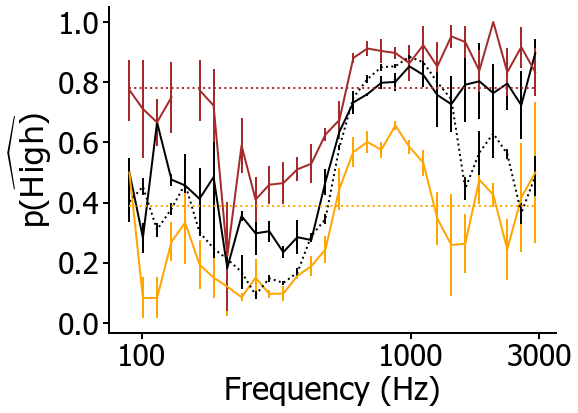

In [6]:
"""
Fig. 5: individual participant curves -- check parameter values from excel sheet attached
"""

df_tones, df_toneKind, df_corrans, df_keys = extractData(csv_test=Test, 
                                                        csv_data=Data, 
                                                        exptTotalLength=600, 
                                                        exptLengthWithBreaks=603) 

df_toneslc, df_toneKindlc, df_corranslc, df_keyslc = extractData(csv_test=TestLc, 
                                                                csv_data=DataLc, 
                                                                exptTotalLength=800, 
                                                                exptLengthWithBreaks=804) 


df_toneshc, df_toneKindhc, df_corranshc, df_keyshc = extractData(csv_test=TestHc, 
                                                                csv_data=DataHc, 
                                                                exptTotalLength=800, 
                                                                exptLengthWithBreaks=804) 

meanBiaslc = 0; meanBiashc = 0
numberOfSubsamples = 1
unique_tones_played = np.empty((numberOfSubsamples,30))
subjectBehaviourLC = np.empty((numberOfSubsamples,30))
subjectBehaviourHC = np.empty((numberOfSubsamples,30))
for iSubsample in range(numberOfSubsamples):
    sampledlc_tones, sampledlc_behaviour = subsampleLongContextLow(toneslc=df_toneslc, 
                                                                   toneTypeslc=df_toneKindlc,
                                                                   corranslc=df_corranslc, 
                                                                   keyslc=df_keyslc)
    sampledhc_tones, sampledhc_behaviour = subsampleLongContextHigh(toneshc=df_toneshc, 
                                                                    toneTypeshc=df_toneKindhc,
                                                                    corranshc=df_corranshc, 
                                                                    keyshc=df_keyshc)
    noContext_tones, _, _, noContext_behaviour = noContextData(tones=df_tones,
                                                               toneTypes=df_toneKind,
                                                               corrans=df_corrans,
                                                               keys=df_keys)
    _, allPositionssubjectBehaviour = plottingInfluenceFn(noContext_tones,
                                                          noContext_behaviour)
    
    unique_tones_played[iSubsample,:], allPositionssubjectBehaviourLC = plottingInfluenceFn(sampledlc_tones, 
                                                                                            sampledlc_behaviour)  
    subjectBehaviourLC[iSubsample,:] = np.mean(allPositionssubjectBehaviourLC,axis=1)
    meanBiaslc += bias(sampledlc_behaviour)
    
    unique_tones_played[iSubsample,:], allPositionssubjectBehaviourHC = plottingInfluenceFn(sampledhc_tones,
                                                                                            sampledhc_behaviour)  
    subjectBehaviourHC[iSubsample,:] = np.mean(allPositionssubjectBehaviourHC,axis=1)
    meanBiashc += bias(sampledhc_behaviour)
    
print("length of subsample dataset in low context", len(sampledlc_tones))
print("length of subsample dataset in high context", len(sampledhc_tones))
    
print("p(L) given the no context is likely to be: ",np.mean(noContext_behaviour))
print("P(L) given the long context data biased towards low is likely to be: ", meanBiaslc/numberOfSubsamples)
print("P(L) given the long context data biased towards high is likely to be: ", meanBiashc/numberOfSubsamples)

print("Average deviation from 0.5 for frequencies that are likely distractors",
      round(np.mean([0.5-np.nanmean(allPositionssubjectBehaviour[:7,:]), 
               np.nanmean(allPositionssubjectBehaviour[-8:,:])-0.5])
            /np.mean(abs(allPositionssubjectBehaviour-0.5)), 2))

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(np.mean(np.log10(unique_tones_played),axis=0), np.nanmean(allPositionssubjectBehaviour,axis=1), 
            yerr=np.nanstd(allPositionssubjectBehaviour,axis=1)/np.sqrt(3),color='k',linewidth=2)

ax.errorbar(np.mean(np.log10(unique_tones_played),axis=0), np.nanmean(subjectBehaviourLC,axis=0), 
            yerr=np.nanstd(allPositionssubjectBehaviourLC,axis=1)/np.sqrt(3),color='orange',linewidth=2)
ax.errorbar(np.mean(np.log10(unique_tones_played),axis=0), np.nanmean(subjectBehaviourHC,axis=0), 
            yerr=np.nanstd(allPositionssubjectBehaviourHC,axis=1)/np.sqrt(3),color='brown',linewidth=2)

simulatedTrials, simulatedBehaviourUnbiased = fittingPsychometricCurve(PLowExpt=0.5, 
                                                                       subjectFitParams=[2.55,2.85,0.1,0.15,0.79,
                                                                                        0.52,0,0],
                                                                       ifRandomChoice=0)

plt.errorbar(np.log10(simulatedTrials), 
             np.mean(simulatedBehaviourUnbiased,axis=1),
             yerr = np.std(simulatedBehaviourUnbiased,axis=1)/np.sqrt(3),
             color='k',linestyle='dotted',linewidth=2)

simulatedTrials, simulatedBehaviourBiasedLow = fittingPsychometricCurve(PLowExpt=0.7, 
                                                                        subjectFitParams=[2.55,2.85,0.1,0.19,0.89,
                                                                                         0.61,0,0],
                                                                        ifRandomChoice=1)

plt.errorbar(np.log10(simulatedTrials), 
             np.mean(simulatedBehaviourBiasedLow,axis=1),
             yerr = np.std(simulatedBehaviourBiasedLow,axis=1)/np.sqrt(3),
             color='orange',linestyle='dotted',linewidth=2)

simulatedTrials, simulatedBehaviourBiasedHigh = fittingPsychometricCurve(PLowExpt=0.3, 
                                                                        subjectFitParams=[2.55,2.85,0.1,0.19,0.81,
                                                                                          0.22,0,0],
                                                                        ifRandomChoice=1)

plt.errorbar(np.log10(simulatedTrials), 
             np.mean(simulatedBehaviourBiasedHigh,axis=1),
             yerr = np.std(simulatedBehaviourBiasedHigh,axis=1)/np.sqrt(3),
             color='brown',linestyle='dotted',linewidth=2)

ax.set_xticks(ticks=np.log10([100,1000,3000]))
ax.set_xticklabels(labels=[100,1000,3000])
ax.set_yticks(ticks=np.arange(0,1.1,0.2))
ax.set_yticklabels(labels=np.around(np.arange(0,1.1,0.2),1))
ax.tick_params(axis='both',labelsize=30,length=6,width=2)
ax.set_xlabel('Frequency (Hz)',fontsize=32)
ax.set_ylabel(r'p($\rm{\widehat{High}}$)',fontsize=32)
makeAxesPretty(ax)

#plt.savefig('figures/FromProlific/illustrations/e21e_pBHgivenT_forNoandLongContext.pdf',
#           bbox_inches='tight',transparent=True)


/Users/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount
/var/folders/m4/ct3nmn6n0db0pt_1jjw_63w40000gp/T/ipykernel_25423/3928141141.py:146: RuntimeWarning: Mean of empty slice
  subjectBehaviourOneDistractor[subjectIdx,:,1] = np.nanmean(tempOne[:,1:],axis=1)


Mean correlation tone position [0.33302422 0.32436254 0.34261324]
SEM correlation tone position [0.01196682 0.01065143 0.00999069]
Mean and SEM correlation signal vs distractor tones for no distractor trials 0.9064392136220439 0.007429045922862774
Mean and SEM correlation signal vs distractor tones for one distractor trials 0.28541339018839945 0.03001472292209838 0.8698363437625244 0.01065030847160918
Mean and SEM correlation signal vs distractor tones for two distractor trials 0.4730870010890725 0.02087994376039812 0.7775933235710379 0.01807173247031016
         Source  ddof1  ddof2         F     p-unc       np2       eps
0  TonePosition      2    110  0.903891  0.407977  0.016169  0.912597
                T  dof alternative         p-val           CI95%   cohen-d  \
T-test -16.210533   55   two-sided  1.321028e-22  [-0.66, -0.51]  3.345999   

             BF10  power  
T-test  3.171e+19    1.0  
               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -12.

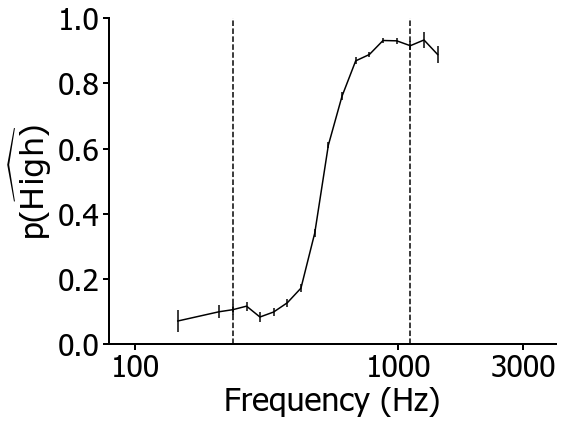

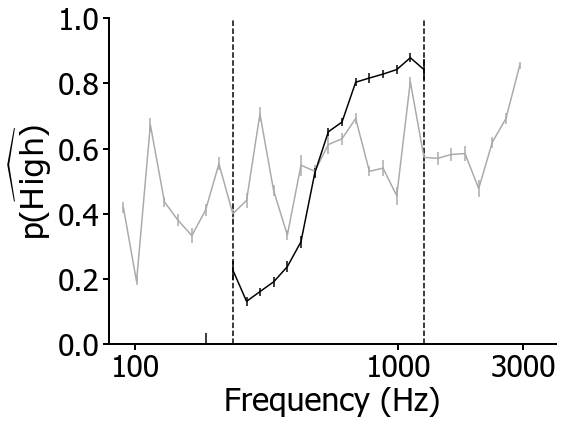

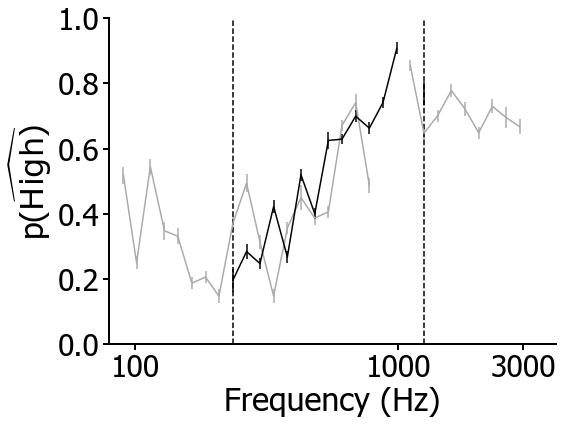

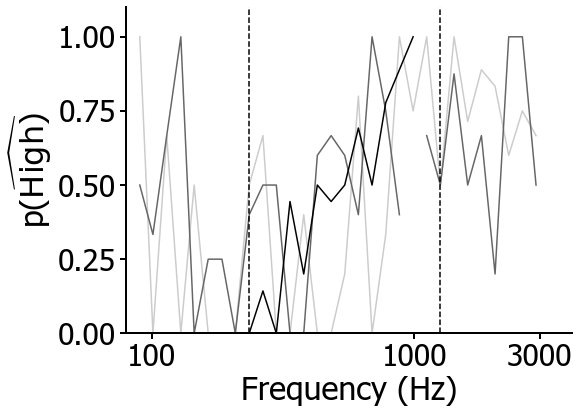

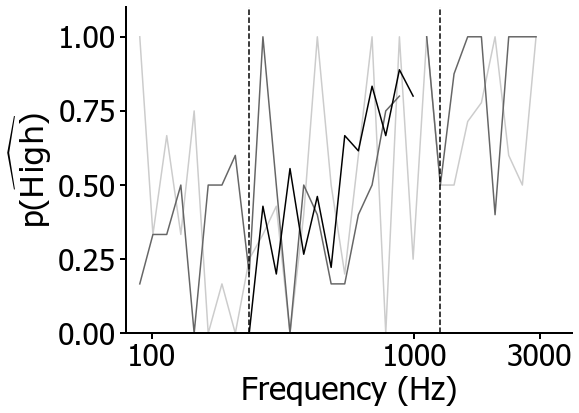

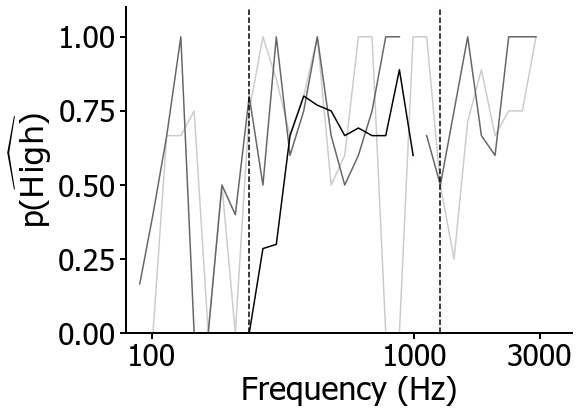

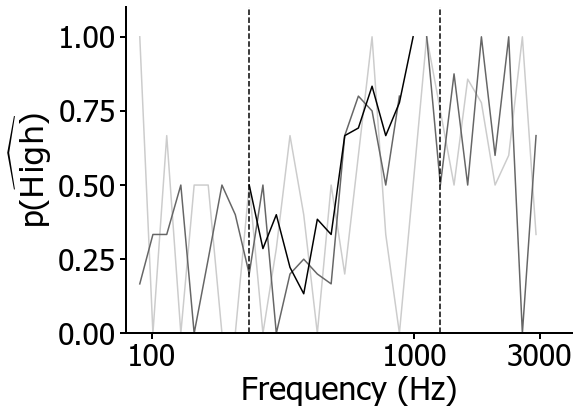

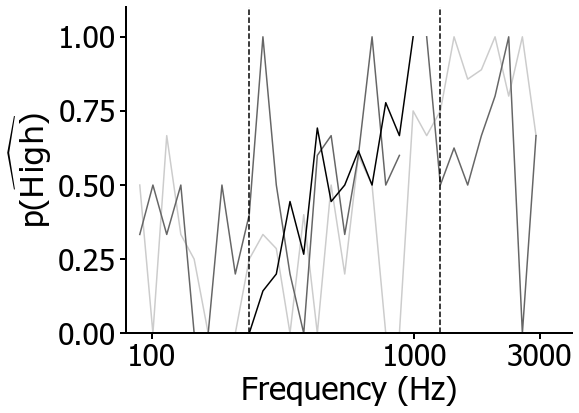

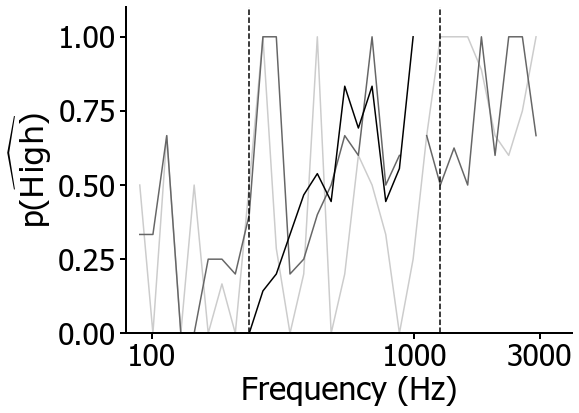

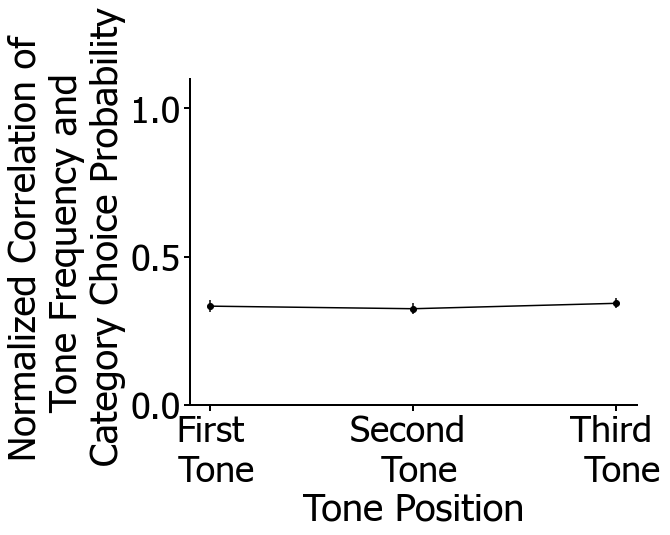

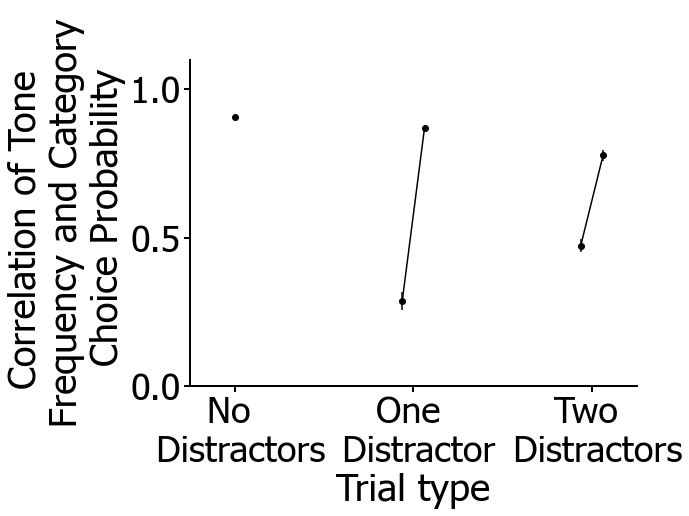

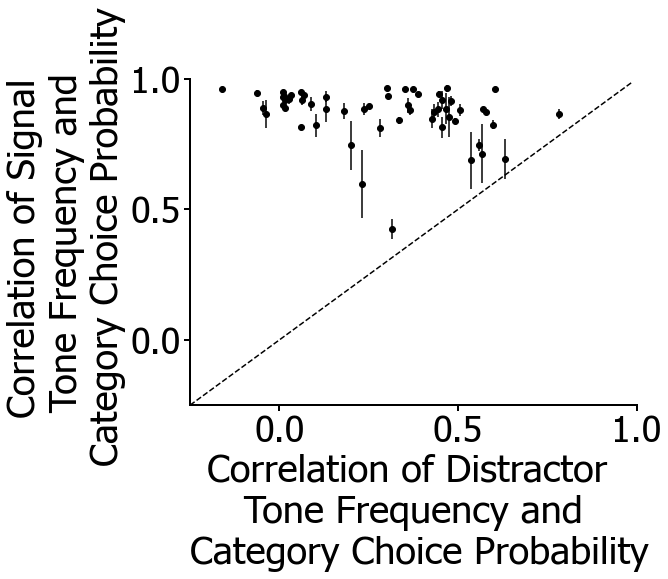

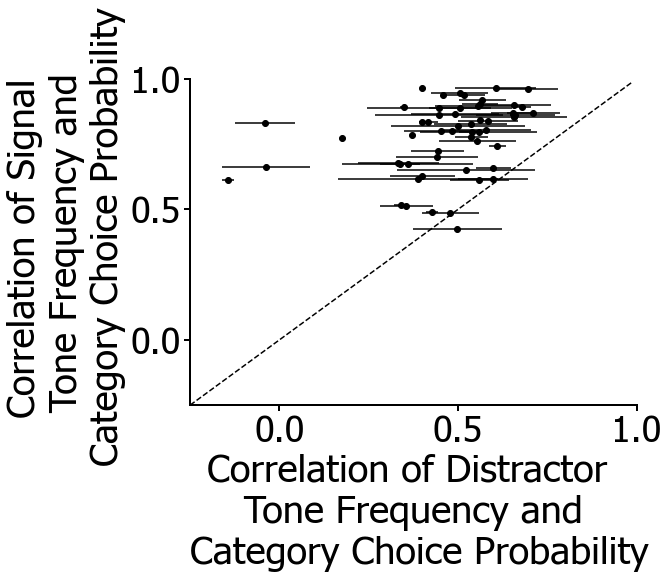

In [7]:
"""
Figs. 2A-D, extended data 1: Behavioural analysis across all subjects
Qs: How important are the different tone positions and what is the behavioural relevance of signals vs distractors?
"""

Test = pd.read_csv('../auditory_categorization_noContext/important_things_not_included_in_assets/allTrials_noBias.csv')
SubjectFiles = os.listdir('subjectDataForPlots/noContextData')
averageSubjectBehaviour = np.empty(shape=(56,30))
weightsOfTonesAllTrials = np.zeros(shape=(56,3))
meanWeightsOfTonesTwoDistractors = np.zeros(shape=(56,3))
meanWeightsOfTonesOneDistractor = np.zeros(shape=(56,3))
weightsOfTonesNoDistractorTrials = np.zeros(shape=(56,3))
subjectBehaviourTwoDistractors = np.zeros(shape=(56,30,3))
subjectBehaviourOneDistractor = np.zeros(shape=(56,30,2))
subjectBehaviourNoDistractors = np.zeros(shape=(56,18))

def meanWeightsOfTonePositions(tones, behaviour, accuracy):
    weightsOfTonePositions = np.zeros(shape=(3,))
    for toneIdx in range(3):
        unique_tones = np.unique(tones[:,toneIdx])
        meanPHighPerTone = np.zeros(shape=(len(unique_tones),))
        for i_uniqueTone in range(len(unique_tones)):
            meanPHighPerTone[i_uniqueTone] = np.mean(behaviour[tones[:,toneIdx]==
                                                               unique_tones[i_uniqueTone]])
        weightsOfTonePositions[toneIdx] = np.corrcoef(np.log10(unique_tones), meanPHighPerTone)[1,0]
    return weightsOfTonePositions

def meanWeightsOfTonesRelevance(tones, behaviour, accuracy):
    weightsOfTonePositions = np.zeros(shape=(3,))
    for toneIdx in range(3):
        unique_tones = np.unique(tones[:,toneIdx])
        unique_tones_center = unique_tones[np.logical_and(np.log10(unique_tones) < 3.05, 
                                                          np.log10(unique_tones) > 2.35)]
        meanPHighPerTone = np.zeros(shape=(len(unique_tones_center),))
        for i_uniqueTone in range(len(unique_tones_center)):
            meanPHighPerTone[i_uniqueTone] = np.mean(behaviour[tones[:,toneIdx]==
                                                               unique_tones_center[i_uniqueTone]])
        weightsOfTonePositions[toneIdx] = np.corrcoef(np.log10(unique_tones_center), meanPHighPerTone)[1,0]
    return weightsOfTonePositions

def swapPositions(tones, toneTypes, oneDistractor=1):
    if oneDistractor:
        swappedTones = np.copy(tones)
        swappedToneTypes = np.copy(toneTypes)
        for itrial in range(len(tones)):
            if toneTypes[itrial,1]==0:
                swappedToneTypes[itrial,0] = np.copy(toneTypes[itrial,1])
                swappedTones[itrial,0] = np.copy(tones[itrial,1])
                swappedToneTypes[itrial,1] = np.copy(toneTypes[itrial,0])
                swappedTones[itrial,1] = np.copy(tones[itrial,0])
            if toneTypes[itrial,2]==0:
                swappedToneTypes[itrial,0] = np.copy(toneTypes[itrial,2])
                swappedTones[itrial,0] = np.copy(tones[itrial,2])
                swappedToneTypes[itrial,2] = np.copy(toneTypes[itrial,0])
                swappedTones[itrial,2] = np.copy(tones[itrial,0])
    else:
        swappedTones = np.copy(tones)
        swappedToneTypes = np.copy(toneTypes)
        for itrial in range(len(tones)):
            if toneTypes[itrial,1]>0:
                swappedToneTypes[itrial,2] = np.copy(toneTypes[itrial,1])
                swappedTones[itrial,2] = np.copy(tones[itrial,1])
                swappedToneTypes[itrial,1] = np.copy(toneTypes[itrial,2])
                swappedTones[itrial,1] = np.copy(tones[itrial,2])
            if toneTypes[itrial,0]>0:
                swappedToneTypes[itrial,0] = np.copy(toneTypes[itrial,2])
                swappedTones[itrial,0] = np.copy(tones[itrial,2])
                swappedToneTypes[itrial,2] = np.copy(toneTypes[itrial,0])
                swappedTones[itrial,2] = np.copy(tones[itrial,0])
    return swappedTones, swappedToneTypes

def trialsWithIncongruentDistractor(tones, toneTypes, corrAns, trialIdxs):
    numelTrialIdxs = np.where(trialIdxs)[0]
    tonesOfTrialsWithDistractors = tones[numelTrialIdxs,:]
    toneTypesOfTrialsWithDistractors = toneTypes[numelTrialIdxs,:]
    corrAnsOfTrialsWithDistractors = corrAns[numelTrialIdxs]
    chosenTrialIdxs = np.array([])
    for trial in range(len(numelTrialIdxs)):
        if corrAnsOfTrialsWithDistractors[trial] == 1:
            if any(np.log10(tonesOfTrialsWithDistractors[trial,:]
                            [toneTypesOfTrialsWithDistractors[trial,:]==0]) > 2.7):
                chosenTrialIdxs = np.append(chosenTrialIdxs, numelTrialIdxs[trial])
        else:
            if any(np.log10(tonesOfTrialsWithDistractors[trial,:]
                            [toneTypesOfTrialsWithDistractors[trial,:]==0]) < 2.7):
                chosenTrialIdxs = np.append(chosenTrialIdxs, numelTrialIdxs[trial])
    return chosenTrialIdxs

for subjectIdx in range(56):  
    filename = 'subjectDataForPlots/noContextData/'+SubjectFiles[subjectIdx]  
    Data = pd.read_csv(filename)
    
    df_tones, df_toneKind, df_corrans, df_keys = extractData(csv_test=Test, 
                                                             csv_data=Data, 
                                                             exptTotalLength=600,
                                                             exptLengthWithBreaks=603) 
    
    [noContext_tones, noContext_toneTypes, 
    noContext_corrAns, noContext_behaviour] = noContextData(keys=df_keys,
                                                            toneTypes=df_toneKind,
                                                            corrans=df_corrans,
                                                            tones=df_tones)
    
    noContext_accuracy = noContext_behaviour==noContext_corrAns
    unique_tonesPlayed_overall, subjectBehaviour = plottingInfluenceFn(noContext_tones, noContext_behaviour)
    averageSubjectBehaviour[subjectIdx,:] = np.nanmean(subjectBehaviour,axis=1)    
    
    allTwoToneDistractorTrialsIdx = np.sum(noContext_toneTypes==0,axis=1)==2
    # select only those trials who distractor frequency is incongruent with trial category
    onlyIncongruentTrials = 0;
    if onlyIncongruentTrials:
        twoToneDistractorTrialsIdx = trialsWithIncongruentDistractor(tones = noContext_tones,
                                                                     toneTypes = noContext_toneTypes,
                                                                     corrAns = noContext_corrAns,
                                                                     trialIdxs = allTwoToneDistractorTrialsIdx).astype(int)
    else:
        twoToneDistractorTrialsIdx = np.copy(allTwoToneDistractorTrialsIdx)
    twoToneDistractorTrials, _ = swapPositions(tones=noContext_tones[twoToneDistractorTrialsIdx],
                                                toneTypes=noContext_toneTypes[twoToneDistractorTrialsIdx],
                                                oneDistractor=0)
    [unique_tonesPlayed_twoDistractors, tempTwo] = plottingInfluenceFn(twoToneDistractorTrials,
                                                                        noContext_behaviour[twoToneDistractorTrialsIdx])
    #subjectBehaviourTwoDistractors[subjectIdx,:,1] = np.copy(tempTwo[:,2])
    #subjectBehaviourTwoDistractors[subjectIdx,:,0] = np.nanmean(tempTwo[:,:2],axis=1)
    subjectBehaviourTwoDistractors[subjectIdx,:,:] = np.copy(tempTwo)
        
    meanWeightsOfTonesTwoDistractors[subjectIdx,:] = meanWeightsOfTonesRelevance(tones=twoToneDistractorTrials,
                                                                                behaviour=noContext_behaviour[twoToneDistractorTrialsIdx],
                                                                                accuracy=noContext_accuracy[twoToneDistractorTrialsIdx])
    
    allOneToneDistractorTrialsIdx = np.sum(noContext_toneTypes==0,axis=1)==1
    
    if onlyIncongruentTrials:
        oneToneDistractorTrialsIdx = trialsWithIncongruentDistractor(tones = noContext_tones,
                                                                     toneTypes = noContext_toneTypes,
                                                                     corrAns = noContext_corrAns,
                                                                     trialIdxs = allOneToneDistractorTrialsIdx).astype(int)
    else:
        oneToneDistractorTrialsIdx = np.copy(allOneToneDistractorTrialsIdx)
    oneToneDistractorTrials, _ = swapPositions(tones=noContext_tones[oneToneDistractorTrialsIdx],
                                                toneTypes=noContext_toneTypes[oneToneDistractorTrialsIdx],
                                                oneDistractor=1)
    [unique_tonesPlayed_oneDistractor, tempOne] = plottingInfluenceFn(oneToneDistractorTrials,
                                                                      noContext_behaviour[oneToneDistractorTrialsIdx])    
    subjectBehaviourOneDistractor[subjectIdx,:,0] = np.copy(tempOne[:,0])
    subjectBehaviourOneDistractor[subjectIdx,:,1] = np.nanmean(tempOne[:,1:],axis=1)
    
    meanWeightsOfTonesOneDistractor[subjectIdx,:] = meanWeightsOfTonesRelevance(tones=oneToneDistractorTrials,
                                                                                behaviour=noContext_behaviour[oneToneDistractorTrialsIdx],
                                                                                accuracy=noContext_accuracy[oneToneDistractorTrialsIdx])

    
    noDistractorTrialsIdx = np.sum(noContext_toneTypes==0,axis=1)==0
    [unique_tonesPlayed_noDistractors, tempNo] = plottingInfluenceFn(noContext_tones[noDistractorTrialsIdx],
                                                                    noContext_behaviour[noDistractorTrialsIdx])
    subjectBehaviourNoDistractors[subjectIdx,:] = np.nanmean(tempNo,axis=1) 
     
    weightsOfTonesNoDistractorTrials[subjectIdx,:] = meanWeightsOfTonesRelevance(tones=noContext_tones[noDistractorTrialsIdx],
                                                                                behaviour=noContext_behaviour[noDistractorTrialsIdx],
                                                                                accuracy=noContext_accuracy[noDistractorTrialsIdx])

    weightsOfTonesAllTrials[subjectIdx,:] = meanWeightsOfTonePositions(tones=noContext_tones,
                                                                        behaviour=noContext_behaviour,
                                                                        accuracy=noContext_accuracy)

"""
Average plots across all subjects
"""
fig1, ax1 = plt.subplots(1,1,figsize=(8,6))
fig2, ax2 = plt.subplots(1,1,figsize=(8,6))
fig3, ax3 = plt.subplots(1,1,figsize=(8,6))
ax1.errorbar(np.log10(unique_tonesPlayed_noDistractors), 
             np.mean(subjectBehaviourNoDistractors,axis=0),
             yerr=np.std(subjectBehaviourNoDistractors,axis=0)/np.sqrt(56),color='k')
ax1.axvline(x=np.log10(unique_tonesPlayed_noDistractors[2]), ymin=0, ymax=1, color='k', linestyle='--')
ax1.axvline(x=np.log10(unique_tonesPlayed_noDistractors[-3]), ymin=0, ymax=1, color='k', linestyle='--')
for tonePosition in [0,1]:
    ax2.errorbar(np.log10(unique_tonesPlayed_oneDistractor), 
                 np.mean(subjectBehaviourOneDistractor[:,:,tonePosition],axis=0),
                 yerr=np.std(subjectBehaviourOneDistractor[:,:,tonePosition],axis=0)/np.sqrt(56),
                 color=[(1-tonePosition)/1.5,(1-tonePosition)/1.5,(1-tonePosition)/1.5])
ax3.errorbar(np.log10(unique_tonesPlayed_twoDistractors), 
             np.mean(np.mean(subjectBehaviourTwoDistractors[:,:,:2],axis=2),axis=0),
             yerr=np.std(np.mean(subjectBehaviourTwoDistractors[:,:,:2],axis=2),axis=0)/np.sqrt(56),
             color=[1/1.5,1/1.5,1/1.5])
ax3.errorbar(np.log10(unique_tonesPlayed_twoDistractors), 
             np.mean(subjectBehaviourTwoDistractors[:,:,2],axis=0),
             yerr=np.std(subjectBehaviourTwoDistractors[:,:,2],axis=0)/np.sqrt(56),
             color=[0,0,0])  
ax2.axvline(x=np.log10(unique_tonesPlayed_oneDistractor[8]), ymin=0, ymax=1, color='k', linestyle='--')
ax2.axvline(x=np.log10(unique_tonesPlayed_oneDistractor[22]), ymin=0, ymax=1, color='k', linestyle='--')
ax3.axvline(x=np.log10(unique_tonesPlayed_twoDistractors[8]), ymin=0, ymax=1, color='k', linestyle='--')
ax3.axvline(x=np.log10(unique_tonesPlayed_twoDistractors[22]), ymin=0, ymax=1, color='k', linestyle='--')
for axes in [ax1,ax2,ax3]:
    axes.set_ylim([0,1])
    axes.set_xlim([1.9,3.6])
    axes.set_xticks(ticks=np.log10([100,1000,3000]))
    axes.set_xticklabels(labels=[100,1000,3000])
    axes.tick_params(axis='both',labelsize=30,length=6,width=2)
    axes.set_xlabel('Frequency (Hz)',fontsize=32)
    axes.set_ylabel(r'p($\rm{\widehat{High}}$)',fontsize=32)
    makeAxesPretty(axes)
#fig1.savefig('figures/FromProlific/illustrations/variationOfBehaviourWithToneFrequenciesNoDistractors.pdf',
#           bbox_inches='tight',transparent=True)
#fig2.savefig('figures/FromProlific/illustrations/variationOfBehaviourWithToneFrequenciesOneDistractor.pdf',
#            bbox_inches='tight',transparent=True)
#fig3.savefig('figures/FromProlific/illustrations/variationOfBehaviourWithToneFrequenciesTwoDistractors.pdf',
#            bbox_inches='tight',transparent=True)

"""
Plot per subject
"""
for iSubj in [0,8,14,15,16,39]:
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    for tonePosition in [0,1,2]:
        ax.plot(np.log10(unique_tonesPlayed_twoDistractors), 
                subjectBehaviourTwoDistractors[iSubj,:,tonePosition],
                color=[(2-tonePosition)/2.5,(2-tonePosition)/2.5,(2-tonePosition)/2.5]) 
    ax.axvline(x=np.log10(unique_tonesPlayed_twoDistractors[8]), ymin=0, ymax=1, color='k', linestyle='--')
    ax.axvline(x=np.log10(unique_tonesPlayed_twoDistractors[22]), ymin=0, ymax=1, color='k', linestyle='--')
    ax.set_ylim([0,1.1])
    ax.set_xlim([1.9,3.6])
    ax.set_xticks(ticks=np.log10([100,1000,3000]))
    ax.set_xticklabels(labels=[100,1000,3000])
    ax.tick_params(axis='both',labelsize=30,length=6,width=2)
    ax.set_xlabel('Frequency (Hz)',fontsize=32)
    ax.set_ylabel(r'p($\rm{\widehat{High}}$)',fontsize=32)
    makeAxesPretty(ax)
    #fig.savefig('figures/FromProlific/illustrations/subject-'+str(iSubj)+
    #            'variationOfBehaviourWithToneFrequenciesTwoDistractors.pdf',
    #            bbox_inches='tight',transparent=True)

"""
Weights of the three tone positions
"""
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(np.arange(3), 
            np.nanmean(weightsOfTonesAllTrials,axis=0)/sum(np.nanmean(weightsOfTonesAllTrials,axis=0)),
            yerr=np.nanstd(weightsOfTonesAllTrials,axis=0)/np.sqrt(56),linestyle=None,color='k',marker='o')
ax.set_xticks(ticks=[0,1,2])
ax.set_xticklabels(labels=['First\n Tone', 'Second \n Tone', 'Third \n Tone'])
ax.set_ylim([0,1.1])
ax.tick_params(axis='both',labelsize=36,length=6,width=2)
ax.set_xlabel('Tone Position',fontsize=38)
ax.set_ylabel('Normalized Correlation of \n Tone Frequency and \n Category Choice Probability',fontsize=38)
makeAxesPretty(ax)
#plt.savefig('figures/FromProlific/illustrations/weightsOfTonePositionsForAllTrials.pdf',
#           bbox_inches='tight',transparent=True)

"""
Tone relevance of signals vs distractors across three trial conditions
"""
normalizedWeightsOfTonesNoDistractorTrials = weightsOfTonesNoDistractorTrials/sum(np.nanmean(weightsOfTonesNoDistractorTrials,axis=0))
normalizedWeightsOfTonesOneDistractor = meanWeightsOfTonesOneDistractor/sum(np.nanmean(meanWeightsOfTonesOneDistractor,axis=0))
normalizedWeightsOfTonesTwoDistractors = meanWeightsOfTonesTwoDistractors/sum(np.nanmean(meanWeightsOfTonesTwoDistractors,axis=0))

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar([2], np.nanmean(weightsOfTonesNoDistractorTrials),
            yerr= np.nanstd(weightsOfTonesNoDistractorTrials)/np.sqrt(3*56),linestyle=None,color='k',marker='o')
ax.errorbar([9.5,10.5], [np.nanmean(meanWeightsOfTonesOneDistractor[:,0]),
                         np.nanmean(meanWeightsOfTonesOneDistractor[:,1:])],
            yerr=[np.nanstd(meanWeightsOfTonesOneDistractor[:,0])/np.sqrt(56),
                  np.nanstd(meanWeightsOfTonesOneDistractor[:,1:])/np.sqrt(2*56)],
            linestyle=None,color='k',marker='o')
ax.errorbar([17.5,18.5], [np.nanmean(meanWeightsOfTonesTwoDistractors[:,0:2]),
                          np.nanmean(meanWeightsOfTonesTwoDistractors[:,2])],
            yerr=[np.nanstd(meanWeightsOfTonesTwoDistractors[:,0:2])/np.sqrt(2*56),
                  np.nanstd(meanWeightsOfTonesTwoDistractors[:,2])/np.sqrt(56)],
            linestyle=None,color='k',marker='o')
ax.set_xticks(ticks=[2,10,18])
ax.set_xticklabels(labels=['No \n Distractors', 'One \n Distractor', 'Two \n Distractors'])
ax.set_xlim([0,20])
ax.set_ylim([0,1.1])
ax.tick_params(axis='both',labelsize=36,length=6,width=2)
ax.set_xlabel('Trial type',fontsize=38)
ax.set_ylabel('Correlation of Tone \n Frequency and Category \n Choice Probability',fontsize=38)
makeAxesPretty(ax)
#plt.savefig('figures/FromProlific/illustrations/weightsOfTonePositionsForDifferentTrials.pdf',
#           bbox_inches='tight',transparent=True)

fig1, ax1 = plt.subplots(1,1,figsize=(8,6))
fig2, ax2 = plt.subplots(1,1,figsize=(8,6))
ax1.errorbar(meanWeightsOfTonesOneDistractor[:,0],
             np.nanmean(meanWeightsOfTonesOneDistractor[:,1:],axis=1), 
             yerr = np.nanstd(meanWeightsOfTonesOneDistractor[:,1:],axis=1)/np.sqrt(2), 
             color='k', linestyle='', marker='o')
ax2.errorbar(np.nanmean(meanWeightsOfTonesTwoDistractors[:,0:2],axis=1),
             meanWeightsOfTonesTwoDistractors[:,2],
             xerr = np.nanstd(meanWeightsOfTonesTwoDistractors[:,0:2],axis=1)/np.sqrt(2), 
             color='k', linestyle='', marker='o')
for ax in [ax1,ax2]:
    ax.plot(np.arange(-0.25,1,0.01),np.arange(-0.25,1,0.01),'k--')
    ax.set_xlim([-0.25,1])
    ax.set_ylim([-0.25,1])
    ax.tick_params(axis='both',labelsize=36,length=6,width=2)
    ax.set_xlabel('Correlation of Distractor \n Tone Frequency and \n Category Choice Probability',fontsize=38)
    ax.set_ylabel('Correlation of Signal \n Tone Frequency and \n Category Choice Probability',fontsize=38)
    makeAxesPretty(ax)
#fig1.savefig('figures/FromProlific/illustrations/scatterPlotWeightsOfTonePositionsForTrialsWithOneDistractor.pdf',
#           bbox_inches='tight',transparent=True)
#fig2.savefig('figures/FromProlific/illustrations/scatterPlotWeightsOfTonePositionsForTrialsWithTwoDistractors.pdf',
#           bbox_inches='tight',transparent=True)

print("Mean correlation tone position",  
      np.nanmean(weightsOfTonesAllTrials,axis=0)/np.sum(np.nanmean(weightsOfTonesAllTrials,axis=0)))
print("SEM correlation tone position",  
      np.nanstd(weightsOfTonesAllTrials,axis=0)/np.sqrt(3*56))
print("Mean and SEM correlation signal vs distractor tones for no distractor trials",
      np.mean(weightsOfTonesNoDistractorTrials),
      np.nanstd(weightsOfTonesNoDistractorTrials)/np.sqrt(56))
print("Mean and SEM correlation signal vs distractor tones for one distractor trials",
      np.mean(meanWeightsOfTonesOneDistractor[:,0]), np.nanstd(meanWeightsOfTonesOneDistractor[:,0])/np.sqrt(56),
      np.mean(meanWeightsOfTonesOneDistractor[:,1:]), np.nanstd(meanWeightsOfTonesOneDistractor[:,1:])/np.sqrt(2*56))
print("Mean and SEM correlation signal vs distractor tones for two distractor trials",
      np.mean(meanWeightsOfTonesTwoDistractors[:,0:2]), np.nanstd(meanWeightsOfTonesTwoDistractors[:,0:2])/np.sqrt(2*56),
      np.mean(meanWeightsOfTonesTwoDistractors[:,2]), np.nanstd(meanWeightsOfTonesTwoDistractors[:,2])/np.sqrt(56))

df = pd.DataFrame(columns=['Subject','TonePosition','Weight'])
df['Weight'] = np.concatenate([weightsOfTonesAllTrials[:,0],weightsOfTonesAllTrials[:,1],weightsOfTonesAllTrials[:,2]])
df['TonePosition'] = [0]*56 + [1]*56 + [2]*56
subjectList = []
for isubj in range(1,57):
    subjectList += [isubj]
df['Subject'] = subjectList*3
df.index += 1
print(pg.rm_anova(dv='Weight',within=['TonePosition'],
                  subject='Subject', data=df, effsize='np2'))
print(pg.ttest(meanWeightsOfTonesOneDistractor[:,0],np.mean(meanWeightsOfTonesOneDistractor[:,1:],axis=1),
              paired=True))
print(pg.ttest(np.mean(meanWeightsOfTonesTwoDistractors[:,0:2],axis=1),meanWeightsOfTonesTwoDistractors[:,2],
              paired=True))

df = pd.DataFrame(columns=['Subject','SignalToneFreq','Weight'])
df['Weight'] = np.concatenate([np.nanmean(weightsOfTonesNoDistractorTrials,axis=1),
                               np.nanmean(meanWeightsOfTonesOneDistractor[:,1:],axis=1),
                               meanWeightsOfTonesTwoDistractors[:,2]])
df['SignalToneFreq'] = [0]*56 + [1]*56 + [2]*56
subjectList = []
for isubj in range(1,57):
    subjectList += [isubj]
df['Subject'] = subjectList*3
df.index += 1
print(pg.rm_anova(dv='Weight',within=['SignalToneFreq'],
                  subject='Subject', data=df, effsize='np2'))

df = pd.DataFrame(columns=['Subject','DistractorToneFreq','Weight'])
df['Weight'] = np.concatenate([meanWeightsOfTonesOneDistractor[:,0],
                               np.nanmean(meanWeightsOfTonesTwoDistractors[:,0:2],axis=1)])
df['DistractorToneFreq'] = [1]*56 + [2]*56
subjectList = []
for isubj in range(1,57):
    subjectList += [isubj]
df['Subject'] = subjectList*2
df.index += 1
print(pg.rm_anova(dv='Weight',within=['DistractorToneFreq'],
                  subject='Subject', data=df, effsize='np2'))



/var/folders/m4/ct3nmn6n0db0pt_1jjw_63w40000gp/T/ipykernel_25423/709296955.py:207: RuntimeWarning: divide by zero encountered in true_divide
  prob_low = np.clip(Wconstant + W1*np.sum(np.flip(arePrevTrialsLow)*np.exp(-(np.arange(i_stim)+1)/tau)),
/var/folders/m4/ct3nmn6n0db0pt_1jjw_63w40000gp/T/ipykernel_25423/709296955.py:207: RuntimeWarning: divide by zero encountered in true_divide
  prob_low = np.clip(Wconstant + W1*np.sum(np.flip(arePrevTrialsLow)*np.exp(-(np.arange(i_stim)+1)/tau)),


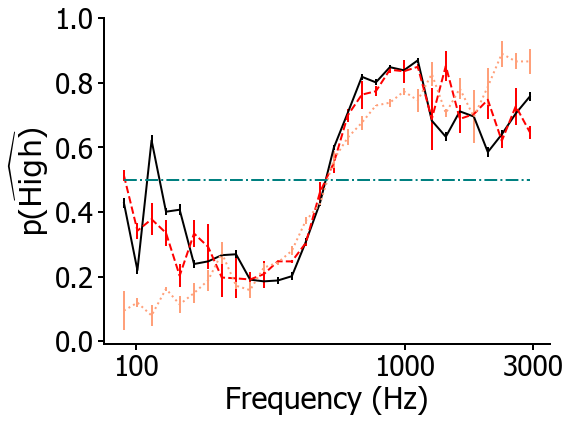

In [8]:
"""
Figure 3D
Qs: How does fitting look like across all subjects in the population in the unbiased experiment?
"""
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(np.log10(unique_tonesPlayed_overall), np.nanmean(averageSubjectBehaviour,axis=0), 
            yerr=np.nanstd(averageSubjectBehaviour,axis=0)/np.sqrt(56),color='k',linewidth=2)

"""
Loading no context parameter data 
"""
averageSubjectParametersProb = np.zeros((8,))
averageSubjectParametersProb[0] = 2.55
averageSubjectParametersProb[1] = 2.85
averageSubjectParametersProb[2] = 0.1
averageSubjectParametersProb[3] = np.nanmean(computedLikelihoodsVeridical['ss'].values)
averageSubjectParametersProb[4] = np.nanmean(computedLikelihoodsVeridical['medianPBack'].values)
averageSubjectParametersProb[5] = np.nanmean(computedLikelihoodsVeridical['plow'].values)
averageSubjectParametersProb[6] = 0
averageSubjectParametersProb[7] = 0

averageSubjectParametersSignal = np.zeros((8,))
averageSubjectParametersSignal[0] = 2.55
averageSubjectParametersSignal[1] = 2.85
averageSubjectParametersSignal[2] = 0.1
averageSubjectParametersSignal[3] = np.nanmean(computedLikelihoodsVeridical['ssSignal'].values)
averageSubjectParametersSignal[4] = 0
averageSubjectParametersSignal[5] = np.nanmean(computedLikelihoodsVeridical['plowSignal'].values)
averageSubjectParametersSignal[6] = 0
averageSubjectParametersSignal[7] = 0

simulatedTrials, simulatedBehaviourProbabilistic = fittingPsychometricCurve(PLowExpt=0.5, 
                                                                           subjectFitParams=averageSubjectParametersProb,
                                                                           ifRandomChoice=0)

plt.errorbar(np.log10(simulatedTrials), 
             np.mean(simulatedBehaviourProbabilistic,axis=1),
             yerr = np.std(simulatedBehaviourProbabilistic,axis=1)/np.sqrt(3),
             color='r',linestyle='--',linewidth=2)

simulatedTrials, simulatedBehaviourSignal = fittingPsychometricCurve(PLowExpt=0.5, 
                                                                    subjectFitParams=averageSubjectParametersSignal,
                                                                    ifRandomChoice=0)

plt.errorbar(np.log10(simulatedTrials), 
             np.mean(simulatedBehaviourSignal,axis=1),
             yerr = np.std(simulatedBehaviourSignal,axis=1)/np.sqrt(3),
             color='lightsalmon',linestyle='dotted',linewidth=2)

simulatedTrials, simulatedBehaviourRandom = fittingPsychometricCurve(PLowExpt=0.5, 
                                                                    subjectFitParams=[0,0,0,
                                                                                      averageSubjectParametersProb[3],0,0.5],
                                                                    ifRandomChoice=1)

plt.errorbar(np.log10(simulatedTrials), 
             np.mean(simulatedBehaviourRandom,axis=1),
             yerr = np.std(simulatedBehaviourRandom,axis=1)/np.sqrt(3),
             color='teal',linestyle='dashdot',linewidth=2)

ax.set_xticks(ticks=np.log10([100,1000,3000]))
ax.set_xticklabels(labels=[100,1000,3000])
ax.set_yticks(ticks=np.arange(0,1.1,0.2))
ax.set_yticklabels(labels=np.around(np.arange(0,1.1,0.2),1))
ax.tick_params(axis='both',labelsize=28,length=6,width=2)
ax.set_xlabel('Frequency (Hz)',fontsize=30)
ax.set_ylabel(r'p($\rm{\widehat{High}}$)',fontsize=30)
makeAxesPretty(ax)
#plt.savefig('figures/FromProlific/illustrations/AverageSubject_pBHgivenT_forNoContext.pdf',
#           bbox_inches='tight',transparent=True)


In [ ]:
"""
Qs: How does fitting look like across all subjects in the biased experiment?
"""
"""
Loading no context parameter data 
"""
mean_lowLC = np.ma.array(computedLikelihoodsLowContext['mean_low'].values,mask=False)
mean_highLC = np.ma.array(computedLikelihoodsLowContext['mean_high'].values,mask=False)
sigmaLC = np.ma.array(computedLikelihoodsLowContext['sigma'].values,mask=False)
ssLC = np.ma.array(computedLikelihoodsLowContext['ss'].values,mask=False)
pbackLC = np.ma.array(computedLikelihoodsLowContext['pback'].values,mask=False)
plowLC = np.ma.array(computedLikelihoodsLowContext['plow'].values,mask=False)
mean_lowHC = np.ma.array(computedLikelihoodsHighContext['mean_low'].values,mask=False)
mean_highHC = np.ma.array(computedLikelihoodsHighContext['mean_high'].values,mask=False)
sigmaHC = np.ma.array(computedLikelihoodsHighContext['sigma'].values,mask=False)
ssHC = np.ma.array(computedLikelihoodsHighContext['ss'].values,mask=False)
pbackHC = np.ma.array(computedLikelihoodsHighContext['pback'].values,mask=False)
plowHC = np.ma.array(computedLikelihoodsHighContext['plow'].values,mask=False)

mean_lowHC.mask[[20,40]] = True
mean_highHC.mask[[20,40]] = True
sigmaHC.mask[[20,40]] = True
ssHC.mask[[20,40]] = True
pbackHC.mask[[20,40]] = True
plowHC.mask[[20,40]] = True
mean_lowLC.mask[[25,45]] = True
mean_highLC.mask[[25,45]] = True
sigmaLC.mask[[25,45]] = True
ssLC.mask[[25,45]] = True
pbackLC.mask[[25,45]] = True
plowLC.mask[[25,45]] = True

averageSubjectParametersProbLC = np.zeros((6,))
averageSubjectParametersProbLC[0] = np.nanmean(mean_lowLC)
averageSubjectParametersProbLC[1] = np.nanmean(mean_highLC)
averageSubjectParametersProbLC[2] = np.nanmean(sigmaLC)
averageSubjectParametersProbLC[3] = np.nanmean(ssLC)
averageSubjectParametersProbLC[4] = np.nanmean(pbackLC)
averageSubjectParametersProbLC[5] = np.nanmean(plowLC)

averageSubjectParametersProbHC = np.zeros((6,))
averageSubjectParametersProbHC[0] = np.nanmean(mean_lowHC)
averageSubjectParametersProbHC[1] = np.nanmean(mean_highHC)
averageSubjectParametersProbHC[2] = np.nanmean(sigmaHC)
averageSubjectParametersProbHC[3] = np.nanmean(ssHC)
averageSubjectParametersProbHC[4] = np.nanmean(pbackHC)
averageSubjectParametersProbHC[5] = np.nanmean(plowHC)

averageSubjectBehaviourLC = np.empty(shape=(53,30))
averageSubjectBehaviourHC = np.empty(shape=(48,30))
numberOfSubsamples=20
Test = pd.read_csv('../auditory_categorization_longLow/important_things_not_included_in_assets/allTrials.csv')
SubjectFiles = os.listdir('subjectDataForPlots/biasedLowContextData')
for subjectIdx in range(53):  
    filename = 'subjectDataForPlots/biasedLowContextData/'+SubjectFiles[subjectIdx]  
    print(filename, subjectIdx)
    Data = pd.read_csv(filename);
    subjectBehaviourLC = np.empty((numberOfSubsamples,30))    
    df_tones, df_toneKind, df_corrans, df_keys = extractData(csv_test=Test, 
                                                             csv_data=Data, 
                                                             exptTotalLength=800,
                                                             exptLengthWithBreaks=804) 

    for iSubsample in range(numberOfSubsamples):
        sampledlc_tones, sampledlc_behaviour = subsampleLongContextLow(toneslc=df_tones, 
                                                                       toneTypeslc=df_toneKind,
                                                                       corranslc=df_corrans, 
                                                                       keyslc=df_keys)        
        unique_tones_played, allPositionssubjectBehaviourLC = plottingInfluenceFn(sampledlc_tones, 
                                                                                  sampledlc_behaviour)  
        subjectBehaviourLC[iSubsample,:] = np.mean(allPositionssubjectBehaviourLC,axis=1)
    averageSubjectBehaviourLC[subjectIdx,:] = np.nanmean(subjectBehaviourLC,axis=0)

    
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(np.log10(unique_tones_played), np.nanmean(averageSubjectBehaviour,axis=0), 
            yerr=np.nanstd(averageSubjectBehaviour,axis=0)/np.sqrt(53),color='k',linewidth=2)

ax.errorbar(np.log10(unique_tones_played), np.nanmean(averageSubjectBehaviourLC,axis=0), 
            yerr=np.nanstd(averageSubjectBehaviourLC,axis=0)/np.sqrt(53),color='orange',linewidth=2)

Test = pd.read_csv('../auditory_categorization_longHigh/important_things_not_included_in_assets/allTrials.csv')
SubjectFiles = os.listdir('subjectDataForPlots/biasedHighContextData')
for subjectIdx in range(48): 
    filename = 'subjectDataForPlots/biasedHighContextData/'+SubjectFiles[subjectIdx] 
    print(filename, subjectIdx)
    Data = pd.read_csv(filename);
    subjectBehaviourHC = np.empty((numberOfSubsamples,30))
    df_tones, df_toneKind, df_corrans, df_keys = extractData(csv_test=Test, 
                                                             csv_data=Data, 
                                                             exptTotalLength=800,
                                                             exptLengthWithBreaks=804) 

    for iSubsample in range(numberOfSubsamples):
        sampledhc_tones, sampledhc_behaviour = subsampleLongContextHigh(toneshc=df_tones, 
                                                                       toneTypeshc=df_toneKind,
                                                                       corranshc=df_corrans, 
                                                                       keyshc=df_keys)        
        unique_tones_played, allPositionssubjectBehaviourHC = plottingInfluenceFn(sampledhc_tones, 
                                                                                  sampledhc_behaviour)  
        subjectBehaviourHC[iSubsample,:] = np.mean(allPositionssubjectBehaviourHC,axis=1)
    averageSubjectBehaviourHC[subjectIdx,:] = np.nanmean(subjectBehaviourHC,axis=0)
    
ax.errorbar(np.log10(unique_tones_played), np.nanmean(averageSubjectBehaviourHC,axis=0), 
            yerr=np.nanstd(averageSubjectBehaviourHC,axis=0)/np.sqrt(48),color='brown',linewidth=2)

ax.set_xticks(ticks=np.log10([100,1000,3000]))
ax.set_xticklabels(labels=[100,1000,3000])
ax.set_yticks(ticks=np.arange(0,1.1,0.2))
ax.set_yticklabels(labels=np.around(np.arange(0,1.1,0.2),1))
ax.tick_params(axis='both',labelsize=30,length=6,width=2)
ax.set_xlabel('Frequency (Hz)',fontsize=32)
ax.set_ylabel(r'p($\rm{\widehat{High}}$)',fontsize=32)
makeAxesPretty(ax)

#plt.savefig('figures/FromProlific/illustrations/AverageSubject_pBHgivenT_acrossAllSessions.pdf',
#           bbox_inches='tight',transparent=True)

longTermLearning_dict = {"behaviourSubsampledHC": averageSubjectBehaviourHC,
                          "behaviourSubsampledLC": averageSubjectBehaviourLC,
                          "behaviourSubsampledNC": averageSubjectBehaviour}

scipy.io.savemat("longTermLearning_behaviour.mat", longTermLearning_dict)


In [ ]:
"""
Figs. 1, 3A and 4D
Qs: Experiment design and cartoon of psychometric curves
"""

fig, ax1 = plt.subplots(1,1, figsize=(15,6))
cntSeq = 1
cntSeqArray = []
for sequence in range(5,13):
    ax1.plot([cntSeq-1,cntSeq,cntSeq+1],np.log10(df_tones[sequence]),'.',markersize=3)
    cntSeqArray += [cntSeq]
    cntSeq += 8    
ax1.set_xticks(ticks=cntSeqArray);
ax1.set_xticklabels(labels=range(1,9),fontsize=33);
ax1.set_yticks(ticks=np.log10([100,500,1000,1500,3000]));
ax1.set_yticklabels(labels=[100,500,1000,1500,3000],fontsize=33);
ax1.tick_params(axis='both',length=6,width=2)
makeAxesPretty(ax1)
ax1.set_xlabel('Trial number',fontsize=35)
ax1.set_ylabel('$\it{Unbiased}$ $\it{Session}$ \n Frequency (Hz)',fontsize=35)
#plt.savefig('figures/FromProlific/illustrations/NoContextCompressed_trialsHeardBySubjectb52f.pdf', 
#            bbox_inches='tight',transparent=True)

fig, ax1 = plt.subplots(1,1, figsize=(15,1))
cntSeq = 1
cntSeqArray = []
for sequence in range(5,13):
    ax1.plot([cntSeq-1,cntSeq,cntSeq+1],[1,1,1],'.',markersize=3)
    cntSeqArray += [cntSeq]
    cntSeq += 8    
ax1.set_xticks(ticks=cntSeqArray);
ax1.set_xticklabels(labels=range(1,9),fontsize=33);
ax1.set_yticks(ticks=[]);
ax1.tick_params(axis='both',length=6,width=2)
makeAxesPretty(ax1)
print(df_toneKind[5:13,:],df_corrans[5:13])
#plt.savefig('figures/FromProlific/illustrations/NoContextCompressed_trialsHeardBySubjectb52f.pdf', 
#             bbox_inches='tight',transparent=True)

fig, ax2 = plt.subplots(1,1, figsize=(15,1))
cntSeq = 1
cntSeqArray = []
for sequence in range(5,13):
    ax2.plot([cntSeq-1,cntSeq,cntSeq+1],[1,1,1],'.',markersize=3)
    cntSeqArray += [cntSeq]
    cntSeq += 8
ax2.set_xticks(ticks=cntSeqArray)
ax2.set_xticklabels(labels=range(1,9),fontsize=33)
ax2.set_yticks(ticks=[])
ax2.tick_params(axis='both',length=6,width=2)
makeAxesPretty(ax2)
print(df_toneKindlc[5:13,:], df_corranslc[5:13])
#plt.savefig('figures/FromProlific/illustrations/LowContextCompressed_trialsHeardBySubjectb52f.pdf',
#            bbox_inches='tight',transparent=True)

fig, ax3 = plt.subplots(1,1, figsize=(15,1))
cntSeq = 1
cntSeqArray = []
for sequence in range(5,13):
    ax3.plot([cntSeq-1,cntSeq,cntSeq+1],[1,1,1],'.',markersize=5)
    cntSeqArray += [cntSeq]
    cntSeq += 8   
ax3.set_xticks(ticks=cntSeqArray);
ax3.set_xticklabels(labels=range(1,9),fontsize=33)
ax3.set_yticks(ticks=[])
makeAxesPretty(ax3)
ax3.tick_params(axis='both',length=6,width=2)
ax3.set_xlabel('Trial number',fontsize=35)
print(df_toneKindhc[5:13,:], df_corranshc[5:13])
#plt.savefig('figures/FromProlific/illustrations/HighContextCompressed_trialsHeardBySubjectb52f.pdf', 
#            bbox_inches='tight',transparent=True)

def psychometricCurve(tones, category):
    unique_tones = np.unique(tones)
    probabilityArray = np.zeros(len(unique_tones))
    for toneIdx in range(len(unique_tones)):
        probabilityArray[toneIdx] = np.mean(category[tones==unique_tones[toneIdx]])
    return unique_tones, probabilityArray

makeSchematicOfPsychometricCurve = 1
if makeSchematicOfPsychometricCurve:
    trial_list, dist_list, tone_kind_list = task(n_trials = 5000000, n_tones = 1, 
                                                                      p_low=0.5, p_back=0.3)
    [uniqueTones, probCategories] = psychometricCurve(trial_list, dist_list)
    tone_category_Spline = make_interp_spline(np.log10(uniqueTones), probCategories)
    tones_ = np.linspace(np.log10(uniqueTones).min(), np.log10(uniqueTones).max(), 50)
    category_ = tone_category_Spline(tones_)
    # Plotting the Graph
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    ax.plot(tones_, category_, 'black', linewidth=2)
    ax.set_xticks([])
    ax.set_yticks(ticks=[0,0.5,1])
    ax.set_yticklabels([0,0.5,1.0],fontsize=42)
    makeAxesPretty(ax)
    ax.set_xlabel('Frequency (Hz)',fontsize=45)
    ax.set_ylabel('p(High)',fontsize=45)
    plt.savefig('figures/FromProlific/illustrations/psychometricCurve_oneTone_allDistributions.pdf', 
                bbox_inches='tight',transparent=True)

Correlation of low category accuracy with number of distractors           n    r         CI95%  p-val  power
spearman  4 -1.0  [-1.0, -1.0]    0.0      1
Correlation of high category accuracy with number of distractors           n    r         CI95%  p-val  power
spearman  4 -1.0  [-1.0, -1.0]    0.0      1
Correlation of both categories accuracy with number of distractors           n    r         CI95%  p-val  power
spearman  4 -1.0  [-1.0, -1.0]    0.0      1
Correlation of low category accuracy with distractor frequency            n         r           CI95%     p-val     power
spearman  15 -0.810714  [-0.93, -0.51]  0.000246  0.979505
Correlation of high category accuracy with distractor frequency            n         r         CI95%     p-val     power
spearman  15  0.867857  [0.64, 0.96]  0.000028  0.996804
Comparing central frequency using wilcoxon           W-val alternative     p-val       RBC      CLES
Wilcoxon  404.5   two-sided  0.057919  0.312075  0.626913
Comparing one fr

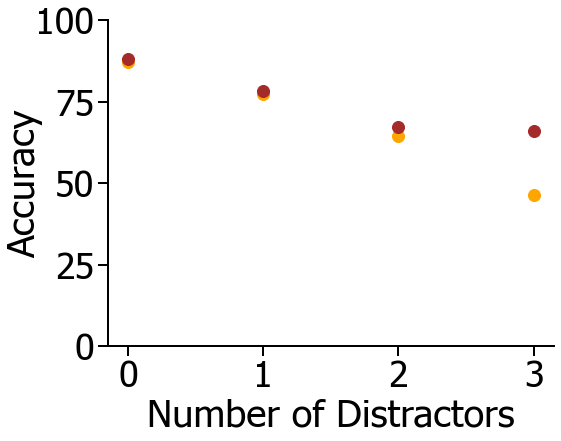

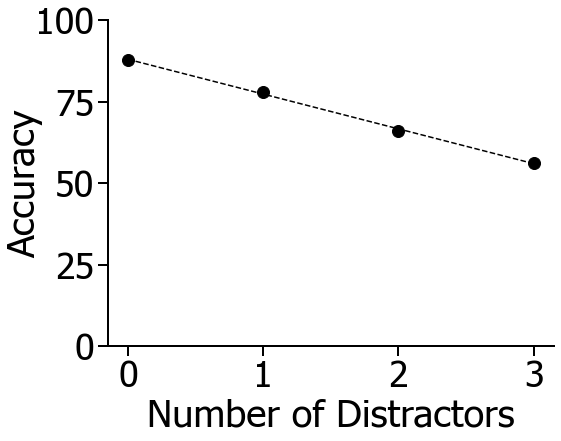

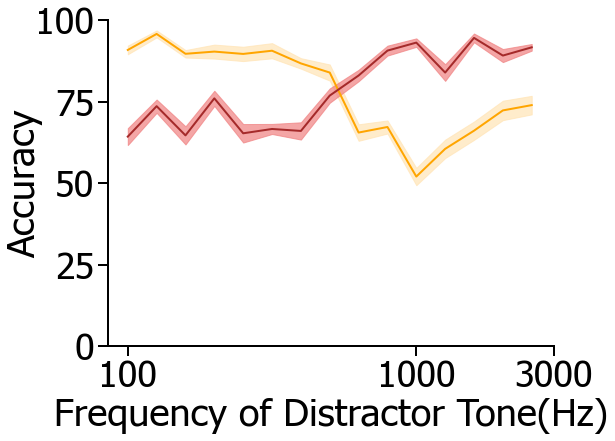

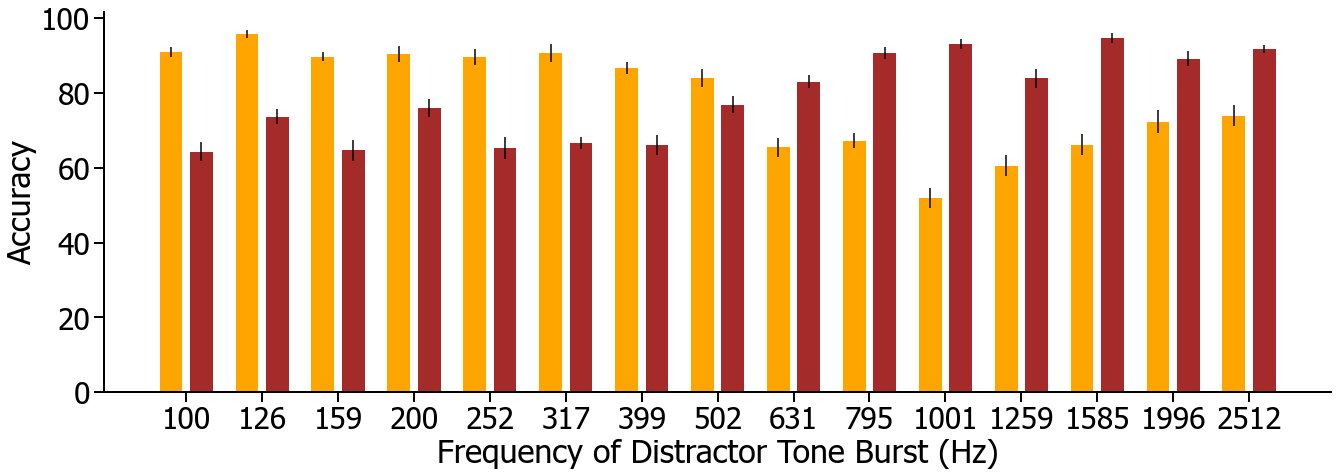

In [9]:
"""
Qs: Figs. 2E,G, extended Fig. 1H - how does performance vary with number and frequency of distractors?
"""
meanPerformance_lowCategory = np.array([87.09,77.38,64.61,46.53])
stdPerformance_lowCategory = np.array([9.11,9.65,8,12.9])
meanPerformance_highCategory = np.array([87.96,78.18,67.29,65.95])
stdPerformance_highCategory = np.array([6.48,7.93,5.87,15.32])
meanPerformance_bothCategories = np.array([87.75,78.06,65.98,56.22])
stdPerformance_bothCategories = np.array([6.78,7.77,4.43,9.53])

fig1, ax1 = plt.subplots(1,1, figsize=(8,6))
fig2, ax2 = plt.subplots(1,1, figsize=(8,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
ax1.errorbar(np.arange(4),meanPerformance_lowCategory,
             yerr=stdPerformance_lowCategory/np.sqrt(56),
             color='orange',linestyle="None",marker='o',markersize=12)
ax1.errorbar(np.arange(4),meanPerformance_highCategory,
             yerr=stdPerformance_highCategory/np.sqrt(56),
             color='brown',linestyle="None",marker='o',markersize=12)
ax2.errorbar(np.arange(4),meanPerformance_bothCategories,
             yerr=stdPerformance_bothCategories/np.sqrt(56),
             color='black',linestyle="None",marker='o',markersize=12)

reg = LinearRegression().fit(np.reshape(np.arange(4),(-1,1)),meanPerformance_bothCategories)
ax2.plot(np.arange(4), reg.predict(np.reshape(np.arange(4),(-1,1))), 'k--')

for ax in [ax1,ax2]:
    ax.set_xlabel('Number of Distractors',fontsize=38)
    ax.set_ylabel('Accuracy',fontsize=38)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['0','1','2','3'])
    ax.set_ylim(0,100)
    ax.yaxis.labelpad = -8
    ax.tick_params(axis='both',labelsize=36,length=10,width=2)
    makeAxesPretty(ax)

#fig1.savefig('figures/FromProlific/illustrations/PerformanceAccuracyInThePresenceOfDistractors_categoryDependence.pdf',
#            bbox_inches='tight',transparent=True)
#fig2.savefig('figures/FromProlific/illustrations/PerformanceAccuracyInThePresenceOfDistractors_bothCategories.pdf',
#            bbox_inches='tight',transparent=True)

import pickle
with open('subjectDataForPlots/PerformanceAccuracyChangesWithFrequencyOfDistractor.pickle', 'rb') as handle:
    dict_behaviour = pickle.load(handle)
unique_distractors_low = dict_behaviour['unique_distractors_low']
averageBehaviorAcrossSubjects_low = dict_behaviour['averageBehaviorAcrossSubjects_low']
unique_distractors_high = dict_behaviour['unique_distractors_high']
averageBehaviorAcrossSubjects_high = dict_behaviour['averageBehaviorAcrossSubjects_high']
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(unique_distractors_low, 
         np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1),
         color='orange',linewidth=2)
ax.plot(unique_distractors_high, 
         np.mean(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1),
         color='brown',linewidth=2)
ax.fill_between(unique_distractors_low, 
                 y1 = np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1) - np.std(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1)/np.sqrt(56),
                 y2 = np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1) + np.std(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1)/np.sqrt(56),
                 color='moccasin',alpha=0.7)
ax.fill_between(unique_distractors_high, 
                 y1 = np.mean(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1) - np.std(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1)/np.sqrt(56),
                 y2 = np.mean(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1) + np.std(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1)/np.sqrt(56),
                 color='lightcoral',alpha=0.7)
ax.set_xticks(np.array([np.log10(100),np.log10(1000),np.log10(3000)]))
ax.set_xticklabels([100,1000,3000])
ax.set_ylim(0,100)
ax.set_xlabel('Frequency of Distractor Tone(Hz)',fontsize=38)
ax.set_ylabel('Accuracy',fontsize=38)
ax.yaxis.labelpad = -8
ax.tick_params(axis='both',labelsize=36,length=10,width=2)
makeAxesPretty(ax)
#plt.savefig('figures/FromProlific/illustrations/PerformanceAccuracyInThePresenceOfDistractors_partII.pdf',
#            bbox_inches='tight',transparent=True)

fig, ax = plt.subplots(1,1, figsize=(22,7))
ax.bar(unique_distractors_low-0.02,np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1),
       width=0.03,yerr=np.std(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1)/np.sqrt(56),color='orange')
ax.bar(unique_distractors_high+0.02,np.mean(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1),
       width=0.03,yerr=np.std(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1)/np.sqrt(56),color='brown')
ax.set_xticks(np.arange(2,3.5,0.1))
ax.set_xticklabels(np.ceil(10**np.arange(2,3.5,0.1)).astype(int))
ax.set_xlabel('Frequency of Distractor Tone Burst (Hz)',fontsize=32)
ax.set_ylabel('Accuracy',fontsize=32)
ax.tick_params(axis='both',labelsize=30,length=10,width=2)
makeAxesPretty(ax)


print("Correlation of low category accuracy with number of distractors", pg.corr(np.arange(4),
                                                                                meanPerformance_lowCategory,
                                                                                method = 'spearman'))
print("Correlation of high category accuracy with number of distractors", pg.corr(np.arange(4),
                                                                                meanPerformance_highCategory,
                                                                                method = 'spearman'))
print("Correlation of both categories accuracy with number of distractors", pg.corr(np.arange(4),
                                                                                    meanPerformance_bothCategories,
                                                                                    method = 'spearman'))
print("Correlation of low category accuracy with distractor frequency", pg.corr(unique_distractors_low,
                                                                                np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1),
                                                                                method = 'spearman'))
print("Correlation of high category accuracy with distractor frequency", pg.corr(unique_distractors_high,
                                                                                np.mean(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1),
                                                                                method = 'spearman'))

print("Comparing central frequency using wilcoxon", pg.wilcoxon(averageBehaviorAcrossSubjects_low[8],
                                                                averageBehaviorAcrossSubjects_high[8]))
print("Comparing one frequency before center using wilcoxon", pg.wilcoxon(averageBehaviorAcrossSubjects_low[7],
                                                                          averageBehaviorAcrossSubjects_high[7]))
print("Comparing one frequency after center using wilcoxon", pg.wilcoxon(averageBehaviorAcrossSubjects_low[9],
                                                                         averageBehaviorAcrossSubjects_high[9]))
print("Comparing two frequencies before center using wilcoxon", pg.wilcoxon(averageBehaviorAcrossSubjects_low[6],
                                                                            averageBehaviorAcrossSubjects_high[6]))
print("Comparing two frequencies after center using wilcoxon", pg.wilcoxon(averageBehaviorAcrossSubjects_low[10],
                                                                           averageBehaviorAcrossSubjects_high[10]))
print("Median and iqr of central frequency accuracies", "low",
      np.median(averageBehaviorAcrossSubjects_low[10]),scipy.stats.iqr(averageBehaviorAcrossSubjects_low[10]),
      "high", np.median(averageBehaviorAcrossSubjects_high[10]),scipy.stats.iqr(averageBehaviorAcrossSubjects_high[10]))
print("Average accuracy for first 7 distractor tone frequencies", 
      np.nanmean(np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1)[:8]),
      np.nanstd(np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1)[:8])/np.sqrt(7))
print("Average accuracy for last 7 distractor tone frequencies", 
      np.nanmean(np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1)[9:]),
      np.nanstd(np.mean(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1)[9:])/np.sqrt(7))
print("Median Accuracy for low category trials",np.median(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1))
print("Median Accuracy for high category trials",np.median(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1))
print("IQR Accuracy for low category trials",scipy.stats.iqr(np.array(averageBehaviorAcrossSubjects_low)*100,axis=1))
print("IQR Accuracy for high category trials",scipy.stats.iqr(np.array(averageBehaviorAcrossSubjects_high)*100,axis=1))


0.185 0.14 0.28500000000000003 3 [29 34 35]
Median and IQR of one distractor tone trial accuracy 79.455 11.257500000000007
Median and IQR of two distractor tones trial accuracy 66.235 6.032499999999999


/Users/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


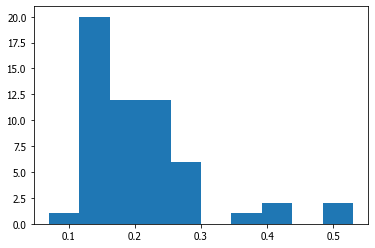

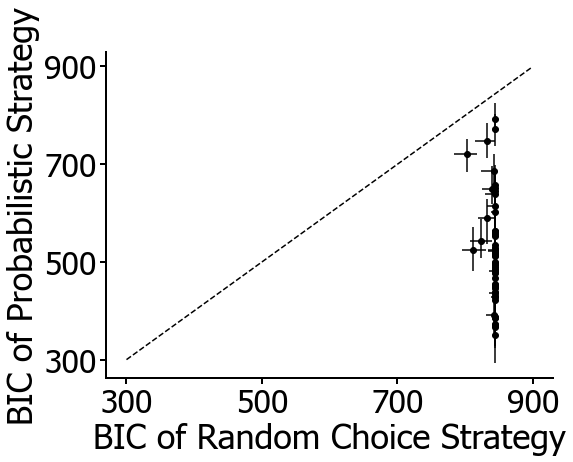

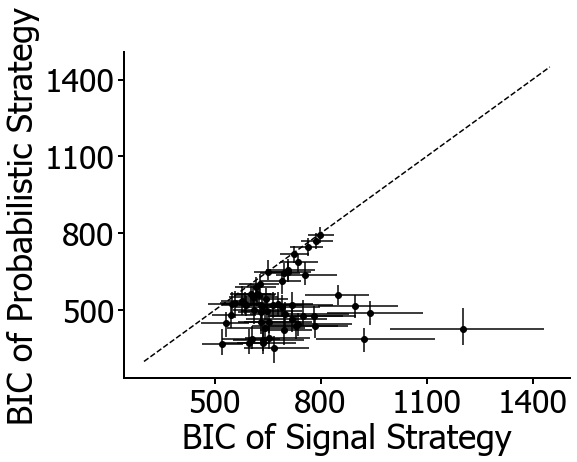

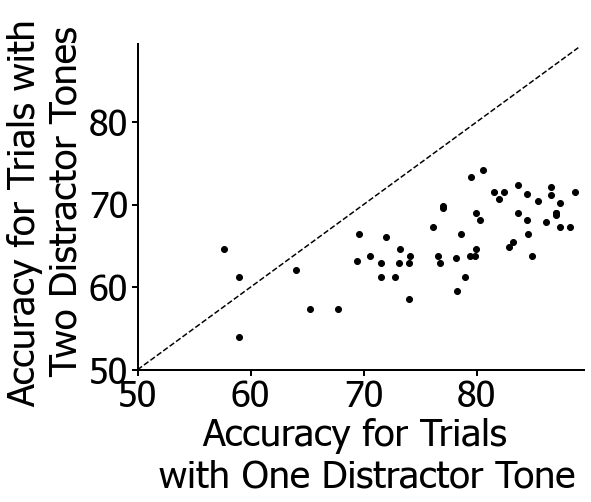

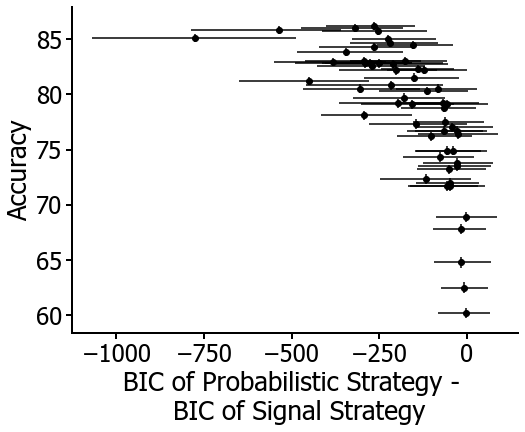

In [10]:
"""
Qs: Range of sigma sensory across the subject population. 
"""
indices = np.arange(56)
sigmaSensory = computedLikelihoods['ss'].values
sigmaSensory = sigmaSensory[~np.isnan(sigmaSensory)]
plt.hist(sigmaSensory)
print(np.quantile(sigmaSensory, 0.5), np.quantile(sigmaSensory, 0.1), np.quantile(sigmaSensory, 0.90), 
      sum(sigmaSensory>np.quantile(sigmaSensory, 0.95)),indices[sigmaSensory>np.quantile(sigmaSensory, 0.95)])

"""
Qs: Can we split participants up into two categories as a first pass? And then everybody else goes on a continuum.
"""

"""
The following variables are for bic values of the subsampled dataset.
"""
nll_median_probModel = computedLikelihoods['medianProb'].values
nll_median_probModel = nll_median_probModel[~np.isnan(nll_median_probModel)]

nll_median_signalModel = computedLikelihoods['medianSignal'].values
nll_median_signalModel = nll_median_signalModel[~np.isnan(nll_median_signalModel)]

nll_median_randomModel = computedLikelihoods['medianRandom'].values
nll_median_randomModel = nll_median_randomModel[~np.isnan(nll_median_randomModel)]

nll_lowerErrorbars_probModel = computedLikelihoods['5thPercentileProb'].values
nll_lowerErrorbars_probModel = nll_lowerErrorbars_probModel[~np.isnan(nll_lowerErrorbars_probModel)]

nll_upperErrorbars_probModel = computedLikelihoods['95thPercentileProb'].values
nll_upperErrorbars_probModel = nll_upperErrorbars_probModel[~np.isnan(nll_upperErrorbars_probModel)]

nll_lowerErrorbars_signalModel = computedLikelihoods['5thPercentileSignal'].values
nll_lowerErrorbars_signalModel = nll_lowerErrorbars_signalModel[~np.isnan(nll_lowerErrorbars_signalModel)]

nll_upperErrorbars_signalModel = computedLikelihoods['95thPercentileSignal'].values
nll_upperErrorbars_signalModel = nll_upperErrorbars_signalModel[~np.isnan(nll_upperErrorbars_signalModel)]

nll_lowerErrorbars_randomModel = computedLikelihoods['5thPercentileRandom'].values
nll_lowerErrorbars_randomModel = nll_lowerErrorbars_randomModel[~np.isnan(nll_lowerErrorbars_randomModel)]

nll_upperErrorbars_randomModel = computedLikelihoods['95thPercentileRandom'].values
nll_upperErrorbars_randomModel = nll_upperErrorbars_randomModel[~np.isnan(nll_upperErrorbars_randomModel)]

"""
Fig. 2F
Qs: Where do subjects lie in the one irrelevant tone and two irrelevant tones space?
"""
performance = pd.read_excel(xls,'Strategy_PerformanceAccuracies',nrows = 57)
numberOfNoResponses = performance['NumberOfNoResponsesNoContext'].values
numberOfNoResponses = numberOfNoResponses[~np.isnan(numberOfNoResponses)]
distractorPerformance = pd.read_excel(xls,'PerformanceVsNumDistractors',nrows=56)
OverallAccuracy = performance['OverallAccuracyNoContext'].values
OverallAccuracy = OverallAccuracy[~np.isnan(OverallAccuracy)]
OneIrrelevantToneAccuracy = np.ma.array(distractorPerformance['CombinedAcrossCategoriesOneDistractor'].values,mask=False)
TwoIrrelevantTonesAccuracy = np.ma.array(distractorPerformance['CombinedAcrossCategoriesTwoDistractors'].values,mask=False)

fig0, ax0 = plt.subplots(1,1,figsize=(8,6))
fig1, ax1 = plt.subplots(1,1,figsize=(8,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None)
for i in range(len(nll_median_probModel)):
    ax0.errorbar(2*nll_median_randomModel[i]+2*np.log(600),
                 2*nll_median_probModel[i]+6*np.log(600), 
                 xerr=[[-2*nll_lowerErrorbars_randomModel[i]+2*nll_median_randomModel[i]],
                      [2*nll_upperErrorbars_randomModel[i]-2*nll_median_randomModel[i]]],
                 yerr=[[-2*nll_lowerErrorbars_probModel[i]+2*nll_median_probModel[i]],
                      [2*nll_upperErrorbars_probModel[i]-2*nll_median_probModel[i]]],
                 color='k',marker='o')
    ax1.errorbar(2*nll_median_signalModel[i]+5*np.log(600),
                 2*nll_median_probModel[i]+6*np.log(600), 
                 xerr=[[-2*nll_lowerErrorbars_signalModel[i]+2*nll_median_signalModel[i]],
                      [2*nll_upperErrorbars_signalModel[i]-2*nll_median_signalModel[i]]],
                 yerr=[[-2*nll_lowerErrorbars_probModel[i]+2*nll_median_probModel[i]],
                      [2*nll_upperErrorbars_probModel[i]-2*nll_median_probModel[i]]],
                 color='k',marker='o')
    
ax0.plot(np.arange(300,900),np.arange(300,900),'k--')
ax0.set_xticks([300,500,700,900]); ax0.set_yticks([300,500,700,900])
ax1.plot(np.arange(300,1450),np.arange(300,1450),'k--')
ax1.set_xticks([500,800,1100,1400]); ax1.set_yticks([500,800,1100,1400])

ax0.set_xlabel('BIC of Random Choice Strategy', fontsize=34)
ax1.set_xlabel('BIC of Signal Strategy', fontsize=34)
for ax in [ax0,ax1]:
    ax.set_ylabel('BIC of Probabilistic Strategy',fontsize=34)
    ax.tick_params(axis='both',labelsize=32,length=6,width=2)
    makeAxesPretty(ax)
    
fig2, ax2 = plt.subplots(1,1,figsize=(8,6)) 
fig3, ax3 = plt.subplots(1,1,figsize=(8,6)) 
ax2.plot(OneIrrelevantToneAccuracy,TwoIrrelevantTonesAccuracy,'ko')
ax2.set_xlim([50,89.5])
ax2.set_ylim([50,89.5])
ax2.plot(np.arange(50,89.5),np.arange(50,89.5),'k--')
ax2.set_xlabel('Accuracy for Trials \n with One Distractor Tone',fontsize=38)
ax2.set_ylabel('Accuracy for Trials with \n Two Distractor Tones',fontsize=38)
ax2.tick_params(axis='both',labelsize=36,length=6,width=2)
makeAxesPretty(ax2)

#fig2.savefig('figures/FromProlific/illustrations/variabilityInAccuracy.pdf',
#            bbox_inches="tight",transparent=True)

for i in range(len(nll_median_probModel)):      
    ax3.errorbar(-2*nll_median_signalModel[i]-5*np.log(600)
                 +2*nll_median_probModel[i]+6*np.log(600), 
                 OverallAccuracy[i],
                 xerr=[[2*nll_upperErrorbars_signalModel[i]-2*nll_lowerErrorbars_probModel[i]
                       -2*nll_median_signalModel[i]+2*nll_median_probModel[i]],
                       [-2*nll_lowerErrorbars_signalModel[i]+2*nll_upperErrorbars_probModel[i]
                       +2*nll_median_signalModel[i]-2*nll_median_probModel[i]]],
                 yerr = [np.sqrt((600-numberOfNoResponses[i])*OverallAccuracy[i]/100*(1-OverallAccuracy[i]/100))
                        /np.sqrt(600-numberOfNoResponses[i])],
                 color='k',marker='o',ecolor='k')

ax3.set_xlabel('BIC of Probabilistic Strategy - \n BIC of Signal Strategy', fontsize=26)
ax3.set_ylabel('Accuracy',fontsize=26)
ax3.tick_params(axis='both',labelsize=24,length=6,width=2)
makeAxesPretty(ax3)

OneIrrelevantToneAccuracy.mask[[29,34]]=True
TwoIrrelevantTonesAccuracy.mask[[29,34]]=True
print("Median and IQR of one distractor tone trial accuracy",np.median(OneIrrelevantToneAccuracy),
     scipy.stats.iqr(OneIrrelevantToneAccuracy))
print("Median and IQR of two distractor tones trial accuracy",np.median(TwoIrrelevantTonesAccuracy),
     scipy.stats.iqr(TwoIrrelevantTonesAccuracy))



Average difference in nll  5.775178571428571 38.630000000000024 -4.460000000000008
Median and IQR of random model BICs 844.5738593104322 0.0
Median and IQR of signal model veridical BICs 659.6638593104323 117.39499999999987
Median and IQR of probabilistic model veridical BICs 502.4107889656484 127.22500000000002
Median and IQR of signal model BICs 660.1346482760807 110.9899999999999
Median and IQR of probabilistic model BICs 514.9915779312969 115.13
Comparing random and probabilistic model BICs using wilcoxon           W-val alternative         p-val  RBC  CLES
Wilcoxon    0.0   two-sided  7.755146e-11  1.0   1.0
Comparing signal and probabilistic model BICs using wilcoxon           W-val alternative         p-val       RBC      CLES
Wilcoxon    2.0   two-sided  8.643052e-11  0.997494  0.875638
Comparing probabilistic model veridical and otherwise BICs using wilcoxon           W-val alternative         p-val       RBC      CLES
Wilcoxon   11.0   two-sided  1.403182e-10 -0.986216  0.458

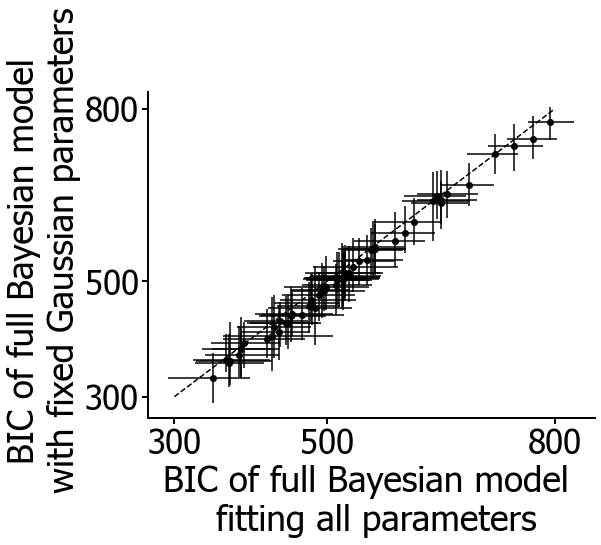

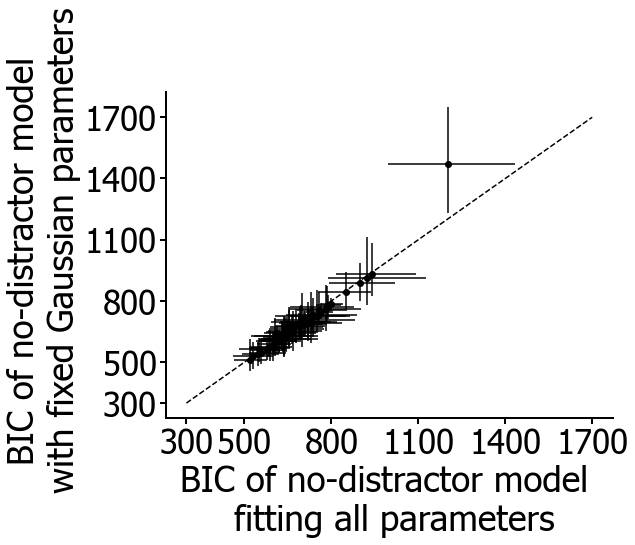

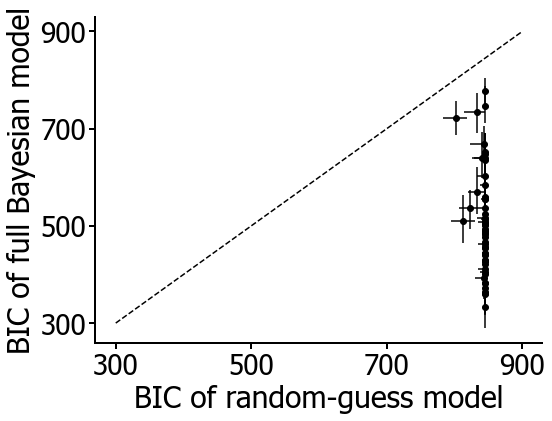

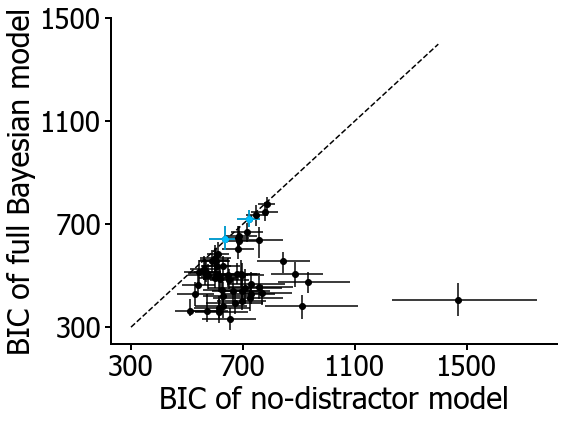

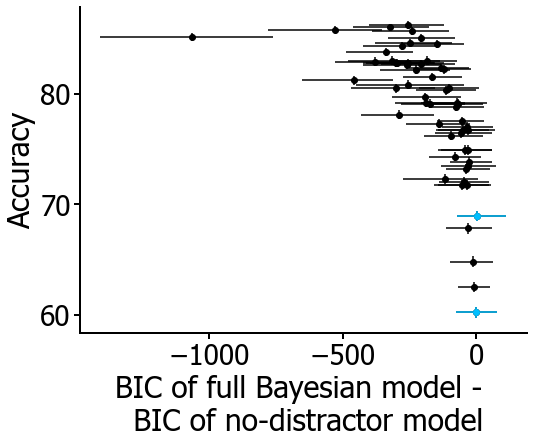

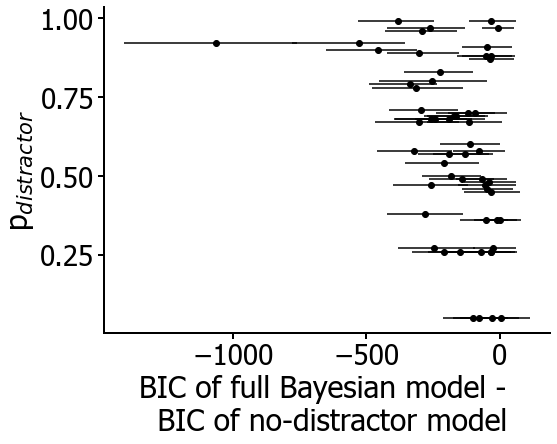

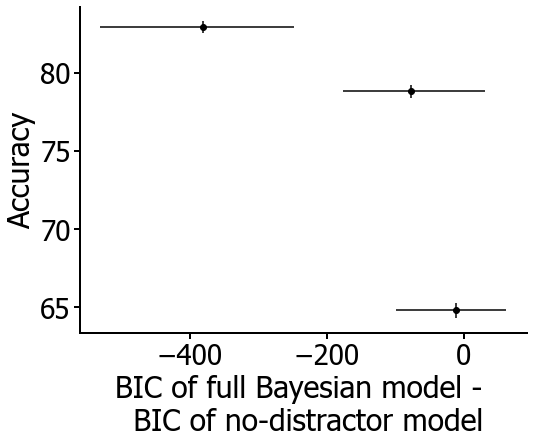

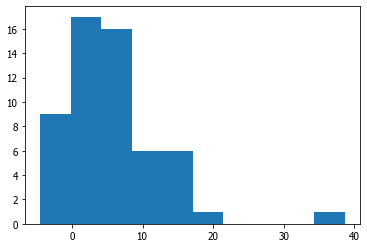

In [13]:
"""
Figs. 4A-C, extended data Figs. 4F,G: comparison of models
"""
nll_median_probModelVeridical = computedLikelihoodsVeridical['medianProb'].values
nll_median_probModelVeridical = nll_median_probModelVeridical[~np.isnan(nll_median_probModelVeridical)]

nll_lowerErrorbars_probModelVeridical = computedLikelihoodsVeridical['5thPercentileProb'].values
nll_lowerErrorbars_probModelVeridical = nll_lowerErrorbars_probModelVeridical[~np.isnan(nll_lowerErrorbars_probModelVeridical)]

nll_upperErrorbars_probModelVeridical = computedLikelihoodsVeridical['95thPercentileProb'].values
nll_upperErrorbars_probModelVeridical = nll_upperErrorbars_probModelVeridical[~np.isnan(nll_upperErrorbars_probModelVeridical)]

nll_median_signalModelVeridical = computedLikelihoodsVeridical['medianSignal'].values
nll_median_signalModelVeridical = nll_median_signalModelVeridical[~np.isnan(nll_median_signalModelVeridical)]

nll_lowerErrorbars_signalModelVeridical = computedLikelihoodsVeridical['5thPercentileSignal'].values
nll_lowerErrorbars_signalModelVeridical = nll_lowerErrorbars_signalModelVeridical[~np.isnan(nll_lowerErrorbars_signalModelVeridical)]

nll_upperErrorbars_signalModelVeridical = computedLikelihoodsVeridical['95thPercentileSignal'].values
nll_upperErrorbars_signalModelVeridical = nll_upperErrorbars_signalModelVeridical[~np.isnan(nll_upperErrorbars_signalModelVeridical)]

nll_median_probModelPBackVeridical = computedLikelihoodsVeridical['medianProbPBackVeridical'].values
nll_median_probModelPBackVeridical = nll_median_probModelPBackVeridical[~np.isnan(nll_median_probModelPBackVeridical)]

nll_lowerErrorbars_probModelPBackVeridical = computedLikelihoodsVeridical['5thPercentileProbPBackVeridical'].values
nll_lowerErrorbars_probModelPBackVeridical = nll_lowerErrorbars_probModelPBackVeridical[~np.isnan(nll_lowerErrorbars_probModelPBackVeridical)]

nll_upperErrorbars_probModelPBackVeridical = computedLikelihoodsVeridical['95thPercentileProbPBackveridical'].values
nll_upperErrorbars_probModelPBackVeridical = nll_upperErrorbars_probModelPBackVeridical[~np.isnan(nll_upperErrorbars_probModelPBackVeridical)]

pback_median_Veridical = computedLikelihoodsVeridical['medianPBack'].values
pback_median_Veridical = pback_median_Veridical[~np.isnan(pback_median_Veridical)]

pback_lowerErrorbars_Veridical = computedLikelihoodsVeridical['5thPercentilePBack'].values
pback_lowerErrorbars_Veridical = pback_lowerErrorbars_Veridical[~np.isnan(pback_lowerErrorbars_Veridical)]

pback_upperErrorbars_Veridical = computedLikelihoodsVeridical['95thPercentilePBack'].values
pback_upperErrorbars_Veridical = pback_upperErrorbars_Veridical[~np.isnan(pback_upperErrorbars_Veridical)]

ss_median_Veridical = computedLikelihoodsVeridical['ss'].values
ss_median_Veridical = ss_median_Veridical[~np.isnan(ss_median_Veridical)]

sigmoidicity_median_Veridical = computedLikelihoodsVeridical['medianRelevanceMetric'].values
sigmoidicity_median_Veridical = sigmoidicity_median_Veridical[~np.isnan(sigmoidicity_median_Veridical)]

sigmoidicity_lowerErrorbars_Veridical = computedLikelihoodsVeridical['5thPercentileRelevanceMetric'].values
sigmoidicity_lowerErrorbars_Veridical = sigmoidicity_lowerErrorbars_Veridical[~np.isnan(sigmoidicity_lowerErrorbars_Veridical)]

sigmoidicity_upperErrorbars_Veridical = computedLikelihoodsVeridical['95thPercentileRelevanceMetric'].values
sigmoidicity_upperErrorbars_Veridical = sigmoidicity_upperErrorbars_Veridical[~np.isnan(sigmoidicity_upperErrorbars_Veridical)]

fig0, ax0 = plt.subplots(1,1,figsize=(8,6)) 
fig1, ax1 = plt.subplots(1,1,figsize=(8,6))
fig2, ax2 = plt.subplots(1,1,figsize=(8,6))
fig3, ax3 = plt.subplots(1,1,figsize=(8,6))
fig4, ax4 = plt.subplots(1,1,figsize=(8,6))
fig5, ax5 = plt.subplots(1,1,figsize=(8,6))
fig6, ax6 = plt.subplots(1,1,figsize=(8,6))
for i in range(len(nll_median_probModelVeridical)):
    ax0.errorbar(2*nll_median_probModel[i]+6*np.log(600),
                 2*nll_median_probModelVeridical[i]+3*np.log(600), 
                 xerr=[[-2*nll_lowerErrorbars_probModel[i]+2*nll_median_probModel[i]],
                      [2*nll_upperErrorbars_probModel[i]-2*nll_median_probModel[i]]],
                 yerr=[[-2*nll_lowerErrorbars_probModelVeridical[i]+2*nll_median_probModelVeridical[i]],
                      [2*nll_upperErrorbars_probModelVeridical[i]-2*nll_median_probModelVeridical[i]]],
                 color='k',marker='o')
    ax1.errorbar(2*nll_median_signalModel[i]+5*np.log(600),
                 2*nll_median_signalModelVeridical[i]+2*np.log(600), 
                 xerr=[[-2*nll_lowerErrorbars_signalModel[i]+2*nll_median_signalModel[i]],
                      [2*nll_upperErrorbars_signalModel[i]-2*nll_median_signalModel[i]]],
                 yerr=[[-2*nll_lowerErrorbars_signalModelVeridical[i]+2*nll_median_signalModelVeridical[i]],
                      [2*nll_upperErrorbars_signalModelVeridical[i]-2*nll_median_signalModelVeridical[i]]],
                 color='k',marker='o')
    ax2.errorbar(2*nll_median_randomModel[i]+2*np.log(600),
                 2*nll_median_probModelVeridical[i]+3*np.log(600), 
                 xerr=[[-2*nll_lowerErrorbars_randomModel[i]+2*nll_median_randomModel[i]],
                      [2*nll_upperErrorbars_randomModel[i]-2*nll_median_randomModel[i]]],
                 yerr=[[-2*nll_lowerErrorbars_probModelVeridical[i]+2*nll_median_probModelVeridical[i]],
                      [2*nll_upperErrorbars_probModelVeridical[i]-2*nll_median_probModelVeridical[i]]],
                 color='k',marker='o')
    ax3.errorbar(2*nll_median_signalModelVeridical[i]+2*np.log(600),
                 2*nll_median_probModelVeridical[i]+3*np.log(600), 
                 xerr=[[-2*nll_lowerErrorbars_signalModelVeridical[i]+2*nll_median_signalModelVeridical[i]],
                      [2*nll_upperErrorbars_signalModelVeridical[i]-2*nll_median_signalModelVeridical[i]]],
                 yerr=[[-2*nll_lowerErrorbars_probModelVeridical[i]+2*nll_median_probModelVeridical[i]],
                      [2*nll_upperErrorbars_probModelVeridical[i]-2*nll_median_probModelVeridical[i]]],
                 color='k',marker='o')
    ax4.errorbar(-2*nll_median_signalModelVeridical[i]-2*np.log(600)
                 +2*nll_median_probModelVeridical[i]+3*np.log(600), 
                 OverallAccuracy[i],
                 xerr=[[2*nll_upperErrorbars_signalModelVeridical[i]-2*nll_lowerErrorbars_probModelVeridical[i]
                       -2*nll_median_signalModelVeridical[i]+2*nll_median_probModelVeridical[i]],
                       [-2*nll_lowerErrorbars_signalModelVeridical[i]+2*nll_upperErrorbars_probModelVeridical[i]
                       +2*nll_median_signalModelVeridical[i]-2*nll_median_probModelVeridical[i]]],
                 yerr = [np.sqrt((600-numberOfNoResponses[i])*OverallAccuracy[i]/100*(1-OverallAccuracy[i]/100))
                        /np.sqrt(600-numberOfNoResponses[i])],
                 color='k',marker='o',ecolor='k')
    ax5.errorbar(-2*nll_median_signalModelVeridical[i]-2*np.log(600)
                 +2*nll_median_probModelVeridical[i]+3*np.log(600), 
                 pback_median_Veridical[i],
                 xerr=[[2*nll_upperErrorbars_signalModelVeridical[i]-2*nll_lowerErrorbars_probModelVeridical[i]
                       -2*nll_median_signalModelVeridical[i]+2*nll_median_probModelVeridical[i]],
                       [-2*nll_lowerErrorbars_signalModelVeridical[i]+2*nll_upperErrorbars_probModelVeridical[i]
                       +2*nll_median_signalModelVeridical[i]-2*nll_median_probModelVeridical[i]]],
                 color='k',marker='o',ecolor='k')
for i in [36,25,29]:
    ax6.errorbar(-2*nll_median_signalModelVeridical[i]-2*np.log(600)
                 +2*nll_median_probModelVeridical[i]+3*np.log(600), 
                 OverallAccuracy[i],
                 xerr=[[2*nll_upperErrorbars_signalModelVeridical[i]-2*nll_lowerErrorbars_probModelVeridical[i]
                       -2*nll_median_signalModelVeridical[i]+2*nll_median_probModelVeridical[i]],
                       [-2*nll_lowerErrorbars_signalModelVeridical[i]+2*nll_upperErrorbars_probModelVeridical[i]
                       +2*nll_median_signalModelVeridical[i]-2*nll_median_probModelVeridical[i]]],
                 yerr = [np.sqrt((600-numberOfNoResponses[i])*OverallAccuracy[i]/100*(1-OverallAccuracy[i]/100))
                        /np.sqrt(600-numberOfNoResponses[i])],
                 color='k',marker='o',ecolor='k')
    
for i in [23,35]:
    ax3.errorbar(2*nll_median_signalModelVeridical[i]+2*np.log(600),
                 2*nll_median_probModelVeridical[i]+3*np.log(600), 
                 xerr=[[-2*nll_lowerErrorbars_signalModelVeridical[i]+2*nll_median_signalModelVeridical[i]],
                      [2*nll_upperErrorbars_signalModelVeridical[i]-2*nll_median_signalModelVeridical[i]]],
                 yerr=[[-2*nll_lowerErrorbars_probModelVeridical[i]+2*nll_median_probModelVeridical[i]],
                      [2*nll_upperErrorbars_probModelVeridical[i]-2*nll_median_probModelVeridical[i]]],
                 color='deepskyblue',marker='o')
    ax4.errorbar(-2*nll_median_signalModelVeridical[i]-2*np.log(600)
                 +2*nll_median_probModelVeridical[i]+3*np.log(600), 
                 OverallAccuracy[i],
                 xerr=[[2*nll_upperErrorbars_signalModelVeridical[i]-2*nll_lowerErrorbars_probModelVeridical[i]
                       -2*nll_median_signalModelVeridical[i]+2*nll_median_probModelVeridical[i]],
                       [-2*nll_lowerErrorbars_signalModelVeridical[i]+2*nll_upperErrorbars_probModelVeridical[i]
                       +2*nll_median_signalModelVeridical[i]-2*nll_median_probModelVeridical[i]]],
                 yerr = [np.sqrt((600-numberOfNoResponses[i])*OverallAccuracy[i]/100*(1-OverallAccuracy[i]/100))
                        /np.sqrt(600-numberOfNoResponses[i])],
                 color='deepskyblue',marker='o',ecolor='deepskyblue')
    
ax0.plot(np.arange(300,800),np.arange(300,800),'k--')
ax0.set_xticks([300,500,800])
ax0.set_yticks([300,500,800,])
ax0.set_xlabel('BIC of full Bayesian model \n fitting all parameters', fontsize=35) 
ax0.set_ylabel('BIC of full Bayesian model \n with fixed Gaussian parameters', fontsize=35)  
ax1.plot(np.arange(300,1700),np.arange(300,1700),'k--')
ax1.set_xticks([300,500,800,1100,1400,1700])
ax1.set_yticks([300,500,800,1100,1400,1700])
ax1.set_xlabel('BIC of no-distractor model \n fitting all parameters', fontsize=35)
ax1.set_ylabel('BIC of no-distractor model \n with fixed Gaussian parameters',fontsize=35)
ax2.plot(np.arange(300,900),np.arange(300,900),'k--')
ax2.set_xticks([300,500,700,900])
ax2.set_yticks([300,500,700,900])
ax2.set_xlabel('BIC of random-guess model', fontsize=30)
ax3.plot(np.arange(300,1400),np.arange(300,1400),'k--')
ax3.set_xticks([300,700,1100,1500])
ax3.set_yticks([300,700,1100,1500])
ax3.set_xlabel('BIC of no-distractor model', fontsize=30)
for ax in [ax2,ax3]:
    ax.set_ylabel('BIC of full Bayesian model',fontsize=30)
for ax in [ax4,ax5,ax6]:
    ax.set_xlabel('BIC of full Bayesian model - \n BIC of no-distractor model', fontsize=30)
for ax in [ax4, ax6]:
        ax.set_ylabel('Accuracy',fontsize=30)
ax5.set_ylabel('p$_{distractor}$',fontsize=30)
for ax in [ax0,ax1]:
    ax.tick_params(axis='both',labelsize=33,length=6,width=2)   
    makeAxesPretty(ax)
for ax in [ax2,ax3,ax4,ax5,ax6]:
    ax.tick_params(axis='both',labelsize=28,length=6,width=2)   
    makeAxesPretty(ax)


#fig0.savefig('figures/FromProlific/illustrations/comparingUnbiasedContextFittingProceduresProb.pdf',
#           bbox_inches="tight",transparent=True)  
#fig1.savefig('figures/FromProlific/illustrations/comparingUnbiasedContextFittingProceduresSignal.pdf',
#            bbox_inches="tight",transparent=True)
#fig2.savefig('figures/FromProlific/illustrations/comparingBICAcrossStrategyRandomvsProb.pdf',
#            bbox_inches="tight",transparent=True)
#fig3.savefig('figures/FromProlific/illustrations/comparingBICAcrossStrategySignalvsProb.pdf',
#            bbox_inches="tight",transparent=True)
#fig4.savefig('figures/FromProlific/illustrations/correlationOfVariabilityInAccuracyWithDiffInStategyBICs.pdf',
#            bbox_inches="tight",transparent=True)
#fig6.savefig('figures/FromProlific/illustrations/correlationOfVariabilityInAccuracyWithDiffInStategyBICsRepresentativeSubjects.pdf',
#            bbox_inches="tight",transparent=True)

print("Average difference in nll ", np.mean(nll_median_probModelPBackVeridical-nll_median_probModelVeridical),
     np.max(nll_median_probModelPBackVeridical-nll_median_probModelVeridical),
     np.min(nll_median_probModelPBackVeridical-nll_median_probModelVeridical))
plt.figure()
plt.hist(nll_median_probModelPBackVeridical-nll_median_probModelVeridical)

"""
Qs: what is the distribution of the bic values of the subjects?
"""

print("Median and IQR of random model BICs",np.median(2*nll_median_randomModel+2*np.log(600)),
      scipy.stats.iqr(2*nll_median_randomModel+2*np.log(600)))

print("Median and IQR of signal model veridical BICs",np.median(2*nll_median_signalModelVeridical+2*np.log(600)),
      scipy.stats.iqr(2*nll_median_signalModelVeridical+2*np.log(600)))

print("Median and IQR of probabilistic model veridical BICs",np.median(2*nll_median_probModelVeridical+3*np.log(600)),
      scipy.stats.iqr(2*nll_median_probModelVeridical+3*np.log(600)))

print("Median and IQR of signal model BICs",np.median(2*nll_median_signalModel+5*np.log(600)),
      scipy.stats.iqr(2*nll_median_signalModel+5*np.log(600)))

print("Median and IQR of probabilistic model BICs",np.median(2*nll_median_probModel+6*np.log(600)),
      scipy.stats.iqr(2*nll_median_probModel+6*np.log(600)))

print("Comparing random and probabilistic model BICs using wilcoxon", 
      pg.wilcoxon(2*nll_median_randomModel+2*np.log(600),
                  2*nll_median_probModelVeridical+3*np.log(600)))
print("Comparing signal and probabilistic model BICs using wilcoxon", 
      pg.wilcoxon(2*nll_median_signalModelVeridical+2*np.log(600),
                  2*nll_median_probModelVeridical+3*np.log(600)))
print("Comparing probabilistic model veridical and otherwise BICs using wilcoxon", 
      pg.wilcoxon(2*nll_median_probModelVeridical+3*np.log(600),
                  2*nll_median_probModel+6*np.log(600)))
print("Comparing signal model veridical and otherwise BICs using wilcoxon", 
      pg.wilcoxon(2*nll_median_signalModelVeridical+2*np.log(600),
                  2*nll_median_signalModel+5*np.log(600)))
print("Correlation of difference in BICs with accuracy",
      pg.corr(-2*nll_median_signalModelVeridical-2*np.log(600)
              +2*nll_median_probModelVeridical+3*np.log(600), OverallAccuracy,method='spearman'))
print("Correlation of difference in BICs with pdistractor",
      pg.corr(-2*nll_median_signalModelVeridical-2*np.log(600)
              +2*nll_median_probModelVeridical+3*np.log(600), pback_median_Veridical,method='spearman'))

print("Correlation of pdistractor with accuracy for veridical fit",
      pg.corr(pback_median_Veridical, OverallAccuracy,method='spearman'))

print("Correlation of sigma sensory with accuracy",
      pg.corr(ss_median_Veridical, OverallAccuracy,method='spearman'))


Average pdistractor value 0.5796428571428571 0.27856112618312007
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     199.7
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           1.62e-28
Time:                        16:54:13   Log-Likelihood:                -108.34
No. Observations:                  56   AIC:                             224.7
Df Residuals:                      52   BIC:                             232.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

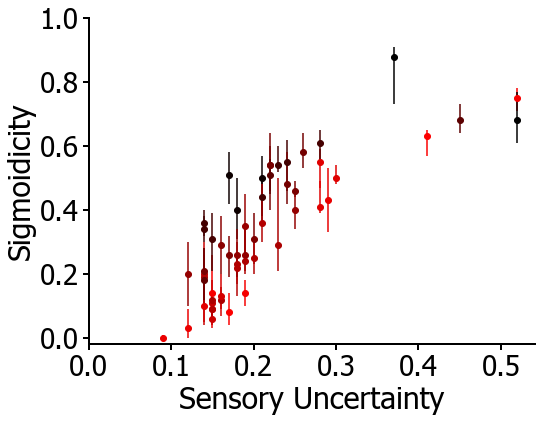

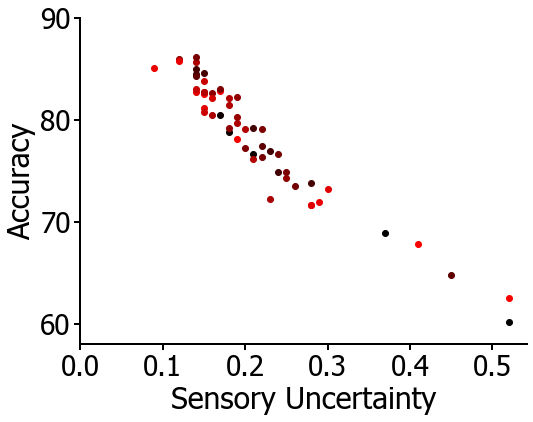

In [15]:
"""
Figs. 4E,F
Testing effect of sigma sensory on category choice and accuracy given p_distractor value.
"""
for iSubj in [23,35]:
    pback_median_Veridical[iSubj] = 0

print("Average pdistractor value", np.mean(pback_median_Veridical), np.std(pback_median_Veridical))

fig1, ax1 = plt.subplots(1,1,figsize=(8,6))
fig2, ax2 = plt.subplots(1,1,figsize=(8,6))
for iSubject in np.arange(len(ss_median_Veridical)):
    ax1.errorbar(ss_median_Veridical[iSubject], sigmoidicity_median_Veridical[iSubject], marker='o',
             yerr=[[-sigmoidicity_lowerErrorbars_Veridical[iSubject]+sigmoidicity_median_Veridical[iSubject]],
                   [sigmoidicity_upperErrorbars_Veridical[iSubject]-sigmoidicity_median_Veridical[iSubject]]],
             color=[pback_median_Veridical[iSubject], 0, 0])
    ax2.plot(ss_median_Veridical[iSubject], OverallAccuracy[iSubject], 'o',
             color=[pback_median_Veridical[iSubject], 0, 0])
    
for ax in [ax1,ax2]:
    ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
    ax.set_xlabel('Sensory Uncertainty', fontsize=30)
    ax.tick_params(axis='both',labelsize=28,length=6,width=2)   
    makeAxesPretty(ax)
ax1.set_ylim([-0.02,1])
ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax1.set_ylabel('Sigmoidicity', fontsize=30)

ax2.set_ylim([58,90])
ax2.set_yticks([60,70,80,90])
ax2.set_ylabel('Accuracy', fontsize=30) 
#fig1.savefig('figures/FromProlific/illustrations/effectOfSensoryAndRelevanceUncertaintyOnCategoryChoice.pdf',
#            bbox_inches="tight",transparent=True) 
#fig2.savefig('figures/FromProlific/illustrations/effectOfSensoryAndRelevanceUncertaintyOnAccuracy.pdf',
#            bbox_inches="tight",transparent=True) 

"""
Anova analysis for effect of p_distractor and sigma sensory on accuracy and on category choice
""" 
poly = sklearn.preprocessing.PolynomialFeatures(degree=2,interaction_only=True,include_bias = False)
X_forPoly = np.array([ss_median_Veridical, pback_median_Veridical]).T 
X_withInteraction = poly.fit_transform(X_forPoly)

X_withInteraction = sm.add_constant(X_withInteraction)
model_withInteraction = sm.OLS(OverallAccuracy, X_withInteraction)
results_withInteraction = model_withInteraction.fit()
print(results_withInteraction.summary())

poly = sklearn.preprocessing.PolynomialFeatures(degree=2,interaction_only=True,include_bias = False)
X_forPoly = np.array([ss_median_Veridical, pback_median_Veridical]).T 
X_withInteraction = poly.fit_transform(X_forPoly)

X_withInteraction = sm.add_constant(X_withInteraction)
model_withInteraction = sm.OLS(sigmoidicity_median_Veridical, X_withInteraction)
results_withInteraction = model_withInteraction.fit()
print(results_withInteraction.summary())



Sigma sensory mean is 0.20910714285714288 and standard deviation is 0.08978698572801322
Subjects with high sigma sensory are [[ 4]
 [23]
 [29]
 [34]
 [35]]
Correlation of pback and relevance metric with accuracies (overall and across trial type)
           n         r          CI95%     p-val     power
spearman  56  0.106758  [-0.16, 0.36]  0.433555  0.122954
           n         r         CI95%     p-val     power
spearman  56  0.038851  [-0.23, 0.3]  0.776192  0.059079
           n         r          CI95%         p-val     power
spearman  56 -0.685749  [-0.8, -0.52]  5.483892e-09  0.999987
           n        r           CI95%         p-val     power
spearman  56 -0.71929  [-0.83, -0.56]  4.238841e-10  0.999999
           n        r          CI95%     p-val     power
spearman  56  0.08022  [-0.19, 0.34]  0.556722  0.090403
           n         r           CI95%         p-val  power
spearman  56 -0.772419  [-0.86, -0.64]  3.124326e-12    1.0
Correlation of variables with accuracy
mu 

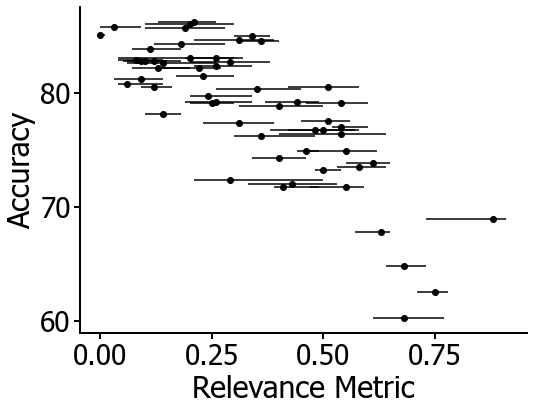

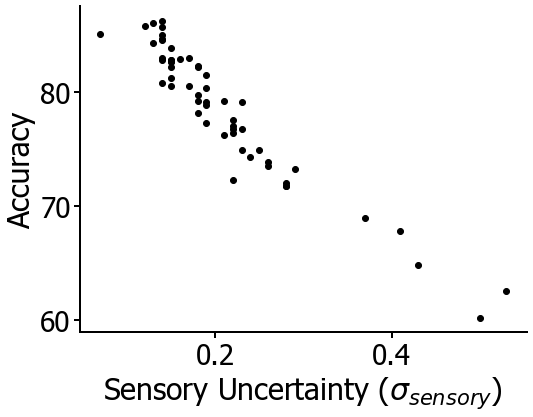

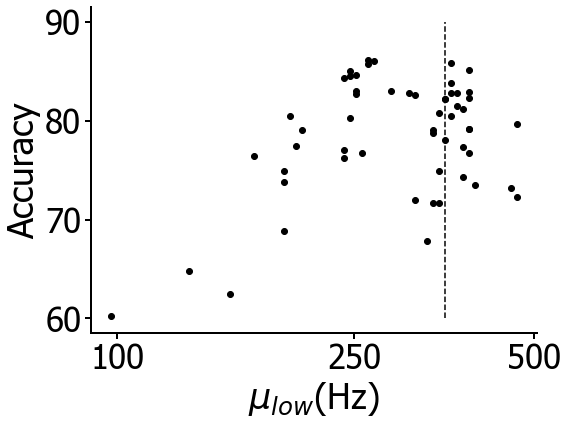

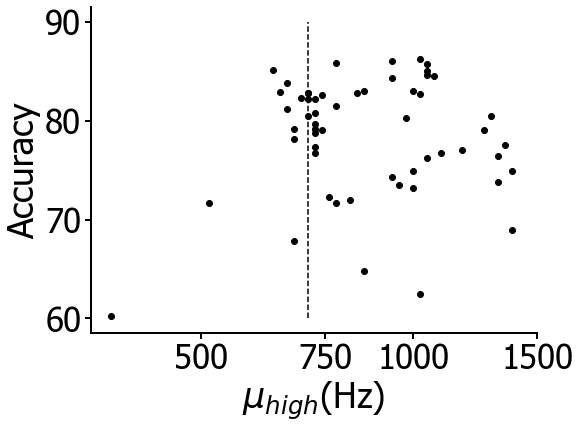

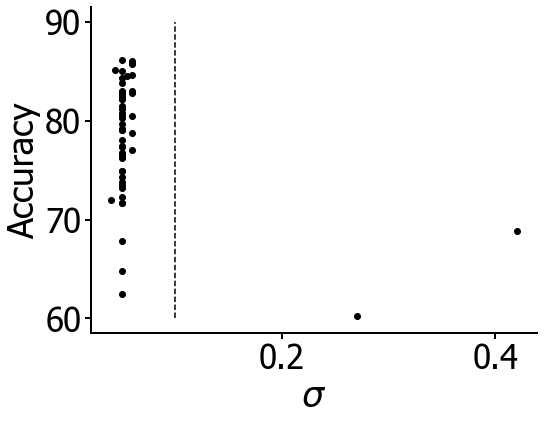

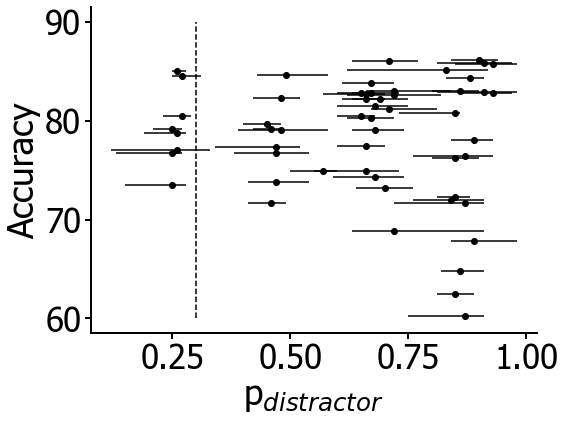

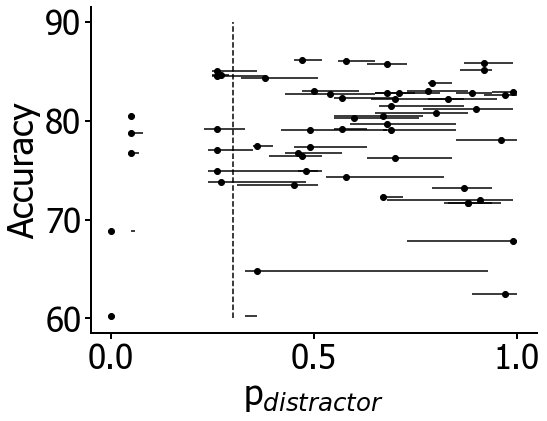

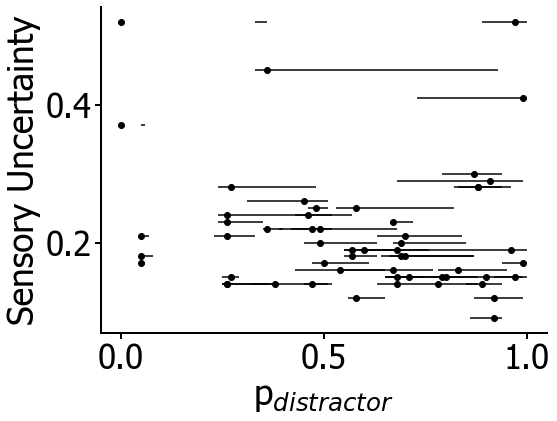

In [19]:
"""
Extended data Figs. 4A-E.
Qs: how can we relate performance to metrics from the bayesian model?
"""
pbackMedian = computedLikelihoods['medianPBack'].values
pbackLowerErrorBars = computedLikelihoods['5thPercentilePBack'].values
pbackUpperErrorBars = computedLikelihoods['95thPercentilePBack'].values
pbackMedian = pbackMedian[~np.isnan(pbackMedian)]
pbackLowerErrorBars = pbackLowerErrorBars[~np.isnan(pbackLowerErrorBars)]
pbackUpperErrorBars = pbackUpperErrorBars[~np.isnan(pbackUpperErrorBars)]

ssMedian = computedLikelihoods['ss'].values
ssMedian = ssMedian[~np.isnan(ssMedian)]
sigmaMedian = computedLikelihoods['sigma'].values
sigmaMedian = sigmaMedian[~np.isnan(sigmaMedian)]
meanLowMedian = computedLikelihoods['mean_low'].values
meanLowMedian = meanLowMedian[~np.isnan(meanLowMedian)]
meanHighMedian = computedLikelihoods['mean_high'].values
meanHighMedian = meanHighMedian[~np.isnan(meanHighMedian)]

posteriorNorm = computedLikelihoods['medianRelevanceMetric'].values
posteriorNorm = posteriorNorm[~np.isnan(posteriorNorm)]
posteriorNormLowerErrorBars = computedLikelihoods['5thPercentileRelevanceMetric'].values
posteriorNormLowerErrorBars = posteriorNormLowerErrorBars[~np.isnan(posteriorNormLowerErrorBars)]
posteriorNormUpperErrorBars = computedLikelihoods['95thPercentileRelevanceMetric'].values
posteriorNormUpperErrorBars = posteriorNormUpperErrorBars[~np.isnan(posteriorNormUpperErrorBars)]

print(f"Sigma sensory mean is {np.mean(sigmaSensory)} and standard deviation is {np.std(sigmaSensory)}")
print(f"Subjects with high sigma sensory are {np.argwhere(sigmaSensory>np.mean(sigmaSensory)+np.std(sigmaSensory))}")

OneIrrelevantToneAccuracy.mask[[29,34]]=False
TwoIrrelevantTonesAccuracy.mask[[29,34]]=False

fig1, ax1 = plt.subplots(1,1,figsize=(8,6))
for iSubj in range(len(posteriorNorm)):
    ax1.errorbar(posteriorNorm[iSubj],OverallAccuracy[iSubj],
                xerr=[[-posteriorNormLowerErrorBars[iSubj]+posteriorNorm[iSubj]],
                      [posteriorNormUpperErrorBars[iSubj]-posteriorNorm[iSubj]]],
                 color='k',marker='o')
ax1.set_ylabel('Accuracy',fontsize=30)
ax1.set_xlabel('Relevance Metric',fontsize=30)
ax1.tick_params(axis='both',labelsize=28,length=6,width=2)
makeAxesPretty(ax1)
#fig1.savefig('figures/FromProlific/illustrations/overallAccuracyGivenPosteriorShape.pdf',
#            bbox_inches="tight",transparent=True)

print("Correlation of pback and relevance metric with accuracies (overall and across trial type)")
print(pg.corr(pbackMedian,TwoIrrelevantTonesAccuracy,method='spearman'))
print(pg.corr(pbackMedian,OneIrrelevantToneAccuracy,method='spearman'))
print(pg.corr(posteriorNorm,TwoIrrelevantTonesAccuracy,method='spearman'))
print(pg.corr(posteriorNorm,OneIrrelevantToneAccuracy,method='spearman'))
print(pg.corr(pbackMedian,OverallAccuracy,method='spearman'))
print(pg.corr(posteriorNorm,OverallAccuracy,method='spearman'))

fig1, ax1 = plt.subplots(1,1,figsize=(8,6))
for iSubj in range(len(ssMedian)):
    ax1.plot(ssMedian[iSubj], OverallAccuracy[iSubj],
            color='k',marker='o')
ax1.set_xlabel('Sensory Uncertainty ($\\sigma_{sensory}$)',fontsize=30)
ax1.set_ylabel('Accuracy',fontsize=30)
ax1.tick_params(axis='both',labelsize=28,length=6,width=2)
makeAxesPretty(ax1)
#fig1.savefig('figures/FromProlific/illustrations/overallAccuracyGivenSensoryUncertainty.pdf',
#            bbox_inches="tight",transparent=True)


fig1, ax1 = plt.subplots(1,1,figsize=(8,6))
fig2, ax2 = plt.subplots(1,1,figsize=(8,6))
fig3, ax3 = plt.subplots(1,1,figsize=(8,6))
fig4, ax4 = plt.subplots(1,1,figsize=(8,6))
fig5, ax5 = plt.subplots(1,1,figsize=(8,6))
fig6, ax6 = plt.subplots(1,1,figsize=(8,6))
for iSubj in range(len(OverallAccuracy)):
    ax1.errorbar(meanLowMedian[iSubj], OverallAccuracy[iSubj], color='k',marker='o')
    ax2.errorbar(meanHighMedian[iSubj], OverallAccuracy[iSubj], color='k',marker='o')
    ax3.errorbar(sigmaMedian[iSubj], OverallAccuracy[iSubj], color='k',marker='o')
    ax4.errorbar(pbackMedian[iSubj], OverallAccuracy[iSubj], 
                 xerr=[[-pbackLowerErrorBars[iSubj]+pbackMedian[iSubj]],
                      [pbackUpperErrorBars[iSubj]-pbackMedian[iSubj]]],
                 color='k',marker='o')
    ax5.errorbar(pback_median_Veridical[iSubj], OverallAccuracy[iSubj], 
                 xerr=[[-pback_lowerErrorbars_Veridical[iSubj]+pback_median_Veridical[iSubj]],
                      [pback_upperErrorbars_Veridical[iSubj]-pback_median_Veridical[iSubj]]],
                 color='k',marker='o')
    ax6.errorbar(pback_median_Veridical[iSubj], ss_median_Veridical[iSubj], 
                 xerr=[[-pback_lowerErrorbars_Veridical[iSubj]+pback_median_Veridical[iSubj]],
                      [pback_upperErrorbars_Veridical[iSubj]-pback_median_Veridical[iSubj]]],
                 color='k',marker='o')
ax1.plot(np.ones((7,1))*2.55,np.arange(60,91,5),'k--')
ax1.set_xlabel('$\mu_{low}$(Hz)',fontsize=35)
ax1.set_xticks(ticks=np.log10([100,250,500]))
ax1.set_xticklabels(labels=[100,250,500])
ax2.plot(np.ones((7,1))*2.85,np.arange(60,91,5),'k--')
ax2.set_xlabel('$\mu_{high}$(Hz)',fontsize=35)
ax2.set_xticks(ticks=np.log10([500,750,1000,1500]))
ax2.set_xticklabels(labels=[500,750,1000,1500])
ax3.plot(np.ones((7,1))*0.1,np.arange(60,91,5),'k--')
ax3.set_xlabel('$\sigma$',fontsize=35)
for ax in [ax4, ax5]:
    ax.plot(np.ones((7,1))*0.3,np.arange(60,91,5),'k--')
    ax.set_xlabel('p$_{distractor}$',fontsize=35)
for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_ylabel('Accuracy',fontsize=35)
ax6.set_xlabel('p$_{distractor}$',fontsize=35)
ax6.set_ylabel('Sensory Uncertainty',fontsize=35)
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.tick_params(axis='both',labelsize=33,length=6,width=2)
    makeAxesPretty(ax)
#fig1.savefig('figures/FromProlific/illustrations/accuracyGivenMeanLow.pdf', bbox_inches="tight", transparent=True)
#fig2.savefig('figures/FromProlific/illustrations/accuracyGivenMeanHigh.pdf', bbox_inches="tight", transparent=True)
#fig3.savefig('figures/FromProlific/illustrations/accuracyGivenSigma.pdf', bbox_inches="tight", transparent=True)
#fig4.savefig('figures/FromProlific/illustrations/accuracyGivenMeanPBack.pdf', bbox_inches="tight", transparent=True)
#fig5.savefig('figures/FromProlific/illustrations/accuracyGivenMeanPBackVeridical.pdf', bbox_inches="tight", transparent=True)

print("Correlation of variables with accuracy")
print("mu low",pg.corr(meanLowMedian,OverallAccuracy,method='spearman'))
print("mu high", pg.corr(meanHighMedian,OverallAccuracy,method='spearman'))
print("sigma", pg.corr(sigmaMedian,OverallAccuracy,method='spearman'))
print("sigma sensory", pg.corr(ssMedian,OverallAccuracy,method='spearman'))
print("pdistractor", pg.corr(pbackMedian,OverallAccuracy,method='spearman'))
    

/Users/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Wilcoxon of WC           W-val alternative     p-val       RBC  CLES
Wilcoxon  275.5   two-sided  0.368643  0.172673   NaN
Median and IQR tau 0.63 0.4375
Correlation with accuracy
Effect of previous trial            n        r          CI95%     p-val     power
spearman  56 -0.18715  [-0.43, 0.08]  0.167233  0.284306
Local effect            n        r          CI95%     p-val     power
spearman  56  0.07808  [-0.19, 0.33]  0.567325  0.088215
Global effect            n         r          CI95%    p-val     power
spearman  56  0.106526  [-0.16, 0.36]  0.43456  0.122625
Temporal effect            n         r          CI95%     p-val   power
spearman  56 -0.272804  [-0.5, -0.01]  0.041932  0.5372
Correlation with pdistractor
Effect of previous trial            n         r          CI95%     p-val     power
spearman  56 -0.356929  [-0.57, -0.1]  0.006927  0.782118
Local effect            n         r          CI95%     p-val     power
spearman  56 -0.146669  [-0.39, 0.12]  0.280737  0.191357

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.920274,0.006405,143.687624,2.284906e-70,0.92091,0.917925,0.907428,0.933120
1,x1,-0.625409,0.025279,-24.739900,8.761091e-31,0.92091,0.917925,-0.676113,-0.574705
2,x2,-0.003677,0.003871,-0.949971,3.464390e-01,0.92091,0.917925,-0.011442,0.004087


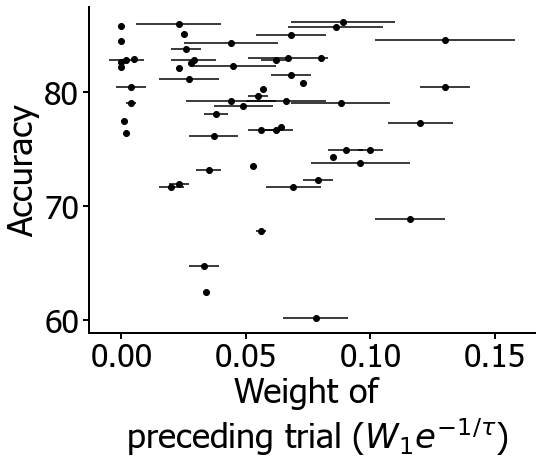

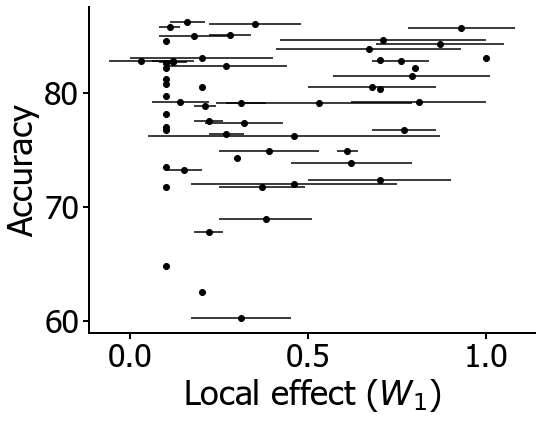

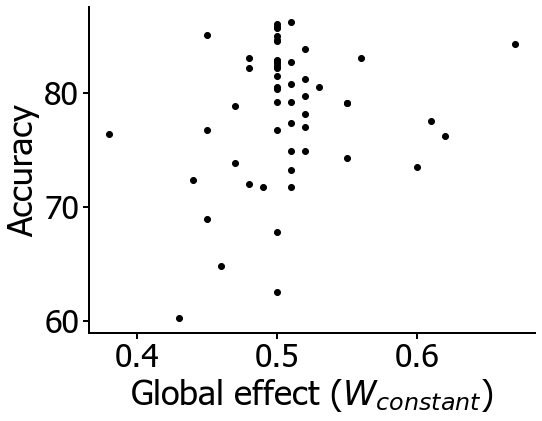

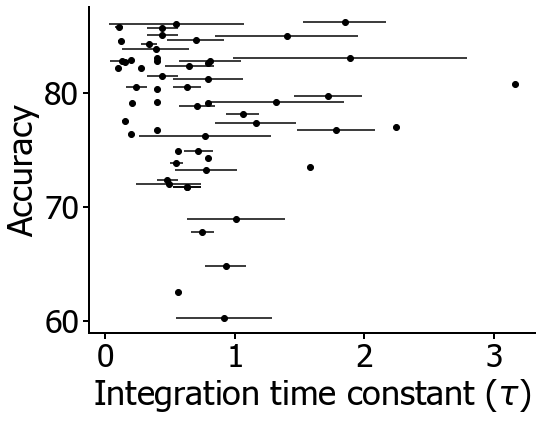

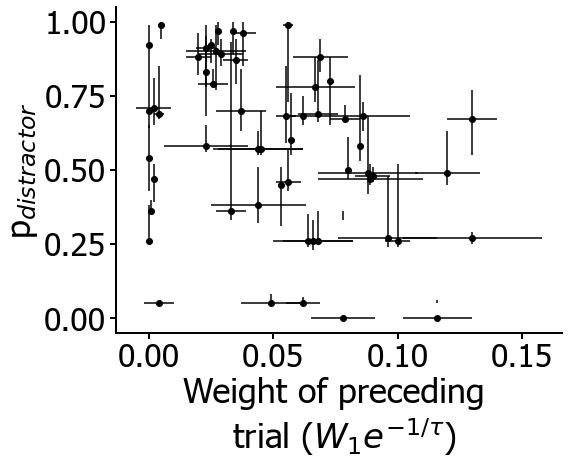

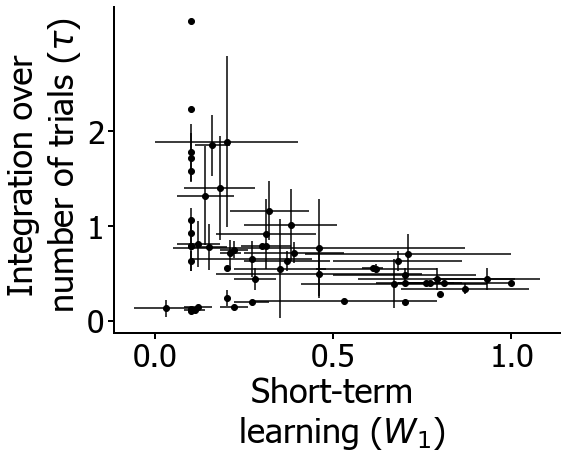

In [21]:
"""
Figure 6A-C: short term context in the unbiased data and its relation to other terms
"""
weightPreceedingTone_noContext = computedLikelihoodsVeridical['W1*e^(-1/tau)'].values
W1_noContext = computedLikelihoodsVeridical['W1'].values
WC_noContext = computedLikelihoodsVeridical['WC'].values
tau_noContext = computedLikelihoodsVeridical['tau'].values

fig7, ax7 = plt.subplots(1,1,figsize=(8,6)) 
fig8, ax8 = plt.subplots(1,1,figsize=(8,6)) 
fig9, ax9 = plt.subplots(1,1,figsize=(8,6)) 
fig10, ax10 = plt.subplots(1,1,figsize=(8,6)) 
fig11, ax11 = plt.subplots(1,1,figsize=(8,6))
fig12, ax12 = plt.subplots(1,1,figsize=(8,6)) 
for i in range(56):
    ax7.errorbar(weightPreceedingTone_noContext[i*2], OverallAccuracy[i], 
                 xerr=[[weightPreceedingTone_noContext[i*2+1]],[weightPreceedingTone_noContext[i*2+1]]],
                 color='k',marker='o')
    ax8.errorbar(W1_noContext[i*2], OverallAccuracy[i], 
                 xerr=[[W1_noContext[i*2+1]],[W1_noContext[i*2+1]]],
                 color='k',marker='o')
    ax9.errorbar(WC_noContext[i*2], OverallAccuracy[i], 
                 xerr=[[WC_noContext[i*2+1]],[WC_noContext[i*2+1]]],
                 color='k',marker='o')
    ax10.errorbar(tau_noContext[i*2], OverallAccuracy[i], 
                 xerr=[[tau_noContext[i*2+1]],[tau_noContext[i*2+1]]],
                 color='k',marker='o')
    ax11.errorbar(weightPreceedingTone_noContext[i*2], pback_median_Veridical[i], 
                  xerr=[[weightPreceedingTone_noContext[i*2+1]],[weightPreceedingTone_noContext[i*2+1]]],
                  yerr = [[-pback_lowerErrorbars_Veridical[i]+pback_median_Veridical[i]],
                          [pback_upperErrorbars_Veridical[i]-pback_median_Veridical[i]]],
                  color='k',marker='o')
    ax12.errorbar(W1_noContext[i*2], tau_noContext[i*2], 
                  xerr=[[W1_noContext[i*2+1]],[W1_noContext[i*2+1]]],
                  yerr = [[tau_noContext[i*2+1]],[tau_noContext[i*2+1]]],
                  color='k',marker='o')
ax7.set_xlabel('Weight of \n preceding trial ($W_{1}e^{-1/\\tau}$)',fontsize=34)
ax8.set_xlabel('Local effect ($W_{1}$)',fontsize=34)
ax9.set_xlabel('Global effect ($W_{constant}$)',fontsize=34)
ax10.set_xlabel('Integration time constant ($\\tau$)',fontsize=34)
ax11.set_xlabel('Weight of preceding \n trial ($W_{1}e^{-1/\\tau}$)',fontsize=34)
ax11.set_ylabel('p$_{distractor}$',fontsize=34)
ax12.set_xlabel('Short-term \n learning ($W_{1}$)',fontsize=34)
ax12.set_ylabel('Integration over \n number of trials ($\\tau$)',fontsize=34)
ax12.set_yticks([0,1,2])
ax12.set_yticklabels([0,1,2])
for ax in [ax7,ax8,ax9,ax10]:
    ax.set_ylabel('Accuracy',fontsize=34)
for ax in [ax7,ax8,ax9,ax10,ax11,ax12]:
    ax.tick_params(axis='both',labelsize=32,length=6,width=2)
    makeAxesPretty(ax)
    
#fig7.savefig('figures/FromProlific/illustrations/effectOfPreviousTrialOnAccuracy.pdf',
#           bbox_inches="tight",transparent=True)
#fig8.savefig('figures/FromProlific/illustrations/effectOfW1OnAccuracy.pdf',
#           bbox_inches="tight",transparent=True)
#fig9.savefig('figures/FromProlific/illustrations/effectOfWCOnAccuracy.pdf',
#           bbox_inches="tight",transparent=True)
#fig10.savefig('figures/FromProlific/illustrations/effectOfTauOnAccuracy.pdf',
#           bbox_inches="tight",transparent=True)
#fig11.savefig('figures/FromProlific/illustrations/variationOfPreviousTrialWithPDistractor.pdf',
#           bbox_inches="tight",transparent=True)
#fig12.savefig('figures/FromProlific/illustrations/variationOfW1WithTau.pdf',
#           bbox_inches="tight",transparent=True)

print("Wilcoxon of WC", pg.wilcoxon(WC_noContext[::2]-0.5))
print("Median and IQR tau", np.median(tau_noContext[::2]), scipy.stats.iqr(tau_noContext[::2]))

print("Correlation with accuracy")
print("Effect of previous trial",
      pg.corr(weightPreceedingTone_noContext[::2], OverallAccuracy,method='spearman'))
print("Local effect",
      pg.corr(W1_noContext[::2], OverallAccuracy,method='spearman'))
print("Global effect",
      pg.corr(WC_noContext[::2], OverallAccuracy,method='spearman'))
print("Temporal effect",
      pg.corr(tau_noContext[::2], OverallAccuracy,method='spearman'))

print("Correlation with pdistractor")
print("Effect of previous trial",
      pg.corr(weightPreceedingTone_noContext[::2], pback_median_Veridical,method='spearman'))
print("Local effect",
      pg.corr(W1_noContext[::2], pback_median_Veridical,method='spearman'))
print("Global effect",
      pg.corr(WC_noContext[::2], pback_median_Veridical,method='spearman'))
print("Temporal effect",
      pg.corr(tau_noContext[::2], pback_median_Veridical,method='spearman'))

print("Correlation with ss")
print("Effect of previous trial",
      pg.corr(weightPreceedingTone_noContext[::2], ss_median_Veridical,method='spearman'))
print("Local effect",
      pg.corr(W1_noContext[::2], ss_median_Veridical,method='spearman'))
print("Global effect",
      pg.corr(WC_noContext[::2], ss_median_Veridical,method='spearman'))
print("Temporal effect",
      pg.corr(tau_noContext[::2], ss_median_Veridical,method='spearman'))
print("Pdistractor",
      pg.corr(pback_median_Veridical[ss_median_Veridical<np.percentile(ss_median_Veridical,90)],
              ss_median_Veridical[ss_median_Veridical<np.percentile(ss_median_Veridical,90)],method='spearman'))

independentVariables = np.concatenate((np.expand_dims(ss_median_Veridical,axis=1),
                                      np.expand_dims(tau_noContext[::2],axis=1)),axis=1)

pg.linear_regression(X=independentVariables,y=OverallAccuracy/100)


Median of internalized bias in the unbiased session for bias low subjects 0.0 0.08000000000000007
Median of internalized bias in the unbiased session for bias high subjects 0.0 0.08000000000000007
Median of internalized bias in the biased low session 0.09999999999999998 0.12
Median of internalized bias in the biased high session 0.19999999999999996 0.1700000000000001
Comparing bias in no and low sessions           W-val alternative         p-val       RBC     CLES
Wilcoxon   42.5   two-sided  6.092451e-09 -0.935897  0.11214
Comparing bias in no and high sessions           W-val alternative         p-val  RBC      CLES
Wilcoxon    0.0   two-sided  3.623176e-09 -1.0  0.036892
Correlation of bias with difference in accuracy in biased low session            n         r        CI95%         p-val  power
spearman  53  0.993901  [0.99, 1.0]  1.643448e-50    1.0
Correlation of bias with difference in accuracy in biased high session            n         r         CI95%         p-val  power
spea

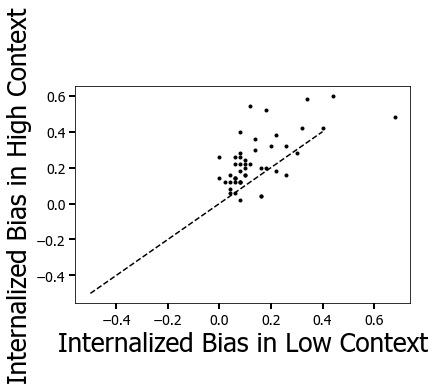

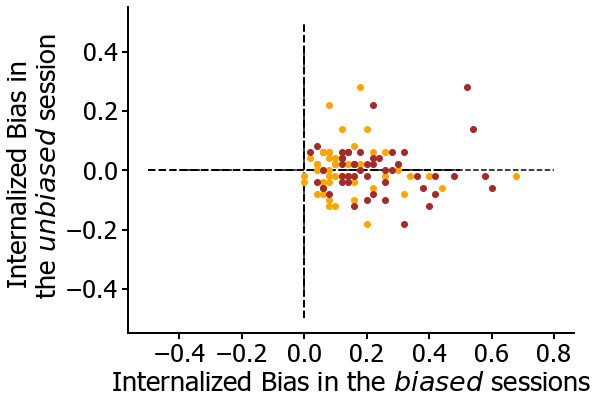

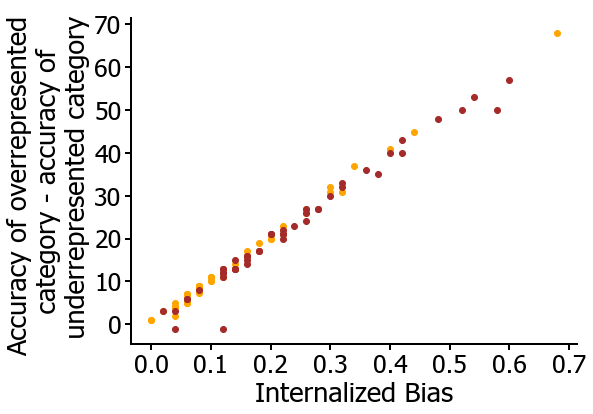

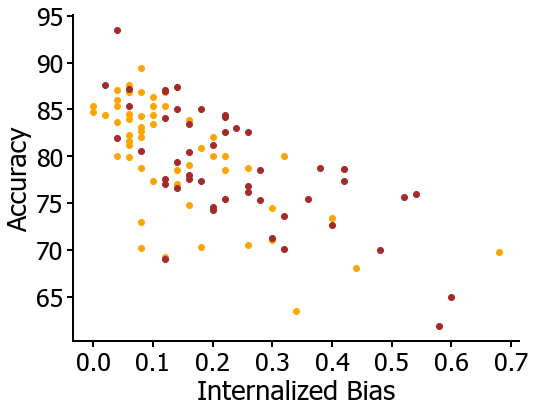

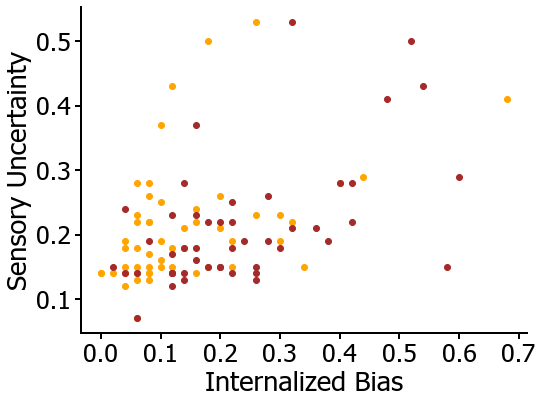

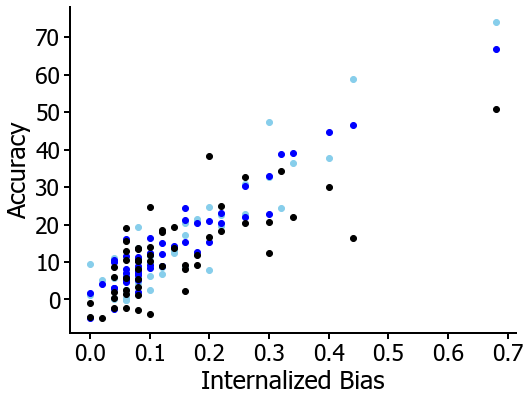

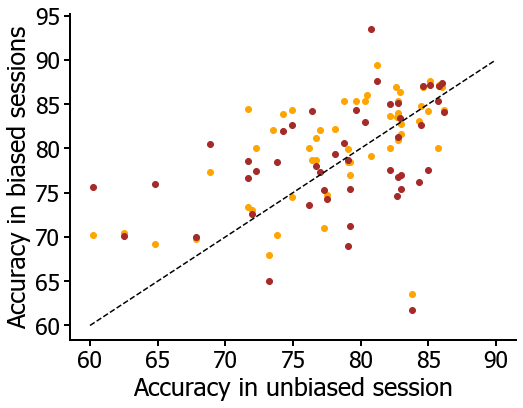

In [27]:
"""
Old figure, no longer in the paper. The concept is however relevant to inter-participant variability in the biased sessions. 
"""
"""
Qs: are subjects equally biased in both the long context cases? 
This is the internalized bias which is obtained from the matched raw data for subjects that do both the long 
context expts.
"""
internalizedBias = pd.read_excel(xls,'internalizedBias',nrows=53)

biasLowForSubjectsWithBothLongContexts = internalizedBias['biasLowContext'].values
biasLowForSubjectsWithBothLongContexts = biasLowForSubjectsWithBothLongContexts[~np.isnan(internalizedBias['biasHighContext'])]
biasHighForSubjectsWithBothLongContexts = internalizedBias['biasHighContext'].values
biasHighForSubjectsWithBothLongContexts = biasHighForSubjectsWithBothLongContexts[~np.isnan(biasHighForSubjectsWithBothLongContexts)]

fig, ax = plt.subplots()
ax.plot((0.5-biasLowForSubjectsWithBothLongContexts)*2,(biasHighForSubjectsWithBothLongContexts-0.5)*2,'k.')
ax.plot(np.arange(-0.5,0.5,0.1),np.arange(-0.5,0.5,0.1),'k--')
ax.tick_params(axis='both',length=6,width=2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Internalized Bias in Low Context',fontsize=26)
plt.ylabel('Internalized Bias in High Context',fontsize=26)
#plt.savefig('figures/FromProlific/illustrations/biasLowContextVsbiasHighContext',bbox_inches="tight")

"""
Qs: are subjects also biased in the no context case? This is benchmarking internalized bias against 
the no context.  
"""

biasLowForSubjectsWithNoAndLowContexts = internalizedBias['biasLowContext'].values
biasNoForSubjectsWithNoAndLowContexts = internalizedBias['biasNoContext'].values

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.tick_params(axis='both',length=6,width=2)
ax.plot((0.5-biasLowForSubjectsWithNoAndLowContexts)*2,(biasNoForSubjectsWithNoAndLowContexts-0.5)*2,'o',color='orange')
ax.hlines(0,xmin=-0.5,xmax=0.5,color='k',linestyles='--',linewidth=2)
ax.vlines(0,ymin=-0.5,ymax=0.5,color='k',linestyles='--',linewidth=2)

biasHighForSubjectsWithNoAndHighContexts = internalizedBias['biasHighContext'].values
biasHighForSubjectsWithNoAndHighContexts = biasHighForSubjectsWithNoAndHighContexts[~np.isnan(biasHighForSubjectsWithNoAndHighContexts)]
biasNoForSubjectsWithNoAndHighContexts = internalizedBias['biasNoContext'].values
biasNoForSubjectsWithNoAndHighContexts = biasNoForSubjectsWithNoAndHighContexts[~np.isnan(internalizedBias['biasHighContext'])]

ax.plot((biasHighForSubjectsWithNoAndHighContexts-0.5)*2,(biasNoForSubjectsWithNoAndHighContexts-0.5)*2,'o',color='brown')
ax.hlines(0,xmin=-0.4,xmax=0.8,color='k',linestyles='--')
ax.vlines(0,ymin=-0.4,ymax=0.4,color='k',linestyles='--')
makeAxesPretty(ax)
ax.tick_params(axis='both',length=6,width=2)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Internalized Bias in the $\it{biased}$ sessions',fontsize=27)
plt.ylabel('Internalized Bias in \n the $\it{unbiased}$ session',fontsize=27)
#plt.savefig('figures/FromProlific/illustrations/biasNoContextVsbiasLongContext.pdf',
#            bbox_inches="tight",transparent=True)

"""
Qs: how does internalized bias compare to performance accuracy?
"""
majorityVsMinorityCategoryAccuracyHighContext = internalizedBias['DifferenceInAccuracyOfCategoriesInHighContext'].values
majorityVsMinorityCategoryAccuracyHighContext = majorityVsMinorityCategoryAccuracyHighContext[~np.isnan(majorityVsMinorityCategoryAccuracyHighContext)]
majorityVsMinorityCategoryAccuracyLowContext = internalizedBias['DifferenceInAccuracyOfCategoriesInLowContext'].values

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot((0.5-biasLowForSubjectsWithNoAndLowContexts)*2,majorityVsMinorityCategoryAccuracyLowContext*100,
        'o',color='orange')
ax.plot((biasHighForSubjectsWithNoAndHighContexts-0.5)*2,majorityVsMinorityCategoryAccuracyHighContext*100,
        'o',color='brown')
makeAxesPretty(ax)
ax.set_xticks(np.arange(0,0.8,0.1))
ax.set_xticklabels(np.around(np.arange(0,0.8,0.1),1),fontsize=25)
plt.yticks(fontsize=25)
ax.tick_params(axis='both',length=6,width=2)
plt.xlabel('Internalized Bias',fontsize=27)
plt.ylabel('Accuracy of overrepresented \n category - accuracy of \n underrepresented category',fontsize=27)
#plt.savefig('figures/FromProlific/illustrations/accuracyInMajorityMinorityCategoriesExplainsInternalisedBias.pdf',
#            bbox_inches="tight",transparent=True)

AccuracyHighContext = np.ma.array(internalizedBias['accuracyHighContext'].values,mask=False)
AccuracyHighContext = AccuracyHighContext[~np.isnan(AccuracyHighContext)]
AccuracyLowContext = np.ma.array(internalizedBias['accuracyLowContext'].values,mask=False)
AccuracyNoContext = internalizedBias['accuracyNoContext'].values

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot((0.5-biasLowForSubjectsWithNoAndLowContexts)*2,AccuracyLowContext,
        'o',color='orange')
ax.plot((biasHighForSubjectsWithNoAndHighContexts-0.5)*2,AccuracyHighContext,
        'o',color='brown')
makeAxesPretty(ax)
ax.set_xticks(np.arange(0,0.8,0.1))
ax.set_xticklabels(np.around(np.arange(0,0.8,0.1),1),fontsize=25)
plt.yticks(fontsize=25)
ax.tick_params(axis='both',length=6,width=2)
plt.xlabel('Internalized Bias',fontsize=27)
plt.ylabel('Accuracy',fontsize=27)
#plt.savefig('figures/FromProlific/illustrations/totalAccuracyVsInternalisedBias.pdf',
#            bbox_inches="tight",transparent=True)

ssMedian = internalizedBias['ss'].values
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot((0.5-biasLowForSubjectsWithNoAndLowContexts)*2,ssMedian,
        'o',color='orange')
ax.plot((biasHighForSubjectsWithNoAndHighContexts-0.5)*2,ssMedian[:-5],
        'o',color='brown')
makeAxesPretty(ax)
ax.set_xticks(np.arange(0,0.8,0.1))
ax.set_xticklabels(np.around(np.arange(0,0.8,0.1),1),fontsize=25)
plt.yticks(fontsize=25)
ax.tick_params(axis='both',length=6,width=2)
plt.xlabel('Internalized Bias',fontsize=27)
plt.ylabel('Sensory Uncertainty',fontsize=27)
#plt.savefig('figures/FromProlific/illustrations/sensoryUncertaintyVsInternalisedBias.pdf',
#            bbox_inches="tight",transparent=True)

DiffInAccuracyNoDistractorsLowContext = internalizedBias['DifferenceInAccuracyNoDistractorTrialsLowContext'].values
DiffInAccuracyOneDistractorLowContext = internalizedBias['DifferenceInAccuracyOneDistractorTrialsLowContext'].values
DiffInAccuracyTwoDistractorLowContext = internalizedBias['DifferenceInAccuracyTwoDistractorTrialsLowContext'].values
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot((0.5-biasLowForSubjectsWithNoAndLowContexts)*2,DiffInAccuracyNoDistractorsLowContext,
        'o',color='skyblue')
ax.plot((0.5-biasLowForSubjectsWithNoAndLowContexts)*2,DiffInAccuracyOneDistractorLowContext,
        'o',color='blue')
ax.plot((0.5-biasLowForSubjectsWithNoAndLowContexts)*2,DiffInAccuracyTwoDistractorLowContext,
        'o',color='black')
makeAxesPretty(ax)
ax.set_xticks(np.arange(0,0.8,0.1))
ax.set_xticklabels(np.around(np.arange(0,0.8,0.1),1),fontsize=23)
plt.yticks(fontsize=23)
ax.tick_params(axis='both',length=6,width=2)
plt.xlabel('Internalized Bias',fontsize=25)
plt.ylabel('Accuracy',fontsize=25)

print("Median of internalized bias in the unbiased session for bias low subjects", 
      np.median((0.5-biasNoForSubjectsWithNoAndLowContexts)*2), 
      scipy.stats.iqr((0.5-biasNoForSubjectsWithNoAndLowContexts)*2))
print("Median of internalized bias in the unbiased session for bias high subjects", 
      np.median((0.5-biasNoForSubjectsWithNoAndHighContexts)*2), 
      scipy.stats.iqr((0.5-biasNoForSubjectsWithNoAndHighContexts)*2))
print("Median of internalized bias in the biased low session", 
      np.median((0.5-biasLowForSubjectsWithNoAndLowContexts)*2),
      scipy.stats.iqr((0.5-biasLowForSubjectsWithNoAndLowContexts)*2))
print("Median of internalized bias in the biased high session", 
     np.median((biasHighForSubjectsWithNoAndHighContexts-0.5)*2), 
      scipy.stats.iqr((biasHighForSubjectsWithNoAndHighContexts-0.5)*2))
print("Comparing bias in no and low sessions",pg.wilcoxon((0.5-biasNoForSubjectsWithNoAndLowContexts)*2,
                                                          (0.5-biasLowForSubjectsWithNoAndLowContexts)*2))
print("Comparing bias in no and high sessions",pg.wilcoxon((0.5-biasNoForSubjectsWithNoAndHighContexts)*2,
                                                           (biasHighForSubjectsWithNoAndHighContexts-0.5)*2))
print("Correlation of bias with difference in accuracy in biased low session",
      pg.corr((0.5-biasLowForSubjectsWithNoAndLowContexts)*2,
              majorityVsMinorityCategoryAccuracyLowContext,method='spearman'))
print("Correlation of bias with difference in accuracy in biased high session",
      pg.corr((biasHighForSubjectsWithNoAndHighContexts-0.5)*2,
              majorityVsMinorityCategoryAccuracyHighContext,method='spearman'))
print("Correlation of bias and accuracy in biased low session", pg.corr((0.5-biasLowForSubjectsWithNoAndLowContexts)*2,
                                                                        AccuracyLowContext,method='spearman'))
print("Correlation of bias and accuracy in biased high session", pg.corr((biasHighForSubjectsWithNoAndHighContexts-0.5)*2,
                                                                         AccuracyHighContext,method='spearman'))

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(AccuracyNoContext,AccuracyLowContext,'o',color='orange')
ax.plot(AccuracyNoContext[:-5],AccuracyHighContext,'o',color='brown')
ax.plot([60,90],[60,90],color='k',linestyle='--')
makeAxesPretty(ax)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
ax.tick_params(axis='both',length=6,width=2)
ax.set_xlabel('Accuracy in unbiased session',fontsize=25)
ax.set_ylabel('Accuracy in biased sessions',fontsize=25)
AccuracyLongContext = (AccuracyHighContext+AccuracyLowContext[:-5])/2
print("Comparing accuracy in no and long sessions",pg.ttest(AccuracyNoContext[:-5]-AccuracyLongContext,0))

print(sum(AccuracyNoContext>AccuracyLowContext), 
      sum(AccuracyNoContext[:-5]>AccuracyHighContext))



Median and IQR of prob model BICs low context for all subjects 408.47093695675665 140.54000000000002
Median and IQR of prob model BICs high context for all subjects 424.81367946844944 122.23403500776686
Median and IQR of random model BICs low context all subjects 663.8654653894082 13.180000000000064
Median and IQR of random model BICs high context all subjects 629.0024529789663 35.514999999999986
Comparing random and prob model BICs low context using wilcoxon           W-val alternative         p-val       RBC      CLES
Wilcoxon   16.0   two-sided  6.090047e-10  0.977638  0.972588
Comparing random and prob model BICs high context using wilcoxon           W-val alternative         p-val       RBC      CLES
Wilcoxon   37.0   two-sided  1.640062e-08  0.937075  0.956597
Correlation between ss and accuracy in biased context             n         r           CI95%         p-val  power
spearman  101 -0.748335  [-0.82, -0.65]  2.378474e-19    1.0
Median and IQR of prob model BICs low context f

/Users/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


[Text(2, 0, 'Sensory \n uncertainty'),
 Text(4, 0, '$W_{1}e^{-1/\\tau}$'),
 Text(6, 0, '$p_{distractor}$')]

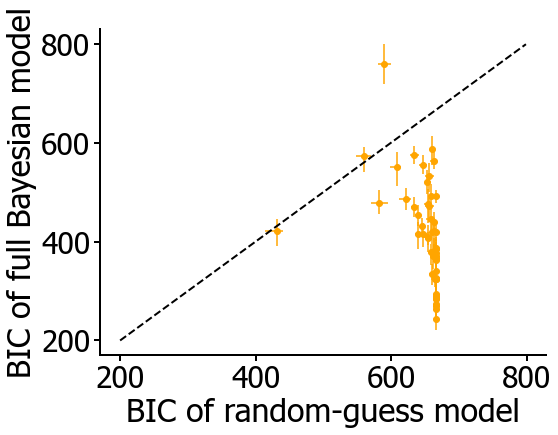

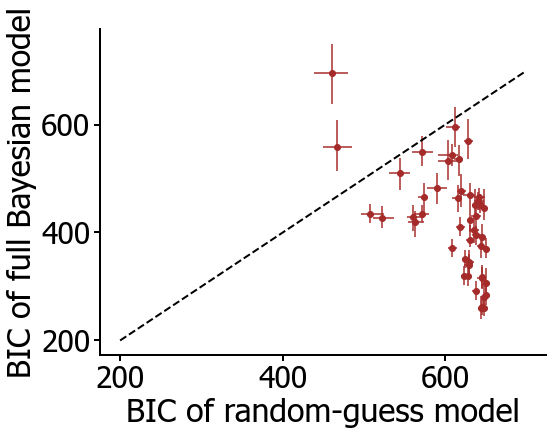

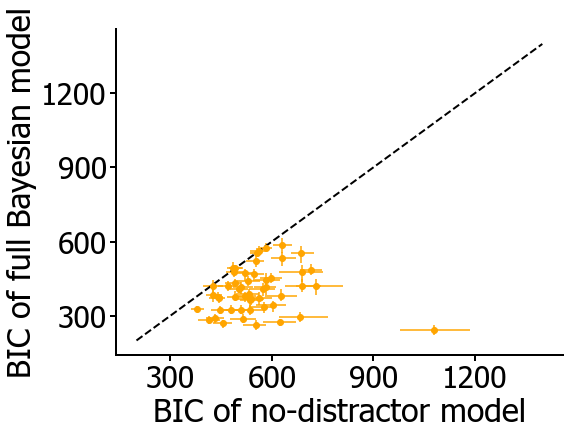

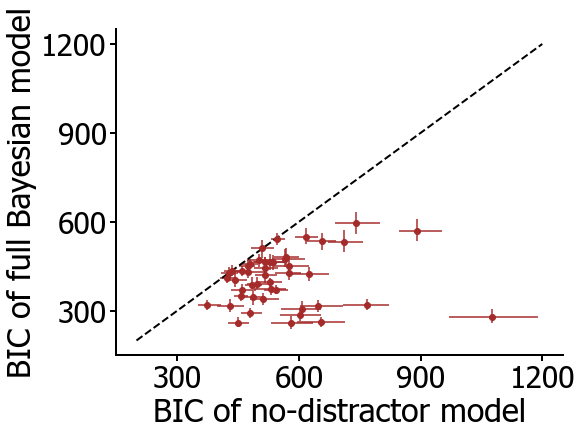

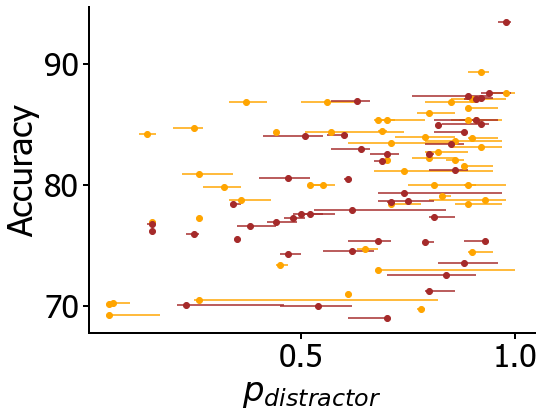

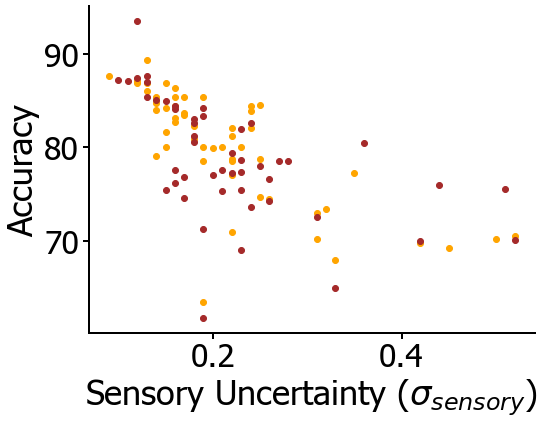

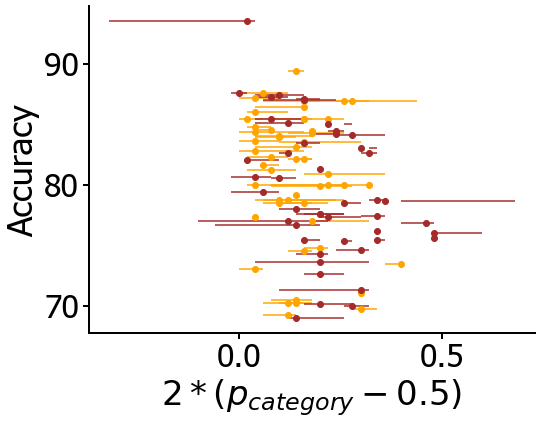

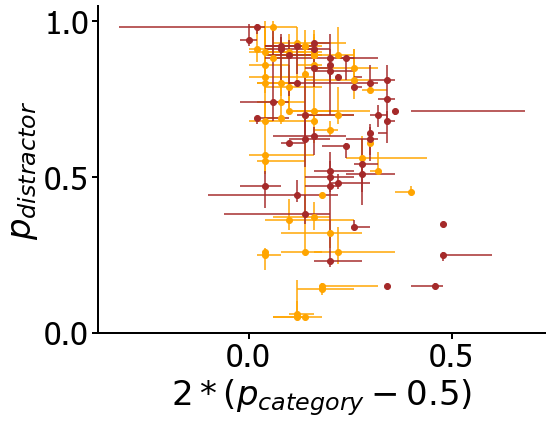

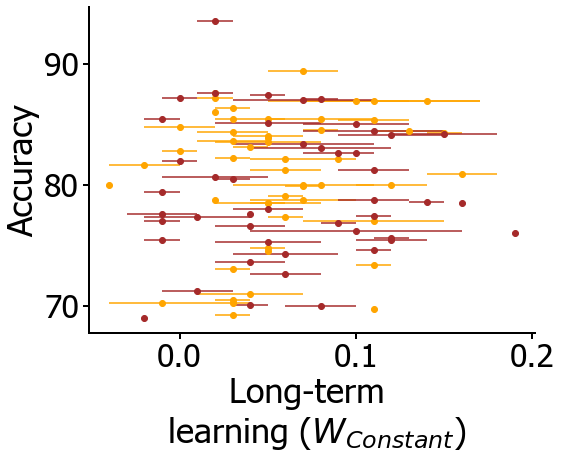

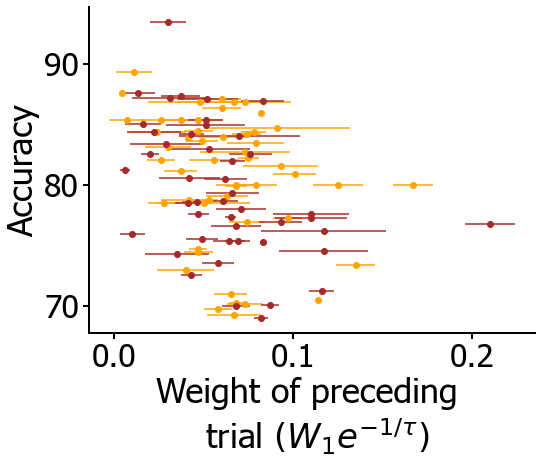

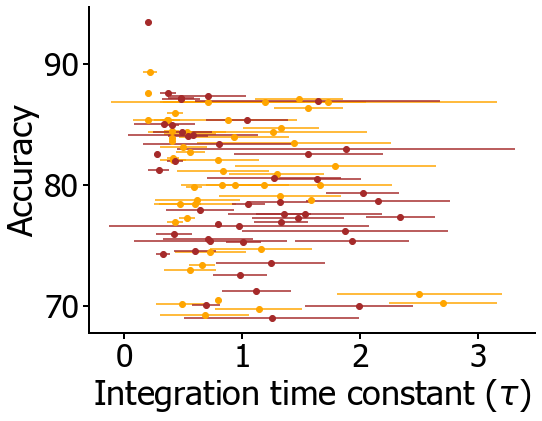

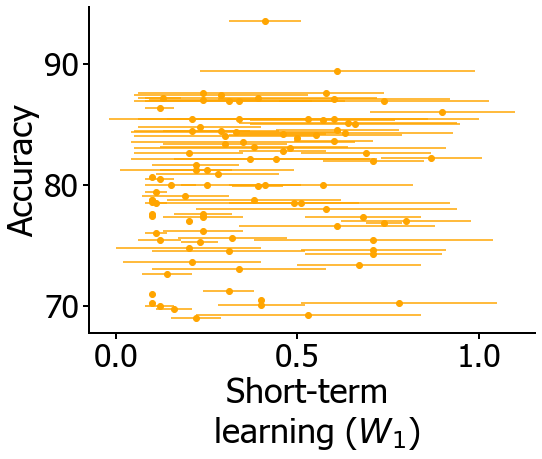

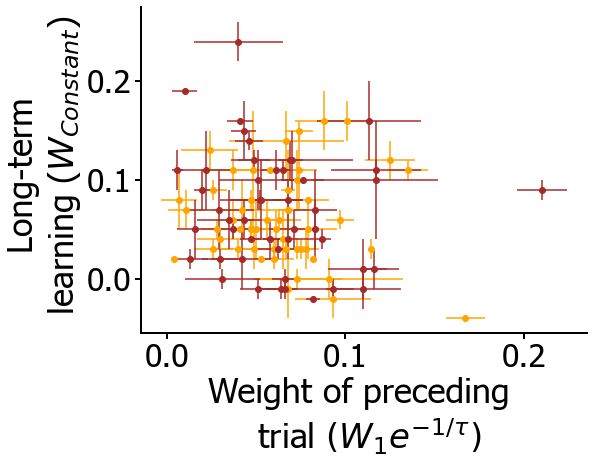

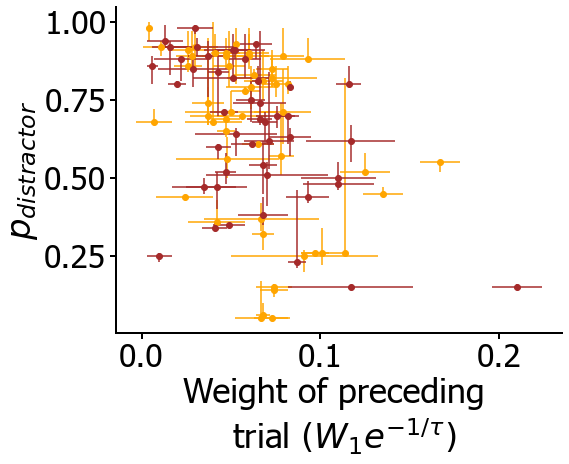

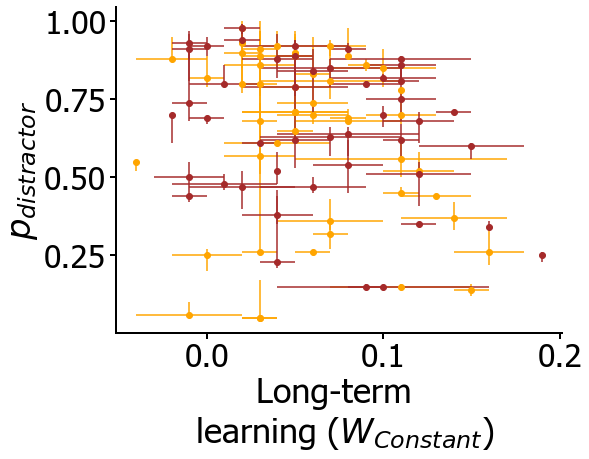

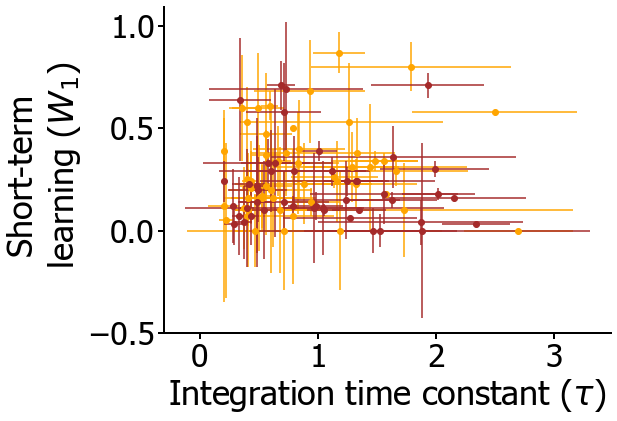

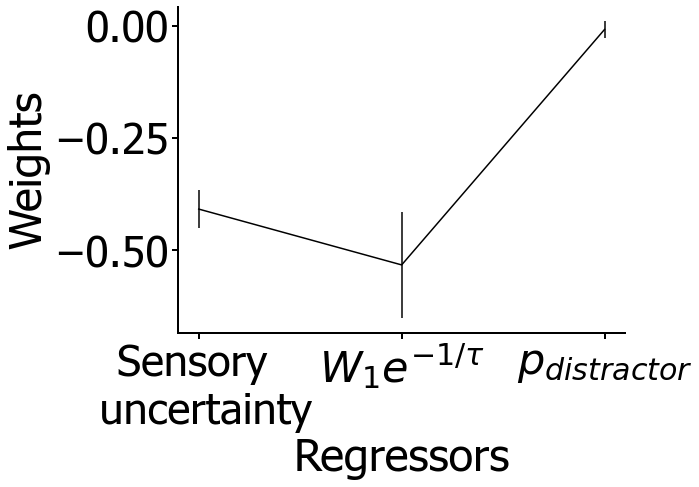

In [28]:
"""
Figure 6.
Qs: What are the trends in the long context? 
"""

bic_lowContext_probModel = np.ma.array(computedLikelihoodsLowContextVeridical['medianProb'].values,mask=False)
bic_lowContext_probModel = bic_lowContext_probModel[~np.isnan(bic_lowContext_probModel)]

bic_lowContext_randomModel = np.ma.array(computedLikelihoodsLowContextVeridical['medianRandom'].values,mask=False)
bic_lowContext_randomModel = bic_lowContext_randomModel[~np.isnan(bic_lowContext_randomModel)]

bic_lowContext_signalModel = np.ma.array(computedLikelihoodsLowContextVeridical['medianSignal'].values,mask=False)
bic_lowContext_signalModel = bic_lowContext_signalModel[~np.isnan(bic_lowContext_signalModel)]

bic_lowContext_lowerError_probModel = np.ma.array(computedLikelihoodsLowContextVeridical['5thPercentileProb'].values,mask=False)
bic_lowContext_lowerError_probModel = bic_lowContext_lowerError_probModel[~np.isnan(bic_lowContext_lowerError_probModel)]

bic_lowContext_upperError_probModel = np.ma.array(computedLikelihoodsLowContextVeridical['95thPercentileProb'].values,mask=False)
bic_lowContext_upperError_probModel = bic_lowContext_upperError_probModel[~np.isnan(bic_lowContext_upperError_probModel)]

bic_lowContext_lowerError_randomModel = np.ma.array(computedLikelihoodsLowContextVeridical['5thPercentileRandom'].values,mask=False)
bic_lowContext_lowerError_randomModel = bic_lowContext_lowerError_randomModel[~np.isnan(bic_lowContext_lowerError_randomModel)]

bic_lowContext_upperError_randomModel = np.ma.array(computedLikelihoodsLowContextVeridical['95thPercentileRandom'].values,mask=False)
bic_lowContext_upperError_randomModel = bic_lowContext_upperError_randomModel[~np.isnan(bic_lowContext_upperError_randomModel)]

bic_lowContext_lowerError_signalModel = np.ma.array(computedLikelihoodsLowContextVeridical['5thPercentileSignal'].values,mask=False)
bic_lowContext_lowerError_signalModel = bic_lowContext_lowerError_signalModel[~np.isnan(bic_lowContext_lowerError_signalModel)]

bic_lowContext_upperError_signalModel = np.ma.array(computedLikelihoodsLowContextVeridical['95thPercentileSignal'].values,mask=False)
bic_lowContext_upperError_signalModel = bic_lowContext_upperError_signalModel[~np.isnan(bic_lowContext_upperError_signalModel)]

size_lowContext = np.ma.array(computedLikelihoodsLowContextVeridical['sizeSubsampledDataset'].values,mask=False)
size_lowContext = size_lowContext[~np.isnan(size_lowContext)]

bic_highContext_probModel = np.ma.array(computedLikelihoodsHighContextVeridical['medianProb'].values,mask=False)
bic_highContext_probModel = bic_highContext_probModel[~np.isnan(bic_highContext_probModel)]

bic_highContext_randomModel = np.ma.array(computedLikelihoodsHighContextVeridical['medianRandom'].values,mask=False)
bic_highContext_randomModel = bic_highContext_randomModel[~np.isnan(bic_highContext_randomModel)]

bic_highContext_signalModel = np.ma.array(computedLikelihoodsHighContextVeridical['medianSignal'].values,mask=False)
bic_highContext_signalModel = bic_highContext_signalModel[~np.isnan(bic_highContext_signalModel)]

bic_highContext_lowerError_probModel = np.ma.array(computedLikelihoodsHighContextVeridical['5thPercentileProb'].values,mask=False)
bic_highContext_lowerError_probModel = bic_highContext_lowerError_probModel[~np.isnan(bic_highContext_lowerError_probModel)]

bic_highContext_upperError_probModel = np.ma.array(computedLikelihoodsHighContextVeridical['95thPercentileProb'].values,mask=False)
bic_highContext_upperError_probModel = bic_highContext_upperError_probModel[~np.isnan(bic_highContext_upperError_probModel)]

bic_highContext_lowerError_randomModel = np.ma.array(computedLikelihoodsHighContextVeridical['5thPercentileRandom'].values,mask=False)
bic_highContext_lowerError_randomModel = bic_highContext_lowerError_randomModel[~np.isnan(bic_highContext_lowerError_randomModel)]

bic_highContext_upperError_randomModel = np.ma.array(computedLikelihoodsHighContextVeridical['95thPercentileRandom'].values,mask=False)
bic_highContext_upperError_randomModel = bic_highContext_upperError_randomModel[~np.isnan(bic_highContext_upperError_randomModel)]

bic_highContext_lowerError_signalModel = np.ma.array(computedLikelihoodsHighContextVeridical['5thPercentileSignal'].values,mask=False)
bic_highContext_lowerError_signalModel = bic_highContext_lowerError_signalModel[~np.isnan(bic_highContext_lowerError_signalModel)]

bic_highContext_upperError_signalModel = np.ma.array(computedLikelihoodsHighContextVeridical['95thPercentileSignal'].values,mask=False)
bic_highContext_upperError_signalModel = bic_highContext_upperError_signalModel[~np.isnan(bic_highContext_upperError_signalModel)]

size_highContext = np.ma.array(computedLikelihoodsHighContextVeridical['sizeSubsampledDataset'].values,mask=False)
size_highContext = size_highContext[~np.isnan(size_highContext)]

pcategory_lowContextWithNan = np.ma.array(computedLikelihoodsLowContextVeridical['medianPLow'].values,mask=False)
pcategory_lowContext = pcategory_lowContextWithNan[~np.isnan(pcategory_lowContextWithNan)]

pcategory_lowContextWithNan_lowerError = np.ma.array(computedLikelihoodsLowContextVeridical['5thPercentilePLow'].values,mask=False)
pcategory_lowContext_lowerError = pcategory_lowContextWithNan_lowerError[~np.isnan(pcategory_lowContextWithNan_lowerError)]

pcategory_lowContextWithNan_upperError = np.ma.array(computedLikelihoodsLowContextVeridical['95thPercentilePLow'].values,mask=False)
pcategory_lowContext_upperError = pcategory_lowContextWithNan_upperError[~np.isnan(pcategory_lowContextWithNan_upperError)]

pback_lowContextWithNan = np.ma.array(computedLikelihoodsLowContextVeridical['medianPBack'].values,mask=False)
pback_lowContext = pback_lowContextWithNan[~np.isnan(pback_lowContextWithNan)]

pback_lowContextWithNan_lowerError = np.ma.array(computedLikelihoodsLowContextVeridical['5thPercentilePBack'].values,mask=False)
pback_lowContext_lowerError = pback_lowContextWithNan_lowerError[~np.isnan(pback_lowContextWithNan_lowerError)]

pback_lowContextWithNan_upperError = np.ma.array(computedLikelihoodsLowContextVeridical['95thPercentilePBack'].values,mask=False)
pback_lowContext_upperError = pback_lowContextWithNan_upperError[~np.isnan(pback_lowContextWithNan_upperError)]

WC_lowContextWithNan = np.ma.array(computedLikelihoodsLowContextVeridical['WC'].values,mask=False)
WC_lowContext = WC_lowContextWithNan[~np.isnan(WC_lowContextWithNan)]

W1_lowContextWithNan = np.ma.array(computedLikelihoodsLowContextVeridical['W1'].values,mask=False)
W1_lowContext = W1_lowContextWithNan[~np.isnan(W1_lowContextWithNan)]

tau_lowContextWithNan = np.ma.array(computedLikelihoodsLowContextVeridical['tau'].values,mask=False)
tau_lowContext = tau_lowContextWithNan[~np.isnan(tau_lowContextWithNan)]

weightPreceedingTone_lowContextWithNan = np.ma.array(computedLikelihoodsLowContextVeridical['W1*e-(1/tau)'].values,mask=False)
weightPreceedingTone_lowContext = weightPreceedingTone_lowContextWithNan[~np.isnan(weightPreceedingTone_lowContextWithNan)]

pcategory_highContextWithNan = np.ma.array(computedLikelihoodsHighContextVeridical['medianPLow'].values,mask=False)
pcategory_highContext = pcategory_highContextWithNan[~np.isnan(pcategory_highContextWithNan)]

pcategory_highContextWithNan_lowerError = np.ma.array(computedLikelihoodsHighContextVeridical['5thPercentilePLow'].values,mask=False)
pcategory_highContext_lowerError = pcategory_highContextWithNan_lowerError[~np.isnan(pcategory_highContextWithNan_lowerError)]

pcategory_highContextWithNan_upperError = np.ma.array(computedLikelihoodsHighContextVeridical['95thPercentilePLow'].values,mask=False)
pcategory_highContext_upperError = pcategory_highContextWithNan_upperError[~np.isnan(pcategory_highContextWithNan_upperError)]

pback_highContextWithNan = np.ma.array(computedLikelihoodsHighContextVeridical['medianPBack'].values,mask=False)
pback_highContext = pback_highContextWithNan[~np.isnan(pback_highContextWithNan)]

pback_highContextWithNan_lowerError = np.ma.array(computedLikelihoodsHighContextVeridical['5thPercentilePBack'].values,mask=False)
pback_highContext_lowerError = pback_highContextWithNan_lowerError[~np.isnan(pback_highContextWithNan_lowerError)]

pback_highContextWithNan_upperError = np.ma.array(computedLikelihoodsHighContextVeridical['95thPercentilePBack'].values,mask=False)
pback_highContext_upperError = pback_highContextWithNan_upperError[~np.isnan(pback_highContextWithNan_upperError)]

WC_highContextWithNan = np.ma.array(computedLikelihoodsHighContextVeridical['WC'].values,mask=False)
WC_highContext = WC_highContextWithNan[~np.isnan(WC_highContextWithNan)]

W1_highContextWithNan = np.ma.array(computedLikelihoodsHighContextVeridical['W1'].values,mask=False)
W1_highContext = W1_highContextWithNan[~np.isnan(W1_highContextWithNan)]

tau_highContextWithNan = np.ma.array(computedLikelihoodsHighContextVeridical['tau'].values,mask=False)
tau_highContext = tau_highContextWithNan[~np.isnan(tau_highContextWithNan)]

weightPreceedingTone_highContextWithNan = np.ma.array(computedLikelihoodsHighContextVeridical['W1*e-(1/tau)'].values,mask=False)
weightPreceedingTone_highContext = weightPreceedingTone_highContextWithNan[~np.isnan(weightPreceedingTone_highContextWithNan)]

fig1, ax1 = plt.subplots(1,1,figsize=(8,6))
fig2, ax2 = plt.subplots(1,1,figsize=(8,6))
fig3, ax3 = plt.subplots(1,1,figsize=(8,6))
fig4, ax4 = plt.subplots(1,1,figsize=(8,6))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
for i in np.arange(53):     
    ax1.errorbar(2*bic_lowContext_randomModel[i]+2*np.log(size_lowContext[i]),
                 2*bic_lowContext_probModel[i]+3*np.log(size_lowContext[i]), 
                 xerr=[[-2*bic_lowContext_lowerError_randomModel[i]+2*bic_lowContext_randomModel[i]],
                      [2*bic_lowContext_upperError_randomModel[i]-2*bic_lowContext_randomModel[i]]],
                 yerr=[[-2*bic_lowContext_lowerError_probModel[i]+2*bic_lowContext_probModel[i]],
                      [2*bic_lowContext_upperError_probModel[i]-2*bic_lowContext_probModel[i]]],
                 color='orange',marker='o')
for i in range(48): 
    ax2.errorbar(2*bic_highContext_randomModel[i]+2*np.log(size_highContext[i]),
                 2*bic_highContext_probModel[i]+3*np.log(size_highContext[i]), 
                 xerr=[[-2*bic_highContext_lowerError_randomModel[i]+2*bic_highContext_randomModel[i]],
                      [2*bic_highContext_upperError_randomModel[i]-2*bic_highContext_randomModel[i]]],
                 yerr=[[-2*bic_highContext_lowerError_probModel[i]+2*bic_highContext_probModel[i]],
                      [2*bic_highContext_upperError_probModel[i]-2*bic_highContext_probModel[i]]],
                 color='brown',marker='o')
    
ax1.plot(np.arange(200,800),np.arange(200,800),'k--',linewidth=2)  
ax1.set_xticks([200,400,600,800])
ax1.set_xticklabels([200,400,600,800])
ax2.plot(np.arange(200,700),np.arange(200,700),'k--',linewidth=2) 
ax2.set_xticks([200,400,600])
ax2.set_xticklabels([200,400,600])
for ax in [ax1,ax2,ax3,ax4]:
    ax.tick_params(axis='both',labelsize=30,length=6,width=2)
    makeAxesPretty(ax)
for ax in [ax1,ax2]:
    ax.set_xlabel('BIC of random-guess model', fontsize=32)
    ax.set_ylabel('BIC of full Bayesian model',fontsize=32)
#fig1.savefig('figures/FromProlific/illustrations/comparingBICAcrossStrategyRandomvsProb_lowContext.pdf',
#             bbox_inches="tight",transparent=True)
#fig2.savefig('figures/FromProlific/illustrations/comparingBICAcrossStrategyRandomvsProb_highContext.pdf',
#             bbox_inches="tight",transparent=True)

for i in range(53):  
    if i not in [20,40]:
        ax3.errorbar(2*bic_lowContext_signalModel[i]+2*np.log(size_lowContext[i]),
                     2*bic_lowContext_probModel[i]+3*np.log(size_lowContext[i]), 
                     xerr=[[-2*bic_lowContext_lowerError_signalModel[i]+2*bic_lowContext_signalModel[i]],
                          [2*bic_lowContext_upperError_signalModel[i]-2*bic_lowContext_signalModel[i]]],
                     yerr=[[-2*bic_lowContext_lowerError_probModel[i]+2*bic_lowContext_probModel[i]],
                          [2*bic_lowContext_upperError_probModel[i]-2*bic_lowContext_probModel[i]]],
                     color='orange',marker='o')

for i in range(48): 
    if i not in [20,40]:
        ax4.errorbar(2*bic_highContext_signalModel[i]+2*np.log(size_highContext[i]),
                     2*bic_highContext_probModel[i]+3*np.log(size_highContext[i]), 
                     xerr=[[-2*bic_highContext_lowerError_signalModel[i]+2*bic_highContext_signalModel[i]],
                          [2*bic_highContext_upperError_signalModel[i]-2*bic_highContext_signalModel[i]]],
                     yerr=[[-2*bic_highContext_lowerError_probModel[i]+2*bic_highContext_probModel[i]],
                          [2*bic_highContext_upperError_probModel[i]-2*bic_highContext_probModel[i]]],
                     color='brown',marker='o')
        
ax3.plot(np.arange(200,1400),np.arange(200,1400),'k--',linewidth=2) 
ax3.set_xticks([300,600,900,1200])
ax3.set_xticklabels([300,600,900,1200])
ax3.set_yticks([300,600,900,1200])
ax3.set_yticklabels([300,600,900,1200])
ax4.plot(np.arange(200,1201),np.arange(200,1201),'k--',linewidth=2)
ax4.set_xticks([300,600,900,1200])
ax4.set_xticklabels([300,600,900,1200])
ax4.set_yticks([300,600,900,1200])
ax4.set_yticklabels([300,600,900,1200])
for ax in [ax3,ax4]:
    ax.set_xlabel('BIC of no-distractor model', fontsize=32)
    ax.set_ylabel('BIC of full Bayesian model',fontsize=32)
#fig3.savefig('figures/FromProlific/illustrations/comparingBICAcrossStrategySignalvsProb_lowContext.pdf',
#             bbox_inches="tight",transparent=True)
#fig4.savefig('figures/FromProlific/illustrations/comparingBICAcrossStrategySignalvsProb_highContext.pdf',
#             bbox_inches="tight",transparent=True)

ss_lowContextWithNan = np.ma.array(computedLikelihoodsLowContextVeridical['ss'].values,mask=False)
ss_lowContext = ss_lowContextWithNan[~np.isnan(ss_lowContextWithNan)]
ss_highContextWithNan = np.ma.array(computedLikelihoodsHighContextVeridical['ss'].values,mask=False)
ss_highContext = ss_highContextWithNan[~np.isnan(ss_highContextWithNan)]

fig1, ax1 = plt.subplots(1,1,figsize=(8,6))
fig2, ax2 = plt.subplots(1,1,figsize=(8,6))
fig3, ax3 = plt.subplots(1,1,figsize=(8,6))
fig4, ax4 = plt.subplots(1,1,figsize=(8,6))
for i in range(53):  
    ax2.plot(ss_lowContext[i], AccuracyLowContext[i], color='orange',marker='o')
    if i not in [20,40]:
        ax1.errorbar(pback_lowContext[i], AccuracyLowContext[i],
                     xerr=[[pback_lowContext[i]-pback_lowContext_lowerError[i]],
                           [pback_lowContext_upperError[i]-pback_lowContext[i]]],
                     color='orange',marker='o')
        ax3.errorbar(2*(pcategory_lowContext[i]-0.5), AccuracyLowContext[i],
                     xerr=[[2*pcategory_lowContext[i]-2*pcategory_lowContext_lowerError[i]],
                           [2*pcategory_lowContext_upperError[i]-2*pcategory_lowContext[i]]],
                     color='orange',marker='o')
        ax4.errorbar(2*(pcategory_lowContext[i]-0.5),pback_lowContext[i],
                     xerr=[[2*pcategory_lowContext[i]-2*pcategory_lowContext_lowerError[i]],
                           [2*pcategory_lowContext_upperError[i]-2*pcategory_lowContext[i]]],
                     yerr=[[pback_lowContext[i]-pback_lowContext_lowerError[i]],
                           [pback_lowContext_upperError[i]-pback_lowContext[i]]],
                     color='orange',marker='o')
ax1.set_xlabel('$p_{distractor}$',fontsize=34)
ax2.set_xlabel('Sensory Uncertainty ($\\sigma_{sensory}$)',fontsize=34)
ax3.set_xlabel('$2*(p_{category}-0.5)$',fontsize=34)
ax4.set_xlabel('$2*(p_{category}-0.5)$',fontsize=34)
ax4.set_ylabel('$p_{distractor}$',fontsize=34)
for ax in [ax1,ax2,ax3,ax4]:
    ax.tick_params(axis='both',labelsize=32,length=6,width=2)
    makeAxesPretty(ax)
for ax in [ax1,ax2,ax3]:
    ax.set_ylabel('Accuracy',fontsize=34)

for i in range(48):  
    ax2.plot(ss_highContext[i], AccuracyHighContext[i], color='brown',marker='o')
    if i not in [20,40]:
        ax1.errorbar(pback_highContext[i], AccuracyHighContext[i],
                     xerr=[[pback_highContext[i]-pback_highContext_lowerError[i]],
                           [pback_highContext_upperError[i]-pback_highContext[i]]],
                     color='brown',marker='o')        
        ax3.errorbar(2*(0.5-pcategory_highContext[i]), AccuracyHighContext[i],
                     xerr=[[2*pcategory_highContext[i]-2*pcategory_highContext_lowerError[i]],
                           [2*pcategory_highContext_upperError[i]-2*pcategory_highContext[i]]],
                     color='brown',marker='o')
        ax4.errorbar(2*(0.5-pcategory_highContext[i]),pback_highContext[i],
                     xerr=[[2*pcategory_highContext[i]-2*pcategory_highContext_lowerError[i]],
                           [2*pcategory_highContext_upperError[i]-2*pcategory_highContext[i]]],
                     yerr=[[pback_highContext[i]-pback_highContext_lowerError[i]],
                           [pback_highContext_upperError[i]-pback_highContext[i]]],
                     color='brown',marker='o')
ax1.set_xlabel('$p_{distractor}$',fontsize=34)
ax2.set_xlabel('Sensory Uncertainty ($\\sigma_{sensory}$)',fontsize=34)
ax3.set_xlabel('$2*(p_{category}-0.5)$',fontsize=34)
ax4.set_xlabel('$2*(p_{category}-0.5)$',fontsize=34)
ax4.set_ylabel('$p_{distractor}$',fontsize=34)
ax4.set_yticks([0,0.5,1])
for ax in [ax1,ax2,ax3,ax4]:
    ax.tick_params(axis='both',labelsize=32,length=6,width=2)
    makeAxesPretty(ax)
for ax in [ax1,ax2,ax3]:
    ax.set_ylabel('Accuracy',fontsize=34)
#fig1.savefig('figures/FromProlific/illustrations/effectOfPdistractorOnAccuracy_LongContext.pdf',
#             bbox_inches="tight",transparent=True)
#fig2.savefig('figures/FromProlific/illustrations/effectOfSSOnAccuracy_LongContext.pdf',
#             bbox_inches="tight",transparent=True)


fig1, ax1 = plt.subplots(1,1,figsize=(8,6))
for i in range(53):  
    if i not in [20,40]:
        ax1.errorbar(WC_lowContext[i*2]-0.5, AccuracyLowContext[i],
                     xerr=[[WC_lowContext[i*2+1]],[WC_lowContext[i*2+1]]],
                     color='orange',marker='o')
for i in range(48): 
    if i not in [20,40]:
        ax1.errorbar(0.5-WC_highContext[i*2], AccuracyHighContext[i],
                     xerr=[[WC_highContext[i*2+1]],[WC_highContext[i*2+1]]],
                     color='brown',marker='o')
        
fig2, ax2 = plt.subplots(1,1,figsize=(8,6))
for i in range(53):  
    if i not in [20,40]:
        ax2.errorbar(weightPreceedingTone_lowContext[i*2], AccuracyLowContext[i],
                     xerr=[[weightPreceedingTone_lowContext[i*2+1]],[weightPreceedingTone_lowContext[i*2+1]]],
                     color='orange',marker='o')
for i in range(48): 
    if i not in [20,40]:
        ax2.errorbar(weightPreceedingTone_highContext[i*2], AccuracyHighContext[i],
                     xerr=[[weightPreceedingTone_highContext[i*2+1]],[weightPreceedingTone_highContext[i*2+1]]],
                     color='brown',marker='o')  
        
fig3, ax3 = plt.subplots(1,1,figsize=(8,6))
for i in range(53):  
    if i not in [20,40]:
        ax3.errorbar(tau_lowContext[i*2], AccuracyLowContext[i],
                     xerr=[[tau_lowContext[i*2+1]],[tau_lowContext[i*2+1]]],
                     color='orange',marker='o')
for i in range(48): 
    if i not in [20,40]:
        ax3.errorbar(tau_highContext[i*2], AccuracyHighContext[i],
                     xerr=[[tau_highContext[i*2+1]],[tau_highContext[i*2+1]]],
                     color='brown',marker='o')  
        
fig4, ax4 = plt.subplots(1,1,figsize=(8,6))
for i in range(53):  
    if i not in [20,40]:
        ax4.errorbar(W1_lowContext[i*2], AccuracyLowContext[i],
                 xerr=[[W1_lowContext[i*2+1]],[W1_lowContext[i*2+1]]],
                 color='orange',marker='o')  
for i in range(48): 
    if i not in [20,40]:
        ax4.errorbar(W1_highContext[i*2], AccuracyHighContext[i],
                 xerr=[[W1_highContext[i*2+1]],[W1_highContext[i*2+1]]],
                 color='orange',marker='o') 
        
fig5, ax5 = plt.subplots(1,1,figsize=(8,6)) 
# including all participants for this plot, since everyone can have a varying prior
for i in range(53):  
    ax5.errorbar(weightPreceedingTone_lowContext[i*2], WC_lowContext[i*2]-0.5,
                 xerr=[[weightPreceedingTone_lowContext[i*2+1]],[weightPreceedingTone_lowContext[i*2+1]]],
                 yerr=[[WC_lowContext[i*2+1]],[WC_lowContext[i*2+1]]],   
                 color='orange',marker='o')  
for i in range(48): 
    ax5.errorbar(weightPreceedingTone_highContext[i*2], 0.5-WC_highContext[i*2],
                 xerr=[[weightPreceedingTone_highContext[i*2+1]],[weightPreceedingTone_highContext[i*2+1]]],
                 yerr=[[WC_highContext[i*2+1]],[WC_highContext[i*2+1]]],  
                 color='brown',marker='o')
        
fig6, ax6 = plt.subplots(1,1,figsize=(8,6))        
for i in range(53):  
    if i not in [20,40]:
        ax6.errorbar(weightPreceedingTone_lowContext[i*2], pback_lowContext[i],
                     xerr=[[weightPreceedingTone_lowContext[i*2+1]],[weightPreceedingTone_lowContext[i*2+1]]],
                     yerr=[[pback_lowContext[i]-pback_lowContext_lowerError[i]],
                           [pback_lowContext_upperError[i]-pback_lowContext[i]]],  
                     color='orange',marker='o')  
for i in range(48): 
    if i not in [20,40]:
        ax6.errorbar(weightPreceedingTone_highContext[i*2], pback_highContext[i],
                     xerr=[[weightPreceedingTone_highContext[i*2+1]],[weightPreceedingTone_highContext[i*2+1]]],
                     yerr=[[pback_highContext[i]-pback_highContext_lowerError[i]],
                           [pback_highContext_upperError[i]-pback_highContext[i]]],  
                     color='brown',marker='o')
        
fig7, ax7 = plt.subplots(1,1,figsize=(8,6))        
for i in range(53):  
    if i not in [20,40]:
        ax7.errorbar(WC_lowContext[i*2]-0.5, pback_lowContext[i],
                     xerr=[[WC_lowContext[i*2+1]],[WC_lowContext[i*2+1]]],
                     yerr=[[pback_lowContext[i]-pback_lowContext_lowerError[i]],
                           [pback_lowContext_upperError[i]-pback_lowContext[i]]],  
                     color='orange',marker='o')  
for i in range(48): 
    if i not in [20,40]:
        ax7.errorbar(0.5-WC_highContext[i*2], pback_highContext[i],
                     xerr=[[WC_highContext[i*2+1]],[WC_highContext[i*2+1]]],
                     yerr=[[pback_highContext[i]-pback_highContext_lowerError[i]],
                           [pback_highContext_upperError[i]-pback_highContext[i]]],  
                     color='brown',marker='o')

fig8, ax8 = plt.subplots(1,1,figsize=(8,6))
for i in range(53):  
    if i not in [20,40]:
        ax8.errorbar(tau_lowContext[i*2], W1_lowContext[i],
                     xerr=[[tau_lowContext[i*2+1]],[tau_lowContext[i*2+1]]],
                     yerr=[[W1_lowContext[i*2+1]],[W1_lowContext[i*2+1]]],
                     color='orange',marker='o')
for i in range(48): 
    if i not in [20,40]:
        ax8.errorbar(tau_highContext[i*2], W1_highContext[i],
                     xerr=[[tau_highContext[i*2+1]],[tau_highContext[i*2+1]]],
                     yerr=[[W1_highContext[i*2+1]],[W1_highContext[i*2+1]]],
                     color='brown',marker='o')  
        
for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
    ax.tick_params(axis='both',labelsize=32,length=6,width=2)
    makeAxesPretty(ax)
for ax in [ax1,ax2,ax3,ax4]:    
    ax.set_ylabel('Accuracy',fontsize=34)
ax1.set_xlabel('Long-term \n learning ($W_{Constant}$)',fontsize=34)
ax2.set_xlabel('Weight of preceding \n trial $(W_{1}e^{-1/\\tau})$',fontsize=34)
ax3.set_xlabel('Integration time constant ($\\tau$)',fontsize=34)
ax4.set_xlabel('Short-term \n learning ($W_{1}$)',fontsize=34)
ax5.set_xlabel('Weight of preceding \n trial $(W_{1}e^{-1/\\tau})$',fontsize=34)
ax5.set_ylabel('Long-term \n learning ($W_{Constant}$)',fontsize=34)
ax6.set_xlabel('Weight of preceding \n trial $(W_{1}e^{-1/\\tau})$',fontsize=34)
ax6.set_ylabel('$p_{distractor}$',fontsize=34)
ax7.set_xlabel('Long-term \n learning ($W_{Constant}$)',fontsize=34)
ax7.set_ylabel('$p_{distractor}$',fontsize=34)
ax8.set_xlabel('Integration time constant ($\\tau$)',fontsize=34)
ax8.set_ylabel('Short-term \n learning ($W_{1}$)',fontsize=34)
#fig2.savefig('figures/FromProlific/illustrations/effectOfPreviousTrialOnAccuracy_longContext.pdf',
#             bbox_inches="tight",transparent=True)
#fig3.savefig('figures/FromProlific/illustrations/effectOfTauOnAccuracy_longContext.pdf',
#             bbox_inches="tight",transparent=True)
#fig5.savefig('figures/FromProlific/illustrations/variationOfWConstantAndEffectOfPreviousTrial_LongContext.pdf',
#             bbox_inches="tight",transparent=True)
#fig6.savefig('figures/FromProlific/illustrations/variationOfPdistractorWithEffectOfPreviousTrial_LongContext.pdf',
#             bbox_inches="tight",transparent=True)
#fig7.savefig('figures/FromProlific/illustrations/variationOfPdistractorWithWConstant_LongContext.pdf',
#             bbox_inches="tight",transparent=True)

    
print("Median and IQR of prob model BICs low context for all subjects", 
      np.median(2*bic_lowContext_probModel+3*np.log(size_lowContext)),
      scipy.stats.iqr(2*bic_lowContext_probModel+3*np.log(size_lowContext)))
print("Median and IQR of prob model BICs high context for all subjects", 
      np.median(2*bic_highContext_probModel+3*np.log(size_highContext)),
      scipy.stats.iqr(2*bic_highContext_probModel+3*np.log(size_highContext)))
print("Median and IQR of random model BICs low context all subjects", 
      np.median(2*bic_lowContext_randomModel+2*np.log(size_lowContext)),
      scipy.stats.iqr(2*bic_lowContext_randomModel+2*np.log(size_lowContext)))
print("Median and IQR of random model BICs high context all subjects", 
      np.median(2*bic_highContext_randomModel+2*np.log(size_highContext)),
      scipy.stats.iqr(2*bic_highContext_randomModel+2*np.log(size_highContext)))
print("Comparing random and prob model BICs low context using wilcoxon", 
      pg.wilcoxon(2*bic_lowContext_randomModel+2*np.log(size_lowContext), 
                  2*bic_lowContext_probModel+3*np.log(size_lowContext)))
print("Comparing random and prob model BICs high context using wilcoxon", 
      pg.wilcoxon(2*bic_highContext_randomModel+2*np.log(size_highContext),
                  2*bic_highContext_probModel+3*np.log(size_highContext)))
print("Correlation between ss and accuracy in biased context",
      pg.corr(np.concatenate((ss_lowContext[~np.isnan(ss_lowContext)],
                              ss_highContext[~np.isnan(ss_highContext)])), 
              np.concatenate((AccuracyLowContext[~np.isnan(AccuracyLowContext)],
                              AccuracyHighContext[~np.isnan(AccuracyHighContext)])),
              method='spearman'))

bic_lowContext_randomModel.mask[[20,40]] = True
bic_lowContext_signalModel.mask[[20,40]] = True
bic_lowContext_probModel.mask[[20,40]] = True
bic_highContext_randomModel.mask[[20,40]] = True
bic_highContext_signalModel.mask[[20,40]] = True
bic_highContext_probModel.mask[[20,40]] = True
size_lowContext.mask[[20,40]] = True
size_highContext.mask[[20,40]] = True

pcategory_lowContext.data[[20,40]] = np.nan
pback_lowContext.data[[20,40]] = np.nan
pcategory_highContext.data[[20,40]] = np.nan
pback_highContext.data[[20,40]] = np.nan
AccuracyLowContext.data[[20,40]] = np.nan
AccuracyHighContext.data[[20,40]] = np.nan
ss_lowContext[[20,40]] = np.nan
ss_highContext[[20,40]] = np.nan
WC_lowContext[[40,41,80,81]] = np.nan
W1_lowContext[[40,41,80,81]] = np.nan
tau_lowContext[[40,41,80,81]] = np.nan
weightPreceedingTone_lowContext[[40,41,80,81]] = np.nan
WC_highContext[[40,41,80,81]] = np.nan
W1_highContext[[40,41,80,81]] = np.nan
tau_highContext[[40,41,80,81]] = np.nan
weightPreceedingTone_highContext[[40,41,80,81]] = np.nan

print("Median and IQR of prob model BICs low context for n-2 subjects", 
      np.median(2*bic_lowContext_probModel+3*np.log(size_lowContext)),
      scipy.stats.iqr(2*bic_lowContext_probModel+3*np.log(size_lowContext)))
print("Median and IQR of prob model BICs high context for n-2 subjects", 
      np.median(2*bic_highContext_probModel+3*np.log(size_highContext)),
      scipy.stats.iqr(2*bic_highContext_probModel+3*np.log(size_highContext)))
print("Median and IQR of signal model BICs low context for n-2 subjects", 
      np.median(2*bic_lowContext_signalModel+2*np.log(size_lowContext)),
      scipy.stats.iqr(2*bic_lowContext_signalModel+2*np.log(size_lowContext)))
print("Median and IQR of signal model BICs high context for n-2 subjects", 
      np.median(2*bic_highContext_signalModel+2*np.log(size_highContext)),
      scipy.stats.iqr(2*bic_highContext_signalModel+2*np.log(size_highContext)))
print("Comparing signal and prob model BICs low context using wilcoxon for n-2 subjects", 
      pg.wilcoxon(2*bic_lowContext_signalModel+2*np.log(size_lowContext),
                  2*bic_lowContext_probModel+3*np.log(size_lowContext)))
print("Comparing signal and prob model BICs high context using wilcoxon for n-2 subjects", 
      pg.wilcoxon(2*bic_highContext_signalModel+2*np.log(size_highContext),
                  2*bic_highContext_probModel+3*np.log(size_highContext)))

print("Participants with non-zero W1", sum(np.concatenate((W1_lowContext[~np.isnan(W1_lowContext)][::2],
                                                           W1_highContext[~np.isnan(W1_highContext)][::2]))>0))
print("Median and IQR tau", np.median(np.concatenate((tau_lowContext[~np.isnan(tau_lowContext)][::2],
                                                      tau_highContext[~np.isnan(tau_highContext)][::2]))), 
      scipy.stats.iqr(np.concatenate((tau_lowContext[~np.isnan(tau_lowContext)][::2],
                                      tau_highContext[~np.isnan(tau_highContext)][::2]))))
print("Mean pdistractor", np.mean(np.concatenate((pback_lowContext[~np.isnan(pback_lowContext)],
                                                 pback_highContext[~np.isnan(pback_highContext)]))))

print("Correlation between pdistractor and accuracy in biased context",
      pg.corr(np.concatenate((pback_lowContext[~np.isnan(pback_lowContext)],
                              pback_highContext[~np.isnan(pback_highContext)])), 
              np.concatenate((AccuracyLowContext[~np.isnan(AccuracyLowContext)],
                              AccuracyHighContext[~np.isnan(AccuracyHighContext)])),
              method='spearman'))
print("Correlation between pcategory and accuracy in biased context",
      pg.corr(np.concatenate((2*(pcategory_lowContext[~np.isnan(pcategory_lowContext)]-0.5),
                              2*(0.5-pcategory_highContext[~np.isnan(pcategory_highContext)]))), 
              np.concatenate((AccuracyLowContext[~np.isnan(AccuracyLowContext)],
                              AccuracyHighContext[~np.isnan(AccuracyHighContext)])),
              method='spearman'))
print("Correlation between WC and accuracy in biased context",
      pg.corr(np.concatenate((WC_lowContext[~np.isnan(WC_lowContext)][::2]-0.5,
               0.5-WC_highContext[~np.isnan(WC_highContext)][::2])), 
              np.concatenate((AccuracyLowContext[~np.isnan(AccuracyLowContext)],
                              AccuracyHighContext[~np.isnan(AccuracyHighContext)])),
              method='spearman'))
print("Correlation between effect of previous trial and accuracy in biased context",
      pg.corr(np.concatenate((weightPreceedingTone_lowContext[~np.isnan(weightPreceedingTone_lowContext)][::2],
                              weightPreceedingTone_highContext[~np.isnan(weightPreceedingTone_highContext)][::2])), 
              np.concatenate((AccuracyLowContext[~np.isnan(AccuracyLowContext)],
                              AccuracyHighContext[~np.isnan(AccuracyHighContext)])),
              method='spearman'))
print("Correlation between Tau and accuracy in biased context",
      pg.corr(np.concatenate((tau_lowContext[~np.isnan(tau_lowContext)][::2],
                              tau_highContext[~np.isnan(tau_highContext)][::2])), 
              np.concatenate((AccuracyLowContext[~np.isnan(AccuracyLowContext)],
                              AccuracyHighContext[~np.isnan(AccuracyHighContext)])),
              method='spearman'))

print("Correlation between pcategory and pdistractor in biased context",
      pg.corr(np.concatenate((2*(pcategory_lowContext[~np.isnan(pcategory_lowContext)]-0.5),
                              2*(0.5-pcategory_highContext[~np.isnan(pcategory_highContext)]))), 
              np.concatenate((pback_lowContext[~np.isnan(pback_lowContext)],
                              pback_highContext[~np.isnan(pback_highContext)])),
              method='spearman'))
print("Correlation between WC and pdistractor in biased context",
      pg.corr(np.concatenate((pback_lowContext[~np.isnan(pback_lowContext)],
                              pback_highContext[~np.isnan(pback_highContext)])), 
              np.concatenate((WC_lowContext[~np.isnan(WC_lowContext)][::2]-0.5,
                              0.5-WC_highContext[~np.isnan(WC_highContext)][::2])),
              method='spearman'))
print("Correlation between Weight of previous tone and pdistractor in biased context",
      pg.corr(np.concatenate((pback_lowContext[~np.isnan(pback_lowContext)],
                              pback_highContext[~np.isnan(pback_highContext)])), 
              np.concatenate((weightPreceedingTone_lowContext[~np.isnan(weightPreceedingTone_lowContext)][::2],
                              weightPreceedingTone_highContext[~np.isnan(weightPreceedingTone_highContext)][::2])),
              method='spearman'))

print("Correlation between pdistractor and ss in biased context",
      pg.corr(np.concatenate((pback_lowContext[~np.isnan(pback_lowContext)],
                              pback_highContext[~np.isnan(pback_highContext)])), 
              np.concatenate((ss_lowContext[~np.isnan(ss_lowContext)],
                              ss_highContext[~np.isnan(ss_highContext)])),
              method='spearman'))
print("Correlation between pcategory and ss in biased context",
      pg.corr(np.concatenate((2*(pcategory_lowContext[~np.isnan(pcategory_lowContext)]-0.5),
                              2*(0.5-pcategory_highContext[~np.isnan(pcategory_highContext)]))), 
              np.concatenate((ss_lowContext[~np.isnan(ss_lowContext)],
                              ss_highContext[~np.isnan(ss_highContext)])),
              method='spearman'))
print("Correlation between WC and ss in biased context",
      pg.corr(np.concatenate((ss_lowContext[~np.isnan(ss_lowContext)],
                              ss_highContext[~np.isnan(ss_highContext)])), 
              np.concatenate((WC_lowContext[~np.isnan(WC_lowContext)][::2]-0.5,
                              0.5-WC_highContext[~np.isnan(WC_highContext)][::2])),
              method='spearman'))
print("Correlation between Weight of previous tone and ss in biased context",
      pg.corr(np.concatenate((ss_lowContext[~np.isnan(ss_lowContext)],
                              ss_highContext[~np.isnan(ss_highContext)])), 
              np.concatenate((weightPreceedingTone_lowContext[~np.isnan(weightPreceedingTone_lowContext)][::2],
                              weightPreceedingTone_highContext[~np.isnan(weightPreceedingTone_highContext)][::2])),
              method='spearman'))
combiningLocalGlobalEffects_lowContext = WC_lowContext[::2]+0.4*weightPreceedingTone_lowContext[::2]
combiningLocalGlobalEffects_highContext = WC_highContext[::2]-0.4*weightPreceedingTone_highContext[::2]
print("Correlation between Global+Local and ss in biased context",
      pg.corr(np.concatenate((ss_lowContext[~np.isnan(ss_lowContext)],
                              ss_highContext[~np.isnan(ss_highContext)])), 
              np.concatenate((combiningLocalGlobalEffects_lowContext[~np.isnan(combiningLocalGlobalEffects_lowContext)],
                              combiningLocalGlobalEffects_highContext[~np.isnan(combiningLocalGlobalEffects_highContext)])),
              method='spearman'))

print("Correlation between WC and Effect of previous trial in biased context",
      pg.corr(np.concatenate((weightPreceedingTone_lowContext[~np.isnan(weightPreceedingTone_lowContext)][::2],
                              weightPreceedingTone_highContext[~np.isnan(weightPreceedingTone_highContext)][::2])), 
              np.concatenate((WC_lowContext[~np.isnan(WC_lowContext)][::2]-0.5,
                              0.5-WC_highContext[~np.isnan(WC_highContext)][::2])),
              method='spearman'))

independentVariables = np.concatenate((np.expand_dims(np.concatenate((ss_lowContext[~np.isnan(ss_lowContext)],
                                                                      ss_highContext[~np.isnan(ss_highContext)])),axis=1),
                                      np.expand_dims(np.concatenate((weightPreceedingTone_lowContext[~np.isnan(weightPreceedingTone_lowContext)][::2],
                                                                     weightPreceedingTone_highContext[~np.isnan(weightPreceedingTone_highContext)][::2])),
                                                     axis=1),
                                      np.expand_dims(np.concatenate((pback_lowContext[~np.isnan(pback_lowContext)],
                                                                     pback_highContext[~np.isnan(pback_highContext)])),axis=1)),
                                      axis=1)

lm = pg.linear_regression(X=independentVariables,
                         y=np.concatenate((AccuracyLowContext[~np.isnan(AccuracyLowContext)],
                                           AccuracyHighContext[~np.isnan(AccuracyHighContext)]))/100)

fig8, ax8 = plt.subplots(1,1,figsize=(8,6))
ax8.errorbar([2,4,6],lm['coef'][1:],yerr=lm['se'][1:],color='k')
ax8.tick_params(axis='both',labelsize=43,length=6,width=2)
makeAxesPretty(ax8)
ax8.set_xlabel('Regressors',fontsize=45)
ax8.set_ylabel('Weights',fontsize=45)
ax8.set_xticks([2,4,6])
ax8.set_xticklabels(['Sensory \n uncertainty','$W_{1}e^{-1/\\tau}$','$p_{distractor}$'])



## From here on Discarded code


In [ ]:
"""
Figure: how does the interplay of long-term context and relevance uncertainty indirectly affect accuracy
"""

effectLongTermLearningAndRelevanceOnAccuracy = pd.read_excel(xls,'interplayLearningRelevanceUncertaintyBiased')

measureOfLongTermContextLC = effectLongTermLearningAndRelevanceOnAccuracy['biasLowContext'].values
measureOfLongTermContextLC = measureOfLongTermContextLC[~np.isnan(measureOfLongTermContextLC)]
measureOfLongTermContextHC = effectLongTermLearningAndRelevanceOnAccuracy['biasHighContext'].values
measureOfLongTermContextHC = measureOfLongTermContextHC[~np.isnan(measureOfLongTermContextHC)]

accuracyAllSignalTonesLC = effectLongTermLearningAndRelevanceOnAccuracy['accuracyForTrialsWithAllSignalTonesLC'].values
accuracyAllSignalTonesLC = accuracyAllSignalTonesLC[~np.isnan(accuracyAllSignalTonesLC)]
accuracyAllSignalTonesHC = effectLongTermLearningAndRelevanceOnAccuracy['accuracyForTrialsWithAllSignalTonesHC'].values
accuracyAllSignalTonesHC = accuracyAllSignalTonesHC[~np.isnan(accuracyAllSignalTonesHC)]
accuracyAllSignalTonesUnbiased = effectLongTermLearningAndRelevanceOnAccuracy['accuracyForTrialsWithAllSignalTonesUnbiased'].values
accuracyAllSignalTonesUnbiased = accuracyAllSignalTonesUnbiased[~np.isnan(accuracyAllSignalTonesUnbiased)]

accuracyTwoSignalTonesLC = effectLongTermLearningAndRelevanceOnAccuracy['accuracyForTrialsWithTwoSignalTonesLC'].values
accuracyTwoSignalTonesLC = accuracyTwoSignalTonesLC[~np.isnan(accuracyTwoSignalTonesLC)]
accuracyTwoSignalTonesHC = effectLongTermLearningAndRelevanceOnAccuracy['accuracyForTrialsWithTwoSignalTonesHC'].values
accuracyTwoSignalTonesHC = accuracyTwoSignalTonesHC[~np.isnan(accuracyTwoSignalTonesHC)]
accuracyTwoSignalTonesUnbiased = effectLongTermLearningAndRelevanceOnAccuracy['accuracyForTrialsWithTwoSignalTonesUnbiased'].values
accuracyTwoSignalTonesUnbiased = accuracyTwoSignalTonesUnbiased[~np.isnan(accuracyTwoSignalTonesUnbiased)]

accuracyOneSignalToneLC = effectLongTermLearningAndRelevanceOnAccuracy['accuracyForTrialsWithOneSignalToneLC'].values
accuracyOneSignalToneLC = accuracyOneSignalToneLC[~np.isnan(accuracyOneSignalToneLC)]
accuracyOneSignalToneHC = effectLongTermLearningAndRelevanceOnAccuracy['accuracyForTrialsWithOneSignalToneHC'].values
accuracyOneSignalToneHC = accuracyOneSignalToneHC[~np.isnan(accuracyOneSignalToneHC)]
accuracyOneSignalToneUnbiased = effectLongTermLearningAndRelevanceOnAccuracy['accuracyForTrialsWithOneSignalToneUnbiased'].values
accuracyOneSignalToneUnbiased = accuracyOneSignalToneUnbiased[~np.isnan(accuracyOneSignalToneUnbiased)]


fig1, ax1 = plt.subplots(1,1,figsize=(8,6)) 
fig2, ax2 = plt.subplots(1,1,figsize=(8,6))
ax1.plot(1-measureOfLongTermContextLC, (-accuracyAllSignalTonesLC+accuracyAllSignalTonesUnbiased)*100,
         '.',color='lightcoral')
ax1.plot(1-measureOfLongTermContextLC, (-accuracyTwoSignalTonesLC+accuracyTwoSignalTonesUnbiased)*100,
         '.',color='red')
ax1.plot(1-measureOfLongTermContextLC, (-accuracyOneSignalToneLC+accuracyOneSignalToneUnbiased)*100,'k.')
ax1.set_xlim([0.45,0.8])
ax1.set_xticks(np.arange(0.5,0.9,0.1))
ax1.set_xticklabels(np.around(np.arange(0.5,0.9,0.1),1),fontsize=25)
ax1.set_yticks(np.arange(-30,41,10))
ax1.set_yticklabels(np.around(np.arange(-30,41,10),1),fontsize=25)
ax1.set_xlabel('Bias in the low context expt',fontsize=27)
ax1.set_ylabel('Difference in accuracies',fontsize=27)

ax2.plot(measureOfLongTermContextHC, (-accuracyAllSignalTonesHC+accuracyAllSignalTonesUnbiased)*100,
         '.',color='lightcoral')
ax2.plot(measureOfLongTermContextHC, (-accuracyTwoSignalTonesHC+accuracyTwoSignalTonesUnbiased)*100,
         '.',color='red')
ax2.plot(measureOfLongTermContextHC, (-accuracyOneSignalToneHC+accuracyOneSignalToneUnbiased)*100,'k.')
ax2.set_xlim([0.45,0.9])
ax2.set_xticks(np.arange(0.5,1,0.1))
ax2.set_xticklabels(np.around(np.arange(0.5,1,0.1),1),fontsize=25)
ax2.set_yticks(np.arange(-15,35,10))
ax2.set_yticklabels(np.around(np.arange(-10,31,10),1),fontsize=25)
ax2.set_xlabel('Bias in the high context expt',fontsize=27)
ax2.set_ylabel('Difference in accuracies',fontsize=27)

poly = sklearn.preprocessing.PolynomialFeatures(degree=1,interaction_only=False,include_bias = False)
X_forPoly = measureOfLongTermContextHC.reshape(-1, 1).copy() 
X_withInteraction = poly.fit_transform(X_forPoly)

X_withInteraction = sm.add_constant(X_withInteraction)
model_withInteraction = sm.OLS(accuracyAllSignalTonesUnbiased-accuracyAllSignalTonesHC, 
                               X_withInteraction)
results_withInteraction = model_withInteraction.fit()
print(results_withInteraction.summary())

model_withInteraction = sm.OLS(accuracyTwoSignalTonesUnbiased-accuracyTwoSignalTonesHC, 
                               X_withInteraction)
results_withInteraction = model_withInteraction.fit()
print(results_withInteraction.summary())

model_withInteraction = sm.OLS(accuracyOneSignalToneUnbiased-accuracyOneSignalToneHC, 
                               X_withInteraction)
results_withInteraction = model_withInteraction.fit()
print(results_withInteraction.summary())



In [ ]:
"""
Figure: how does the interplay of short-term context and relevance uncertainty indirectly affect accuracy
"""

effectShortTermLearningAndRelevanceOnAccuracy = pd.read_excel(xls,'interplayLearningRelevanceUncertaintyUnbiased')

measureOfShortTermContext = effectShortTermLearningAndRelevanceOnAccuracy['measureOfShortTermContext'].values
measureOfShortTermContext = measureOfShortTermContext[~np.isnan(measureOfShortTermContext)]

accuracySameCategoryAllSignalTones = effectShortTermLearningAndRelevanceOnAccuracy['accuracyForTrialsFromSameCategoryAllSignalTones'].values
accuracySameCategoryAllSignalTones = accuracySameCategoryAllSignalTones[~np.isnan(accuracySameCategoryAllSignalTones)]
accuracyOppCategoryAllSignalTones = effectShortTermLearningAndRelevanceOnAccuracy['accuracyForTrialsFromOppCategoryAllSignalTones'].values
accuracyOppCategoryAllSignalTones = accuracyOppCategoryAllSignalTones[~np.isnan(accuracyOppCategoryAllSignalTones)]
accuracySameCategoryTwoSignalTones = effectShortTermLearningAndRelevanceOnAccuracy['accuracyForTrialsFromSameCategoryTwoSignalTones'].values
accuracySameCategoryTwoSignalTones = accuracySameCategoryTwoSignalTones[~np.isnan(accuracySameCategoryTwoSignalTones)]
accuracyOppCategoryTwoSignalTones = effectShortTermLearningAndRelevanceOnAccuracy['accuracyForTrialsFromOppCategoryTwoSignalTones'].values
accuracyOppCategoryTwoSignalTones = accuracyOppCategoryTwoSignalTones[~np.isnan(accuracyOppCategoryTwoSignalTones)]
accuracySameCategoryOneSignalTone = effectShortTermLearningAndRelevanceOnAccuracy['accuracyForTrialsFromSameCategoryOneSignalTone'].values
accuracySameCategoryOneSignalTone = accuracySameCategoryOneSignalTone[~np.isnan(accuracySameCategoryOneSignalTone)]
accuracyOppCategoryOneSignalTone = effectShortTermLearningAndRelevanceOnAccuracy['accuracyForTrialsFromOppCategoryOneSignalTone'].values
accuracyOppCategoryOneSignalTone = accuracyOppCategoryOneSignalTone[~np.isnan(accuracyOppCategoryOneSignalTone)]

print(pg.corr(y = accuracySameCategoryAllSignalTones-accuracyOppCategoryAllSignalTones,
              x = measureOfShortTermContext, method='pearson'))
print(pg.corr(y = accuracySameCategoryTwoSignalTones-accuracyOppCategoryTwoSignalTones,
              x = measureOfShortTermContext, method='pearson'))
print(pg.corr(y = accuracySameCategoryOneSignalTone-accuracyOppCategoryOneSignalTone,
              x = measureOfShortTermContext, method='pearson'))

"""
Anova analysis for effect of p_distractor and sigma sensory on accuracy and on category choice
""" 
poly = sklearn.preprocessing.PolynomialFeatures(degree=1,interaction_only=False,include_bias = False)
X_forPoly = measureOfShortTermContext.reshape(-1, 1).copy() 
X_withInteraction = poly.fit_transform(X_forPoly)

X_withInteraction = sm.add_constant(X_withInteraction)
model_withInteraction = sm.OLS(accuracySameCategoryAllSignalTones-accuracyOppCategoryAllSignalTones, 
                               X_withInteraction)
results_withInteraction = model_withInteraction.fit()
print(results_withInteraction.summary())

model_withInteraction = sm.OLS(accuracySameCategoryTwoSignalTones-accuracyOppCategoryTwoSignalTones, 
                               X_withInteraction)
results_withInteraction = model_withInteraction.fit()
print(results_withInteraction.summary())

model_withInteraction = sm.OLS(accuracySameCategoryOneSignalTone-accuracyOppCategoryOneSignalTone, 
                               X_withInteraction)
results_withInteraction = model_withInteraction.fit()
print(results_withInteraction.summary())

fig1, ax1 = plt.subplots(1,1,figsize=(8,6)) 
fig2, ax2 = plt.subplots(1,1,figsize=(8,6))
ax1.plot(measureOfShortTermContext, (accuracySameCategoryAllSignalTones-accuracyOppCategoryAllSignalTones)*100,
         '.',color='lightcoral')
ax1.plot(measureOfShortTermContext, (accuracySameCategoryTwoSignalTones-accuracyOppCategoryTwoSignalTones)*100,
         '.',color='red')
ax1.plot(measureOfShortTermContext, (accuracySameCategoryOneSignalTone-accuracyOppCategoryOneSignalTone)*100,'k.')
ax1.set_xlim([0.4,0.8])
ax1.set_xticks(np.arange(0.4,0.9,0.1))
ax1.set_xticklabels(np.around(np.arange(0.4,0.9,0.1),1),fontsize=25)
ax1.set_yticks(np.arange(-10,41,10))
ax1.set_yticklabels(np.around(np.arange(-10,41,10),1),fontsize=25)
ax1.set_xlabel('Short-term context bias',fontsize=27)
ax1.set_ylabel('Difference in accuracies',fontsize=27)

ax2.errorbar([1,2,3],[1.54,1.68,2.13],yerr=[0.13,0.15,0.23],linestyle='',color='k',marker='o')
ax2.set_xticks([1,2,3])
ax2.set_xticklabels([0,1,2],fontsize=25)
ax2.set_yticks(np.arange(0,3))
ax2.set_yticklabels(np.around(np.arange(0,3),1),fontsize=25)
ax2.set_xlabel('Number of distractors in trial',fontsize=27)
ax2.set_ylabel('Slope of the bias vs \n difference in accuracy curve',fontsize=27)


In [ ]:
"""
Qs: Model free analysis of short term effects of bias.
"""

fig1, ax1 = plt.subplots(1,1,figsize=(8,6))
fig2, ax2 = plt.subplots(1,1,figsize=(8,6))

bias = np.append(biasLowForAllSubjectsWithLowContext[:-5], biasHighForAllSubjectsWithHighContext)
accuracyLCOverrepOverrep = ((internalizedBias['AccuracyOfSimpleTrialsLowContextLL'][:-5]*
                            internalizedBias['NumberOfSimpleTrialsLowContextLL'][:-5] + 
                            internalizedBias['AccuracyOfOneAndTwoDistractorTrialsLowContextLL'][:-5]*
                            internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextLL'][:-5])/
                            (internalizedBias['NumberOfSimpleTrialsLowContextLL'][:-5] + 
                             internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextLL'][:-5]))
accuracyHCOverrepOverrep = ((internalizedBias['AccuracyOfSimpleTrialsHighContextHH'][:-5]*
                            internalizedBias['NumberOfSimpleTrialsHighContextHH'][:-5] + 
                            internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextHH'][:-5]*
                            internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextHH'][:-5])/
                            (internalizedBias['NumberOfSimpleTrialsHighContextHH'][:-5] + 
                             internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextHH'][:-5]))
accuracyLCOverrepUnderrep = ((internalizedBias['AccuracyOfSimpleTrialsLowContextLH'][:-5]*
                            internalizedBias['NumberOfSimpleTrialsLowContextLH'][:-5] + 
                            internalizedBias['AccuracyOfOneAndTwoDistractorTrialsLowContextLH'][:-5]*
                            internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextLH'][:-5])/
                            (internalizedBias['NumberOfSimpleTrialsLowContextLH'][:-5] + 
                             internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextLH'][:-5]))
accuracyHCOverrepUnderrep = ((internalizedBias['AccuracyOfSimpleTrialsHighContextHL'][:-5]*
                            internalizedBias['NumberOfSimpleTrialsHighContextHL'][:-5] + 
                            internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextHL'][:-5]*
                            internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextHL'][:-5])/
                            (internalizedBias['NumberOfSimpleTrialsHighContextHL'][:-5] + 
                             internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextHL'][:-5]))
accuracyLCUnderrepOverrep = ((internalizedBias['AccuracyOfSimpleTrialsLowContextHL'][:-5]*
                            internalizedBias['NumberOfSimpleTrialsLowContextHL'][:-5] + 
                            internalizedBias['AccuracyOfOneAndTwoDistractorTrialsLowContextHL'][:-5]*
                            internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextHL'][:-5])/
                            (internalizedBias['NumberOfSimpleTrialsLowContextHL'][:-5] + 
                             internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextHL'][:-5]))
accuracyHCUnderrepOverrep = ((internalizedBias['AccuracyOfSimpleTrialsHighContextLH'][:-5]*
                            internalizedBias['NumberOfSimpleTrialsHighContextLH'][:-5] + 
                            internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextLH'][:-5]*
                            internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextLH'][:-5])/
                            (internalizedBias['NumberOfSimpleTrialsHighContextLH'][:-5] + 
                             internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextLH'][:-5]))
accuracyLCUnderrepUnderrep = ((internalizedBias['AccuracyOfSimpleTrialsLowContextHH'][:-5]*
                            internalizedBias['NumberOfSimpleTrialsLowContextHH'][:-5] + 
                            internalizedBias['AccuracyOfOneAndTwoDistractorTrialsLowContextHH'][:-5]*
                            internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextHH'][:-5])/
                            (internalizedBias['NumberOfSimpleTrialsLowContextHH'][:-5] + 
                             internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextHH'][:-5]))
accuracyHCUnderrepUnderrep = ((internalizedBias['AccuracyOfSimpleTrialsHighContextLL'][:-5]*
                            internalizedBias['NumberOfSimpleTrialsHighContextLL'][:-5] + 
                            internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextLL'][:-5]*
                            internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextLL'][:-5])/
                            (internalizedBias['NumberOfSimpleTrialsHighContextLL'][:-5] + 
                             internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextLL'][:-5]))
accuracyOverrepOverrep = np.append(accuracyLCOverrepOverrep, accuracyHCOverrepOverrep)
accuracyOverrepUnderrep = np.append(accuracyLCOverrepUnderrep, accuracyHCOverrepUnderrep)
accuracyUnderrepOverrep = np.append(accuracyLCUnderrepOverrep, accuracyHCUnderrepOverrep)
accuracyUnderrepUnderrep = np.append(accuracyLCUnderrepUnderrep, accuracyHCUnderrepUnderrep)
numberTrialsOverrepOverrep = np.append(internalizedBias['NumberOfSimpleTrialsLowContextLL'][:-5] + 
                                       internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextLL'][:-5],
                                       internalizedBias['NumberOfSimpleTrialsHighContextHH'][:-5] + 
                                       internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextHH'][:-5])
numberTrialsOverrepUnderrep = np.append(internalizedBias['NumberOfSimpleTrialsLowContextLH'][:-5] + 
                                       internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextLH'][:-5],
                                       internalizedBias['NumberOfSimpleTrialsHighContextHL'][:-5] + 
                                       internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextHL'][:-5])
numberTrialsUnderrepOverrep = np.append(internalizedBias['NumberOfSimpleTrialsLowContextHL'][:-5] + 
                                       internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextHL'][:-5],
                                       internalizedBias['NumberOfSimpleTrialsHighContextLH'][:-5] + 
                                       internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextLH'][:-5])
numberTrialsUnderrepUnderrep = np.append(internalizedBias['NumberOfSimpleTrialsLowContextHH'][:-5] + 
                                       internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextHH'][:-5],
                                       internalizedBias['NumberOfSimpleTrialsHighContextLL'][:-5] + 
                                       internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextLL'][:-5])

"""
accuracyOverrepOverrep = np.append(internalizedBias['AccuracyOfSimpleTrialsLowContextLL'][:-5],
                                   internalizedBias['AccuracyOfSimpleTrialsHighContextHH'][:-5])
accuracyOverrepOverrepWithDist = np.append(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsLowContextLL'][:-5],
                                            internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextHH'][:-5])
numberTrialsOverrepOverrepWithDist = np.append(internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextLL'][:-5],
                                               internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextHH'][:-5])
accuracyOverrepUnderrep = np.append(internalizedBias['AccuracyOfSimpleTrialsLowContextLH'][:-5],
                                    internalizedBias['AccuracyOfSimpleTrialsHighContextHL'][:-5])
accuracyOverrepUnderrepWithDist = np.append(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsLowContextLH'][:-5],
                                            internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextHL'][:-5])
accuracyUnderrepUnderrep = np.append(internalizedBias['AccuracyOfSimpleTrialsLowContextHH'][:-5],
                                   internalizedBias['AccuracyOfSimpleTrialsHighContextLL'][:-5])
accuracyUnderrepUnderrepWithDist = np.append(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsLowContextHH'][:-5],
                                            internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextLL'][:-5])
numberTrialsUnderrepUnderrepWithDist = np.append(internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextHH'][:-5],
                                               internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextLL'][:-5])
accuracyUnderrepOverrep = np.append(internalizedBias['AccuracyOfSimpleTrialsLowContextHL'][:-5],
                                    internalizedBias['AccuracyOfSimpleTrialsHighContextLH'][:-5])
accuracyUnderrepOverrepWithDist = np.append(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsLowContextHL'][:-5],
                                            internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextLH'][:-5])
"""

ax1.plot(np.abs(bias-0.5)*2, accuracyOverrepOverrep*100, 
         'P',color='pink',markersize=10)
ax1.plot(np.abs(bias-0.5)*2, accuracyOverrepUnderrep*100, 
         'mediumorchid',marker='d',linestyle='none',markersize=10)

ax2.plot(np.abs(bias-0.5)*2, accuracyUnderrepOverrep*100, 
         'P',color='pink',markersize=10)
ax2.plot(np.abs(bias-0.5)*2, accuracyUnderrepUnderrep*100, 
         'mediumorchid',marker='d',linestyle='none',markersize=10)

print("Mean and Sem of accuracy when both trials are from the overrepresented category",
     np.mean(accuracyOverrepOverrep*100), np.std(accuracyOverrepOverrep*100)/np.sqrt(len(accuracyOverrepOverrep)))
print("Mean and Sem of number of trials for OverrepOverrep",
      np.mean(numberTrialsOverrepOverrep), np.std(numberTrialsOverrepOverrep)/np.sqrt(len(numberTrialsOverrepOverrep)))
print("Mean and Sem of number of trials for OverrepUnderrep",
      np.mean(numberTrialsOverrepUnderrep), np.std(numberTrialsOverrepUnderrep)/np.sqrt(len(numberTrialsOverrepUnderrep)))
print("Mean and Sem of accuracy when both trials are from the underrepresented category",
     np.mean(accuracyUnderrepUnderrep*100), np.std(accuracyUnderrepUnderrep*100)/np.sqrt(len(accuracyUnderrepUnderrep)))
print("Mean and Sem of number of trials for the UnderrepUnderrep",
      np.mean(numberTrialsUnderrepUnderrep), np.std(numberTrialsUnderrepUnderrep)/np.sqrt(len(numberTrialsUnderrepUnderrep)))
print("Mean and Sem of number of trials for the UnderrepOverrep",
      np.mean(numberTrialsUnderrepOverrep), np.std(numberTrialsUnderrepOverrep)/np.sqrt(len(numberTrialsUnderrepOverrep)))

print(pg.corr(np.abs(bias-0.5)*2, accuracyOverrepOverrep*100, method='spearman'))
print(pg.corr(np.abs(bias-0.5)*2, accuracyOverrepUnderrep*100, method='spearman'))
print(pg.corr(np.abs(bias-0.5)*2, accuracyUnderrepUnderrep*100,  method='spearman'))
print(pg.corr(np.abs(bias-0.5)*2, accuracyUnderrepOverrep*100, method='spearman'))

ax1.set_xlabel('Internalized Bias', fontsize=20)
ax1.set_ylabel('Accuracy',fontsize=20)
ax1.tick_params(axis='both',labelsize=18,length=6,width=2)
ax1.set_xticks(np.arange(0,0.7,0.2))
ax1.set_xticklabels(np.around(np.arange(0,0.7,0.2),1))
ax1.set_ylim([0,110])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.set_xlabel('Internalized Bias', fontsize=20)
ax2.set_ylabel('Accuracy',fontsize=20)
ax2.tick_params(axis='both',labelsize=18,length=6,width=2)
ax2.set_xticks(np.arange(0,0.7,0.2))
ax2.set_xticklabels(np.around(np.arange(0,0.7,0.2),1))
ax2.set_ylim([0,110])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(15,6))
ax1.plot(np.abs(0.5-biasLowForSubjectsWithNoAndLowContexts[:-5])*2,
        internalizedBias['AccuracyOfMinOneSignalTrialsLowContextLL'][:-5]*100,'o',color='pink')
ax1.plot(np.abs(0.5-biasLowForSubjectsWithNoAndLowContexts[:-5])*2,
        internalizedBias['AccuracyOfMinOneSignalTrialsLowContextLH'][:-5]*100,'o',color='mediumorchid')
ax1.plot(np.abs(0.5-biasHighForSubjectsWithNoAndHighContexts)*2,
        internalizedBias['AccuracyOfMinOneSignalTrialsHighContextHH'][:-5]*100,'o',color='pink')
ax1.plot(np.abs(0.5-biasHighForSubjectsWithNoAndHighContexts)*2,
        internalizedBias['AccuracyOfMinOneSignalTrialsHighContextHL'][:-5]*100,'o',color='mediumorchid')
ax2.plot(np.abs(0.5-biasLowForSubjectsWithNoAndLowContexts[:-5])*2,
        internalizedBias['AccuracyOfMinOneSignalTrialsLowContextHL'][:-5]*100,'o',color='pink')
ax2.plot(np.abs(0.5-biasLowForSubjectsWithNoAndLowContexts[:-5])*2,
        internalizedBias['AccuracyOfMinOneSignalTrialsLowContextHH'][:-5]*100,'o',color='mediumorchid')
ax2.plot(np.abs(0.5-biasHighForSubjectsWithNoAndHighContexts)*2,
        internalizedBias['AccuracyOfMinOneSignalTrialsHighContextLH'][:-5]*100,'o',color='pink')
ax2.plot(np.abs(0.5-biasHighForSubjectsWithNoAndHighContexts)*2,
        internalizedBias['AccuracyOfMinOneSignalTrialsHighContextLL'][:-5]*100,'o',color='mediumorchid')
ax1.set_xlabel('Internalized Bias', fontsize=20)
ax1.set_ylabel('Accuracy',fontsize=20)
ax1.tick_params(axis='both',labelsize=18,length=6,width=2)
ax1.set_xticks(np.arange(0,0.7,0.2))
ax1.set_xticklabels(np.around(np.arange(0,0.7,0.2),1))
ax1.set_ylim([0,110])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
fig1.savefig('figures/FromProlific/illustrations/biasEffectsOnTrialPairs_previousTrialOverrepresented.pdf',
            bbox_inches="tight",transparent=True)
ax2.set_xlabel('Internalized Bias', fontsize=20)
ax2.set_ylabel('Accuracy',fontsize=20)
ax2.tick_params(axis='both',labelsize=18,length=6,width=2)
ax2.set_xticks(np.arange(0,0.7,0.2))
ax2.set_xticklabels(np.around(np.arange(0,0.7,0.2),1))
ax2.set_ylim([0,110])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
fig2.savefig('figures/FromProlific/illustrations/biasEffectsOnTrialPairs_previousTrialUnderrepresented.pdf',
             bbox_inches="tight",transparent=True)

print(pg.corr(np.abs(bias-0.5)*2, 
              np.append(internalizedBias['AccuracyOfMinOneSignalTrialsLowContextLL'][:-5]*100,
                        internalizedBias['AccuracyOfMinOneSignalTrialsHighContextHH'][:-5]*100),
                        method='spearman'))
print(pg.corr(np.abs(bias-0.5)*2, 
              np.append(internalizedBias['AccuracyOfMinOneSignalTrialsLowContextLH'][:-5]*100,
                        internalizedBias['AccuracyOfMinOneSignalTrialsHighContextHL'][:-5]*100),
                        method='spearman'))
print(pg.corr(np.abs(bias-0.5)*2, 
              np.append(internalizedBias['AccuracyOfMinOneSignalTrialsLowContextHH'][:-5]*100,
                        internalizedBias['AccuracyOfMinOneSignalTrialsHighContextLL'][:-5]*100),
                        method='spearman'))
print(pg.corr(np.abs(bias-0.5)*2, 
              np.append(internalizedBias['AccuracyOfMinOneSignalTrialsLowContextHL'][:-5]*100,
                        internalizedBias['AccuracyOfMinOneSignalTrialsHighContextLH'][:-5]*100),
                        method='spearman'))


In [ ]:
"""
Qs: Model free analysis of short term effects of bias.
"""

fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(15,15))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

bias = np.append(biasLowForAllSubjectsWithLowContext[:-5], biasHighForAllSubjectsWithHighContext[:-5])
accuracyOverrepOverrep = np.append(internalizedBias['AccuracyOfSimpleTrialsLowContextLL'][:-5],
                                   internalizedBias['AccuracyOfSimpleTrialsHighContextHH'][:-5])
ax1.plot((0.5-biasLowForAllSubjectsWithLowContext[:-5])*2, 
         internalizedBias['AccuracyOfSimpleTrialsLowContextLL'][:-5]*100,
         'P',color='pink',markersize=10)
ax1.plot((0.5-biasLowForAllSubjectsWithLowContext[:-5])*2,
         internalizedBias['AccuracyOfOneAndTwoDistractorTrialsLowContextLL'][:-5]*100,
         'o',color='teal',markersize=10)
ax1.plot((0.5-biasLowForAllSubjectsWithLowContext[:-5])*2, 
         internalizedBias['AccuracyOfSimpleTrialsLowContextLH'][:-5]*100,
         'purple',marker='d',linestyle='none',markersize=10)

ax2.plot((0.5-biasLowForAllSubjectsWithLowContext[:-5])*2,
         internalizedBias['AccuracyOfSimpleTrialsLowContextHH'][:-5]*100,
         'P',color='pink',markersize=10)
ax2.plot((0.5-biasLowForAllSubjectsWithLowContext[:-5])*2,
         internalizedBias['AccuracyOfOneAndTwoDistractorTrialsLowContextHH'][:-5]*100,
         'o',color='teal',markersize=10)
ax2.plot((0.5-biasLowForAllSubjectsWithLowContext[:-5])*2, 
         internalizedBias['AccuracyOfSimpleTrialsLowContextHL'][:-5]*100,
         'purple',marker='d',linestyle='none',markersize=10)
                 
ax3.plot((biasHighForAllSubjectsWithHighContext-0.5)*2, 
         internalizedBias['AccuracyOfSimpleTrialsHighContextHH'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextHH'])]*100,
         'P',color='pink',markersize=10)
ax3.plot((biasHighForAllSubjectsWithHighContext-0.5)*2,
         internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextHH'][~np.isnan(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextHH'])]*100,
         'o',color='teal',markersize=10)
ax3.plot((biasHighForAllSubjectsWithHighContext-0.5)*2, 
         internalizedBias['AccuracyOfSimpleTrialsHighContextHL'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextHL'])]*100,
         'purple',marker='d',linestyle='none',markersize=10)
ax4.plot((biasHighForAllSubjectsWithHighContext-0.5)*2,
         internalizedBias['AccuracyOfSimpleTrialsHighContextLL'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextLL'])]*100,
         'P',color='pink',markersize=10)
ax4.plot((biasHighForAllSubjectsWithHighContext-0.5)*2,
         internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextLL'][~np.isnan(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextLL'])]*100,
         'o',color='teal',markersize=10)
ax4.plot((biasHighForAllSubjectsWithHighContext-0.5)*2, 
         internalizedBias['AccuracyOfSimpleTrialsHighContextLH'][~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextLH'])]*100,
         'purple',marker='d',linestyle='none',markersize=10)

print("Avg accuracy in low context when both trials are low but current stimulus has 1/2 distractor",
     np.mean(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsLowContextLL'][:-5]*100))
print("Std accuracy in low context when both trials are low but current stimulus has 1/2 distractor",
     np.std(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsLowContextLL'][:-5]*100))
print("mean and std of number of trials for the above",
      np.mean(internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextLL'][:-5]*100),
      np.std(internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextLL'][:-5]*100))
print("Avg accuracy in low context when both trials are high but current stimulus has one distractor",
     np.mean(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsLowContextHH'][:-5]*100))
print("Std accuracy in low context when both trials are high but current stimulus has one distractor",
     np.std(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsLowContextHH'][:-5]*100))
print("mean and std of number of trials for the above",
      np.mean(internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextHH'][:-5]*100),
      np.std(internalizedBias['NumberOfOneAndTwoDistractorTrialsLowContextHH'][:-5]*100))

print(pg.corr(0.5-biasLowForAllSubjectsWithLowContext,
              internalizedBias['AccuracyOfSimpleTrialsLowContextLL'], method='spearman'))
print(pg.corr(0.5-biasLowForAllSubjectsWithLowContext,
              (internalizedBias['ExpectationOfPriorCategoryLowContextLowGaussianTrials']*internalizedBias['NumberOfLowContextLowGaussianTrials']
         -internalizedBias['AccuracyOfSimpleTrialsLowContextLL']*internalizedBias['NumberOfSimpleTrialsLowContextLL'])/
         (internalizedBias['NumberOfLowContextLowGaussianTrials']-internalizedBias['NumberOfSimpleTrialsLowContextLL']),
             method='spearman'))
print(pg.corr(0.5-biasLowForAllSubjectsWithLowContext,
              internalizedBias['AccuracyOfSimpleTrialsLowContextLH'], method='spearman'))
print(pg.corr(0.5-biasLowForAllSubjectsWithLowContext,
              internalizedBias['AccuracyOfSimpleTrialsLowContextHH'], method='spearman'))
print(pg.corr(0.5-biasLowForAllSubjectsWithLowContext,
              (internalizedBias['ExpectationOfPriorCategoryLowContextHighGaussianTrials']*internalizedBias['NumberOfLowContextHighGaussianTrials']
         -internalizedBias['AccuracyOfSimpleTrialsLowContextHH']*internalizedBias['NumberOfSimpleTrialsLowContextHH'])/
         (internalizedBias['NumberOfLowContextHighGaussianTrials']-internalizedBias['NumberOfSimpleTrialsLowContextHH']),
             method='spearman'))
print(pg.corr(0.5-biasLowForAllSubjectsWithLowContext,
              internalizedBias['AccuracyOfSimpleTrialsLowContextHL'], method='spearman'))

print("Avg accuracy in high context when both trials are high but current stimulus has 1/2 distractor",
     np.mean(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextHH']
             [~np.isnan(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextHH'])])*100)
print("Std accuracy in high context when both trials are high but current stimulus has one distractor",
     np.std(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextHH']
            [~np.isnan(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextHH'])])*100)
print("Avg and Std of number of trials for the above",
      np.mean(internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextHH']
              [~np.isnan(internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextHH'])]),
      np.std(internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextHH']
             [~np.isnan(internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextHH'])]))

print("Avg accuracy in high context when both trials are low but current stimulus has 1/2 distractor",
     np.mean(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextLL']
             [~np.isnan(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextLL'])])*100)
print("Std accuracy in high context when both trials are low but current stimulus has 1/2 distractor",
     np.std(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextLL']
            [~np.isnan(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextLL'])])*100)
print("Avg and std of number of trials for the above",
      np.mean(internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextLL']
              [~np.isnan(internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextLL'])]),
      np.std(internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextLL']
             [~np.isnan(internalizedBias['NumberOfOneAndTwoDistractorTrialsHighContextLL'])]))

print(pg.corr(-0.5+biasHighForAllSubjectsWithHighContext,
              internalizedBias['AccuracyOfSimpleTrialsHighContextHH']
              [~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextHH'])], method='spearman'))
print(pg.corr(-0.5+biasHighForAllSubjectsWithHighContext,
             internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextHH']
              [~np.isnan(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextHH'])],method='spearman'))
print(pg.corr(-0.5+biasHighForAllSubjectsWithHighContext,
              internalizedBias['AccuracyOfSimpleTrialsHighContextHL']
              [~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextHL'])], method='spearman'))
print(pg.corr(-0.5+biasHighForAllSubjectsWithHighContext,
              internalizedBias['AccuracyOfSimpleTrialsHighContextLL']
              [~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextLL'])], method='spearman'))
print(pg.corr(-0.5+biasHighForAllSubjectsWithHighContext,
              internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextHH']
              [~np.isnan(internalizedBias['AccuracyOfOneAndTwoDistractorTrialsHighContextHH'])],method='spearman'))
print(pg.corr(-0.5+biasHighForAllSubjectsWithHighContext,
              internalizedBias['AccuracyOfSimpleTrialsHighContextLH']
              [~np.isnan(internalizedBias['AccuracyOfSimpleTrialsHighContextLH'])], method='spearman'))


ax1.set_xlabel('Internalized Bias', fontsize=25)
ax1.set_ylabel('Accuracy',fontsize=25)
ax1.tick_params(axis='both',labelsize=23,length=6,width=2)
ax1.set_xticks(np.arange(0,0.7,0.2))
ax1.set_xticklabels(np.around(np.arange(0,0.7,0.2),1),fontsize=23)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.set_xlabel('Internalized Bias', fontsize=25)
ax2.set_ylabel('Accuracy',fontsize=25)
ax2.tick_params(axis='both',labelsize=23,length=6,width=2)
ax2.set_xticks(np.arange(0,0.7,0.2))
ax2.set_xticklabels(np.around(np.arange(0,0.7,0.2),1),fontsize=23)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.set_xlabel('Internalized Bias', fontsize=25)
ax3.set_ylabel('Accuracy',fontsize=25)
ax3.tick_params(axis='both',labelsize=23,length=6,width=2)
ax3.set_xticks(np.arange(0,0.7,0.2))
ax3.set_xticklabels(np.around(np.arange(0,0.7,0.2),1),fontsize=23)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax4.set_xlabel('Internalized Bias', fontsize=25)
ax4.set_ylabel('Accuracy',fontsize=25)
ax4.tick_params(axis='both',labelsize=23,length=6,width=2)
ax4.set_xticks(np.arange(0,0.7,0.2))
ax4.set_xticklabels(np.around(np.arange(0,0.7,0.2),1),fontsize=23)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

#plt.savefig('figures/FromProlific/illustrations/biasEffectsOnTrialPairs_longContext.eps',bbox_inches="tight")

